In [3]:
import os,os.path
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Callable, Union
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader, Subset, random_split

from collections import OrderedDict

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, ClientManager
from flwr.server.strategy import Strategy, FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.common import FitRes, Parameters, parameters_to_ndarrays
from flwr.server.client_proxy import ClientProxy

device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(device)  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.13.0 / PyTorch 2.4.1


In [4]:
# Some network, for MNIST dataset
skip_layer = False
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if(skip_layer):
            self.skip_layer = nn.Linear(16 * 4 * 4, 120)
            self.fc1 = nn.Linear(120, 120)
        else:
            self.fc1 = nn.Linear(16 * 4 * 4, 120)
            
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        if(skip_layer):
            x = torch.relu(self.skip_layer(x))
            
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
from collections import defaultdict


transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


# Split into 8 datasets
NUM_CLIENTS = 5
total_size = len(mnist_dataset)
indices = list(range(total_size))
np.random.shuffle(indices)
split_size = total_size // NUM_CLIENTS

subsets = [Subset(mnist_dataset, indices[i * split_size:(i + 1) * split_size]) for i in range(NUM_CLIENTS)]

# 1. Vanilla dataset
transform_1 = transforms.ToTensor()

# 2. remove all digit '7'
class RemoveLabel7:
    def __call__(self, dataset):
        indices = [i for i, (_, label) in enumerate(dataset) if label != 7]
        return Subset(dataset, indices)

# 3. Apply Gaussian Blur
class ApplyGaussianBlur:
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        img = transforms.ToPILImage()(img)
        img = img.filter(ImageFilter.GaussianBlur(self.radius))
        img = transforms.ToTensor()(img)
        return img

transform_3 = ApplyGaussianBlur(radius=1)

class LerpToWhiteNoise:
    def __init__(self, alpha=0.5):
        self.alpha = alpha

    def __call__(self, img):
        noise = torch.randn_like(img)
        return (1 - self.alpha) * img + self.alpha * noise

noiseImg = LerpToWhiteNoise(alpha=1)

# 4. Rotate 45 degree
transform_4 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.rotate(45, fillcolor=(0,))),
    transforms.ToTensor()
])

# 5. Random mean shift

random_direction = np.random.rand(2) * 10
class RandomMeanShift:
    def __init__(self, shift_vector):
        self.shift_vector = shift_vector

    def __call__(self, img):
        shift_x, shift_y = self.shift_vector
        img = np.array(img)
        img = np.roll(img, int(shift_y), axis=2)  # Shift along height
        img = np.roll(img, int(shift_x), axis=1)  # Shift along width
        return torch.tensor(img)
    

In [6]:
# Build the corresponding loaders

def create_loader(subset, transType):
    train_size = int(0.7 * len(subset))
    val_size = int(0.1 * len(subset))
    test_size = len(subset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(subset, [train_size, val_size, test_size])


    if transType == "Gaussian Blur":
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "Rotate 45":
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "White noise":
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([noiseImg(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([noiseImg(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([noiseImg(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "Random mean shift":
        rand_trans = RandomMeanShift(random_direction)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([rand_trans(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([rand_trans(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([rand_trans(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "Local number":
        test_subset = subsets[0]
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    else:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    return (train_loader, val_loader, test_loader)

loaders = []
fallbackType = "Default"
subsetTypes = []
for i, subset in enumerate(subsets):
    random_direction = np.random.rand(2) * 20 - 10
    if i < len(subsetTypes):
        trans_type = subsetTypes[i] 
    else:
        trans_type = fallbackType
    loaders.append(create_loader(subset, trans_type))

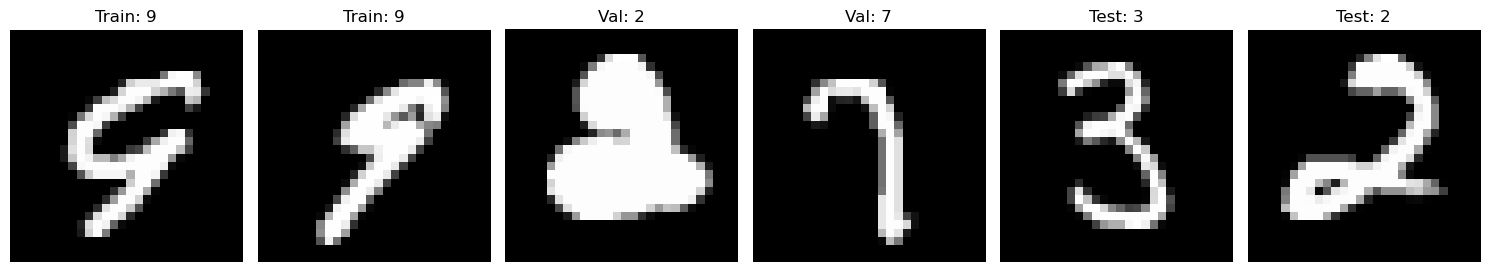

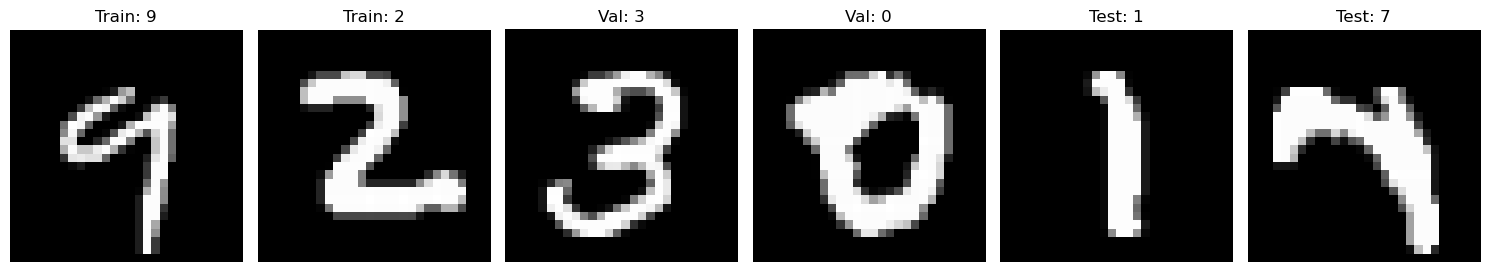

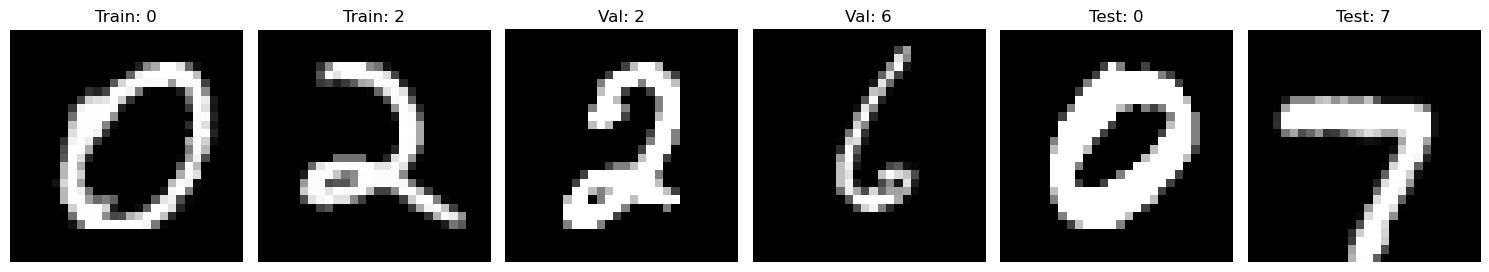

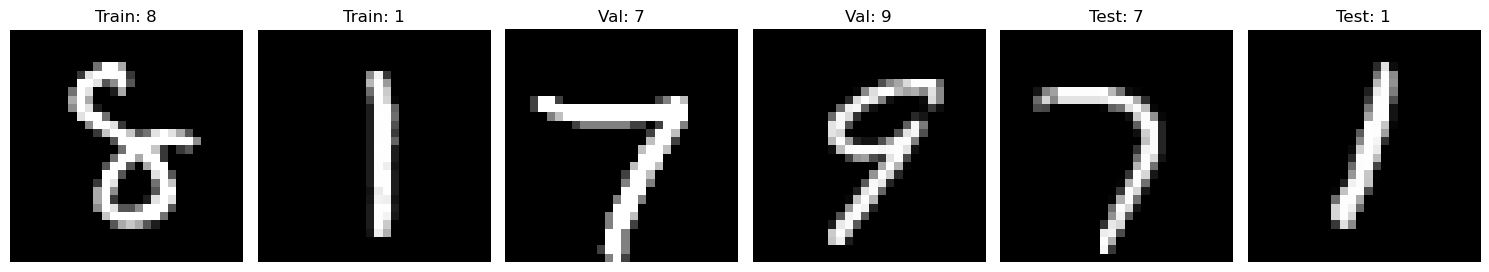

In [7]:
for client_idx, (train_loader, val_loader, test_loader) in enumerate(loaders):
    if(client_idx >= 4):
        break
    fig, axes = plt.subplots(1, 6, figsize=(15, 6))
    
    # Train
    for j, (x, y) in enumerate(train_loader):
        if j >= 2:
            break
        axes[j].imshow(x[0].squeeze(), cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Train: {y[0].item()}")
    
    # Validation
    for j, (x, y) in enumerate(val_loader):
        if j >= 2:
            break
        axes[j+2].imshow(x[0].squeeze(), cmap='gray')
        axes[j+2].axis('off')
        axes[j+2].set_title(f"Val: {y[0].item()}")
    
    # Test
    for j, (x, y) in enumerate(test_loader):
        if j >= 2:
            break
        axes[j+4].imshow(x[0].squeeze(), cmap='gray')
        axes[j+4].axis('off')
        axes[j+4].set_title(f"Test: {y[0].item()}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [8]:
# Wrap the above ugly code of flower client into a class

# Helper Functions

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def train(net, trainloader, epochs: int, verbose=False, device = "cuda"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    net.to(device)
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader, device):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    net.to(device)
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Custom Client Class
class FLClient(NumPyClient):
    """A Flower client that holds its own model and training data."""

    def __init__(
        self,
        net: nn.Module,
        trainloader: DataLoader,
        valloader: DataLoader,
        device: torch.device,
        client_id: int,
        epochs: int = 1,
    ):
        super().__init__()
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.device = device
        self.client_id = client_id
        self.epochs = epochs

    def get_parameters(self, config: Dict[str, Scalar]) -> List[np.ndarray]:
        """Return the current local model parameters."""
        return get_parameters(self.net)

    def fit(
        self, parameters: List[np.ndarray], config: Dict[str, Scalar]
    ) -> Tuple[List[np.ndarray], int, Dict[str, Scalar]]:
        # Set parameters except for the fourth layer
        current_params = get_parameters(self.net)
        
        for i, param in enumerate(parameters):
            if not skip_layer or i != 4:  # Skip the fourth layer
                current_params[i] = param
        set_parameters(self.net, current_params)
        
        train(self.net, self.trainloader, device=self.device, epochs=self.epochs, verbose=False)
        new_params = get_parameters(self.net)
        # Return partition-id in the metrics
        # The simplest way to store the model
        return new_params, len(self.trainloader.dataset), {"partition-id": self.client_id}

    def evaluate(
        self, parameters: List[np.ndarray], config: Dict[str, Scalar]
    ) -> Tuple[float, int, Dict[str, Scalar]]:
        # Set parameters except for the fourth layer
        current_params = get_parameters(self.net)
        
        for i, param in enumerate(parameters):
            if not skip_layer or i != 4:  # Skip the fourth layer
                current_params[i] = param
                    
        set_parameters(self.net, current_params)
        
        loss, accuracy = test(self.net, self.valloader, self.device)
        print(f"[Client {self.client_id}] Evaluate -> Loss: {loss:.4f}, Accuracy: {accuracy:.4f} :::::: {current_params[3]}")
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

class DefaultStrategy(FedAvg):

    # A custom strategy to store all the parameters.
    # https://github.com/adap/flower/issues/487
    # https://flower.ai/docs/framework/how-to-save-and-load-model-checkpoints.html

    def __init__(self, model: type, total_round: int, only_last: bool = True, save_dir: str = "models", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.model = model
        self.total_round = total_round
        self.only_last = only_last

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """
        Aggregate model weights using weighted average.
        Also save each client's model and the global server model.
        """

        if self.only_last and server_round < self.total_round:
            return super().aggregate_fit(server_round, results, failures)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        # For each client which returned FitRes, save the client model
        for (_, fit_res) in results:
            id_ = fit_res.metrics["partition-id"]

            client_parameters: Optional[Parameters] = fit_res.parameters
            if client_parameters is not None:
                net = self.model()
                print(f"[Round {server_round}] Saving model for client {id_}...")

                # Convert `Parameters` to `list[np.ndarray]`
                client_ndarrays : list[np.ndarray] = parameters_to_ndarrays(
                    client_parameters
                )

                # Convert `list[np.ndarray]` to PyTorch `state_dict`
                params_dict = zip(net.state_dict().keys(), client_ndarrays)
                state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
                net.load_state_dict(state_dict, strict=True)

                # Save the model to disk
                torch.save(net.state_dict(), f"{self.save_dir}/client-{server_round}-{id_}.pth")

        # If `aggregated_parameters` is not None, update the global net and save it
        if aggregated_parameters is not None:
            net = self.model()
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `list[np.ndarray]`
            aggregated_ndarrays: list[np.ndarray] = parameters_to_ndarrays(
                aggregated_parameters
            )

            # Convert `list[np.ndarray]` to PyTorch `state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model to disk
            torch.save(net.state_dict(), f"{self.save_dir}/server-{server_round}.pth")

        return aggregated_parameters, aggregated_metrics


In [9]:
# Use the following class to run the experiment

# You need to provide the following information:
# 1. The Network class (dont instantiate it)
#       (assume we use the same network for all clients and server)
# 2. The list of data loaders for each client,
#       where loaders is a list of loader tuples (train, val, test)
#       i.e. loaders = [ (train_loader_0, val_loader_0, test_loader_0), ... ]
#       NOTE: In fit and evaluate, we ONLY use the train_loader and val_loader,
#             But we ask you to pyt them together for simplicity for any future test use.
#       NOTE: we assume the number of clients == number of data loaders
# 3. Number of clients

# See next block for an example of how to use this class

class FLExperiment:
    """
    A federated learning experiment interface class.

    NOTE: For each client, we now expect a tuple of three DataLoaders:
    (train_loader, val_loader, test_loader).
    """

    def __init__(
        self,
        model_cls: type,
        client_loaders: List[Tuple[DataLoader, DataLoader, DataLoader]],
        num_clients: int,
        device: torch.device = torch.device("cuda"),
        local_epochs: int = 1,
        num_rounds: int = 5,
        # strategy: Optional[Strategy] = None, # Is not supported yet. and may not be needed
    ):
        """
        Args:
            model_cls (type): A PyTorch nn.Module class (not an instance).
                We'll instantiate `model_cls()` for each client and server.
            client_loaders (List[(DataLoader, DataLoader, DataLoader)]):
                A list of (train_loader, val_loader, test_loader) for each client.
            num_clients (int): Number of clients to simulate.
            device (torch.device): CPU or GPU device.
            local_epochs (int): Local epochs on each client per round.
            num_rounds (int): How many global training rounds.
            strategy (Optional[Strategy]): Use a custom Flower strategy or fallback to default FedAvg.
        """
        while len(client_loaders) < num_clients:
            client_loaders.append(client_loaders[0])
        
        
        # if len(client_loaders) != num_clients:
        #     raise ValueError(
        #         f"Number of client loader tuples ({len(client_loaders)}) does not match "
        #         f"the number of clients ({num_clients})."
        #     )

        self.model_cls = model_cls
        self.client_loaders = client_loaders
        self.num_clients = num_clients
        self.local_epochs = local_epochs
        self.num_rounds = num_rounds
        self.device = device

        # Store final trained models
        self._client_models: List[Optional[nn.Module]] = [None] * self.num_clients
        self._server_model: Optional[nn.Module] = None

        # Create one model per client (instantiate model_cls)
        self.client_nets = [self.model_cls().to(self.device) for _ in range(self.num_clients)]

        self.strategy = self._create_default_strategy(save_only_last=True)
        # # Use user-provided strategy or create a default one
        # if strategy is None:
        #     self.strategy = self._create_default_strategy()
        # else:
        #     self.strategy = strategy

    def _create_default_strategy(self, save_only_last: bool) -> Strategy:
        """Create a default FedAvg strategy with a minimal server_evaluate."""

        def server_evaluate(
            server_round: int,
            parameters: NDArrays,
            config: Dict[str, Scalar]
        ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
            # Minimal server eval (no real evaluation)
            net = self.model_cls().to(self.device)
            set_parameters(net, parameters)
            print(f"[Server] Round {server_round} - no global evaluation implemented.")
            return None

        def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
            accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
            examples = [num_examples for num_examples, _ in metrics]
            if sum(examples) == 0:
                return {"accuracy": 0.0}
            return {"accuracy": sum(accuracies) / sum(examples)}

        default_strategy = DefaultStrategy(
            model = self.model_cls,
            total_round = self.num_rounds,
            only_last = save_only_last,
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_fit_clients=self.num_clients,
            min_evaluate_clients=self.num_clients,
            min_available_clients=self.num_clients,
            evaluate_fn=server_evaluate,
            evaluate_metrics_aggregation_fn=weighted_average,
        )
        return default_strategy

    def _client_fn(self, context: Context) -> Client:
        """Construct one Flower client using the partition_id to pick (train, val, test)."""
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, _ = self.client_loaders[partition_id]
        net = self.client_nets[partition_id]
        client = FLClient(
            net=net,
            trainloader=trainloader,
            valloader=valloader,
            device=self.device,
            client_id=partition_id,
            epochs=self.local_epochs
        )
        return client.to_client()

    def _server_fn(self, context: Context) -> ServerAppComponents:
        """Server-side: configure strategy and server config."""
        config = ServerConfig(num_rounds=self.num_rounds)
        return ServerAppComponents(strategy=self.strategy, config=config)

    def run(self, save_only_last: bool = True) -> None:
        """Run the federated learning simulation and store final client/server models.
        
        Args:
            save_only_last (bool): Save only the last round of models.
                Default True. If False, all models will be saved.
        """
        # print("[FLExperiment] Starting federated training...")
        self.strategy = self._create_default_strategy(save_only_last=save_only_last)
        client_app = ClientApp(client_fn=self._client_fn)
        server_app = ServerApp(server_fn=self._server_fn)

        # Resource allocation
        if self.device.type == "cuda":
            backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
        else:
            backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

        # Run the simulation
        run_simulation(
            client_app=client_app,
            server_app=server_app,
            num_supernodes=self.num_clients,
            backend_config=backend_config,
        )
        # print("[FLExperiment] Federated training finished.")

    def get_clients(self, round_num: int = 0) -> List[nn.Module]:
        """Return final trained models for all clients (if they have been saved).
        
        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            List[nn.Module]: List of final trained models for all clients.
                The index of the list corresponds to the client ID 
                and the index of dataloader. 
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            return [
                torch.load(f"models/client-{round_num}-{cid}.pth", map_location=self.device, weights_only=True)
                for cid in range(self.num_clients)
            ]
        except FileNotFoundError:
            raise RuntimeError("Client models are not available. Have you called run() or set only_last=True?")
    
    def get_client_dataloader_tuples(self, round_num: int = 0) -> List[Tuple[nn.Module, Tuple[DataLoader, DataLoader, DataLoader]]]:
        """Return the dataloaders for all clients.
         
        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            List[Tuple[nn.Module, Tuple[DataLoader, DataLoader, DataLoader]]]:
                List of (client_model, (train_loader, val_loader, test_loader))
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            clients = self.get_clients(round_num)
            return list(zip(clients, self.client_loaders)) 
        except FileNotFoundError:
            raise RuntimeError("Client dataloaders are not available. Have you called run() or set only_last=True?")

    def get_server(self, round_num: int = 0) -> nn.Module:
        """Return the final server model (if stored).

        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            nn.Module: The final server model.
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            return torch.load(f"models/server-{round_num}.pth", map_location=self.device, weights_only=True)
        except FileNotFoundError:
            raise RuntimeError("Server model is not available. Have you called run() or set only_last=True?")
    

In [10]:
# Test the client model 0 on the corresponding test set
def print_results(fl_exp, ignore_clients = [], loader_override = None):
    loader_override = loader_override or loaders
    clients = fl_exp.get_clients()
    mean_accuracy = 0
    acc_count = 0
    for i in range(len(clients)):
        if(i in ignore_clients):
            continue
        
        acc_count += 1
        model0_1 = Net().to(DEVICE)
        model0_1.load_state_dict(clients[i])
        model0_1.eval()

        _, _, test_loader_1 = loader_override[i]
        loss, accuracy = test(model0_1, test_loader_1, "cuda")
        print(f"Client {i} accuracy: {accuracy}")
        mean_accuracy += accuracy
    
    mean_accuracy /= max(acc_count, 1)

    '''
    # Or Alternatively
    client_dls = fl_exp.get_client_dataloader_tuples()
    model0_2 = Net().to(DEVICE)
    model0_2.load_state_dict(client_dls[0][0])
    model0_2.eval()

    _, _, test_loader_2 = client_dls[0][1]
    loss, accuracy = test(model0_2, test_loader_2, "cpu")
    print(f"Client {i} accuracy: {accuracy}")
    '''

    # Test the server
    server = fl_exp.get_server()
    model_s = Net().to(DEVICE)
    model_s.load_state_dict(server)
    model_s.eval()

    _, _, test_loader_s = loader_override[0]
    loss, accuracy = test(model_s, test_loader_s, "cuda")
    print(f"Server accuracy: {accuracy}")
    print(f"Mean accuracy: {mean_accuracy}")
    return mean_accuracy

In [22]:
fl_exp = FLExperiment(
    model_cls=Net,
    client_loaders=loaders,
    num_clients=1,
    num_rounds=4,
)


fl_exp.run(True)
print_results(fl_exp)

INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Server] Round 1 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1094321) [Client 0] Evaluate -> Loss: 0.0103, Accuracy: 0.9083 :::::: [ 0.07804797 -0.08505381  0.0139443   0.09061328 -0.04329831  0.07386043
(ClientAppActor pid=1094321)   0.01191581  0.01507266  0.05461428  0.07421101  0.0889191   0.03554206
(ClientAppActor pid=1094321)   0.05418141  0.07780266 -0.05170199 -0.03773293]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Server] Round 2 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1094321) [Client 0] Evaluate -> Loss: 0.0053, Accuracy: 0.9583 :::::: [ 0.08695812 -0.07815745  0.00232262  0.08253332 -0.03453172  0.07062221
(ClientAppActor pid=1094321)   0.01233965  0.01967     0.05269039  0.06484827  0.09546443  0.03367967
(ClientAppActor pid=1094321)   0.04474042  0.07143126 -0.05868506 -0.03570138]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Server] Round 3 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1094321) [Client 0] Evaluate -> Loss: 0.0042, Accuracy: 0.9608 :::::: [ 9.3173668e-02 -7.4328221e-02  6.4550724e-05  7.8901663e-02
(ClientAppActor pid=1094321)  -3.2771125e-02  7.1328402e-02  1.1169949e-02  2.6948394e-02
(ClientAppActor pid=1094321)   5.1874813e-02  5.6869060e-02  9.6106425e-02  3.9404683e-02
(ClientAppActor pid=1094321)   4.4782117e-02  6.8044156e-02 -5.8685061e-02 -3.9456535e-02]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 7.87s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.010284035777052244
INFO :      		round 2: 0.005253441116462151
INFO :      		round 3: 0.004220406910559783
INFO :      		round 4: 0.004699103675472239
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9083333333333333),
INFO :      	              (2, 0.9583333333333334),
INFO :      	              (3, 0.9608333333333333),
INFO :      	              (4, 0.9575)]}
INFO :      


(ClientAppActor pid=1094321) [Client 0] Evaluate -> Loss: 0.0047, Accuracy: 0.9575 :::::: [ 0.0942444  -0.07409713 -0.00667721  0.0724702  -0.03115218  0.07314806
(ClientAppActor pid=1094321)   0.00977504  0.02824179  0.05062198  0.0568605   0.09430771  0.03728412
(ClientAppActor pid=1094321)   0.04081553  0.06974855 -0.05868506 -0.03491461]
Client 0 accuracy: 0.96375
Server accuracy: 0.96375
Mean accuracy: 0.96375


0.96375

# Local Numbers Only

In [23]:
os.makedirs(os.path.dirname("results/local_numbers.txt"), exist_ok=True)

numClients = 5
client_indices = defaultdict(list)

# Iterate over the dataset and distribute indices based on the label
for idx, (_, label) in enumerate(mnist_dataset):
    client_id = label % NUM_CLIENTS
    client_indices[client_id].append(idx)

# Create subsets for each client
local_numbers_subsets = [Subset(mnist_dataset, client_indices[i]) for i in range(NUM_CLIENTS)]
local_number_loaders = []
for j in range(numClients):
    local_number_loaders.append(create_loader(local_numbers_subsets[j], "Local number"))

def simulate_local_number():
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=local_number_loaders,
        num_clients=numClients,
        num_rounds=30,
    )

    fl_exp.run(True)
    accuracy = print_results(fl_exp)
    # with open("results/local_numbers.txt", "a") as result_file:
    #     result_file.write(f"{0},{accuracy}")
    #     result_file.write("\n")

simulate_local_number()
        

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0664, Accuracy: 0.0026 :::::: [ 0.08875205  0.06258212  0.03714256  0.06447829 -0.00902555  0.03542478
(ClientAppActor pid=1094929)   0.08799963  0.03974252 -0.03519283  0.00819085 -0.04245872  0.0335665
(ClientAppActor pid=1094929)  -0.00929721  0.04187924  0.0322018  -0.05287804]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0595, Accuracy: 0.5427 :::::: [ 0.08875205  0.06258212  0.03714256  0.06447829 -0.00902555  0.03542478
(ClientAppActor pid=1094929)   0.08799963  0.03974252 -0.03519283  0.00819085 -0.04245872  0.0335665
(ClientAppActor pid=1094929)  -0.00929721  0.04187924  0.0322018  -0.05287804]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0624, Accuracy: 0.0352 :::::: [ 0.08875205  0.06258212  0.03714256  0.06447829 -0.00902555  0.03542478
(ClientAppActor pid=1094929)   0.08799963  0.03974252 -0.03519283  0.00819085 -0.04245872  0.03356

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0767, Accuracy: 0.0000 :::::: [ 0.08875205  0.06258212  0.03714256  0.06447829 -0.00902555  0.03542478
(ClientAppActor pid=1094929)   0.08799963  0.03974252 -0.03519283  0.00819085 -0.04245872  0.0335665
(ClientAppActor pid=1094929)  -0.00929721  0.04187924  0.0322018  -0.05287804]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0770, Accuracy: 0.0282 :::::: [ 0.0845859   0.05224305  0.03920779  0.06654945 -0.00278384  0.02638518
(ClientAppActor pid=1094929)   0.07536747  0.02789124 -0.02526022  0.00245132 -0.04889759  0.03492633
(ClientAppActor pid=1094929)  -0.01583461  0.03188792  0.02376112 -0.06480633]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0440, Accuracy: 0.8989 :::::: [ 0.0845859   0.05224305  0.03920779  0.06654945 -0.00278384  0.02638518
(ClientAppActor pid=1094929)   0.07536747  0.02789124 -0.02526022  0.00245132 -0.04889759  0.03492633
(ClientAppActor pid=1094929)  -0.01583461  0.03188792  0.02376112 -0.06480633]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0505, Accuracy: 0.4370 :::::: [ 0.0845859   0.05224305  0.03920779  0.06654945 -0.00278384  0.02638518
(ClientAppActor pid=1094929)   0.07536747  0.02789124 -0.02526022  0.00245132 -0.04889759  0.034

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0652, Accuracy: 0.0322 :::::: [ 0.0845859   0.05224305  0.03920779  0.06654945 -0.00278384  0.02638518
(ClientAppActor pid=1094929)   0.07536747  0.02789124 -0.02526022  0.00245132 -0.04889759  0.03492633
(ClientAppActor pid=1094929)  -0.01583461  0.03188792  0.02376112 -0.06480633]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0665, Accuracy: 0.0873 :::::: [ 0.08326972  0.04626419  0.03993981  0.0662493  -0.00104081  0.02164635
(ClientAppActor pid=1094929)   0.06682381  0.01484325 -0.01830374 -0.00625937 -0.05459736  0.03360209
(ClientAppActor pid=1094929)  -0.02765649  0.02395188  0.01336457 -0.07586943]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0400, Accuracy: 0.8128 :::::: [ 0.08326972  0.04626419  0.03993981  0.0662493  -0.00104081  0.02164635
(ClientAppActor pid=1094929)   0.06682381  0.01484325 -0.01830374 -0.00625937 -0.05459736  0.03360209
(ClientAppActor pid=1094929)  -0.02765649  0.02395188  0.01336457 -0.07586943]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0452, Accuracy: 0.4984 :::::: [ 0.08326972  0.04626419  0.03993981  0.0662493  -0.00104081  0.02164635
(ClientAppActor pid=1094929)   0.06682381  0.01484325 -0.01830374 -0.00625937 -0.05459736  0.033

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0602, Accuracy: 0.0543 :::::: [ 0.08326972  0.04626419  0.03993981  0.0662493  -0.00104081  0.02164635
(ClientAppActor pid=1094929)   0.06682381  0.01484325 -0.01830374 -0.00625937 -0.05459736  0.03360209
(ClientAppActor pid=1094929)  -0.02765649  0.02395188  0.01336457 -0.07586943]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0572, Accuracy: 0.2540 :::::: [ 0.08492414  0.03940481  0.04072453  0.06591469 -0.00139568  0.01621624
(ClientAppActor pid=1094929)   0.05605622 -0.00645943 -0.01696778 -0.01049047 -0.06351974  0.02645353
(ClientAppActor pid=1094929)  -0.03904356  0.01244765 -0.0028043  -0.0873199 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0383, Accuracy: 0.7812 :::::: [ 0.08492414  0.03940481  0.04072453  0.06591469 -0.00139568  0.01621624
(ClientAppActor pid=1094929)   0.05605622 -0.00645943 -0.01696778 -0.01049047 -0.06351974  0.02645353
(ClientAppActor pid=1094929)  -0.03904356  0.01244765 -0.0028043  -0.0873199 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0478, Accuracy: 0.4624 :::::: [ 0.08492414  0.03940481  0.04072453  0.06591469 -0.00139568  0.01621624
(ClientAppActor pid=1094929)   0.05605622 -0.00645943 -0.01696778 -0.01049047 -0.06351974  0.026

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0553, Accuracy: 0.2655 :::::: [ 0.08492414  0.03940481  0.04072453  0.06591469 -0.00139568  0.01621624
(ClientAppActor pid=1094929)   0.05605622 -0.00645943 -0.01696778 -0.01049047 -0.06351974  0.02645353
(ClientAppActor pid=1094929)  -0.03904356  0.01244765 -0.0028043  -0.0873199 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 5 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0508, Accuracy: 0.3915 :::::: [ 0.08822377  0.03599316  0.03991166  0.06864182 -0.00098936  0.01164023
(ClientAppActor pid=1094929)   0.04908167 -0.02217786 -0.01747712 -0.01377623 -0.06721852  0.0206352
(ClientAppActor pid=1094929)  -0.04744229  0.00483417 -0.01609981 -0.0975403 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0356, Accuracy: 0.7954 :::::: [ 0.08822377  0.03599316  0.03991166  0.06864182 -0.00098936  0.01164023
(ClientAppActor pid=1094929)   0.04908167 -0.02217786 -0.01747712 -0.01377623 -0.06721852  0.0206352
(ClientAppActor pid=1094929)  -0.04744229  0.00483417 -0.01609981 -0.0975403 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0477, Accuracy: 0.4689 :::::: [ 0.08822377  0.03599316  0.03991166  0.06864182 -0.00098936  0.01164023
(ClientAppActor pid=1094929)   0.04908167 -0.02217786 -0.01747712 -0.01377623 -0.06721852  0.02063

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 3] Evaluate -> Loss: 0.0542, Accuracy: 0.3255 :::::: [ 0.08822377  0.03599316  0.03991166  0.06864182 -0.00098936  0.01164023
(ClientAppActor pid=1094929)   0.04908167 -0.02217786 -0.01747712 -0.01377623 -0.06721852  0.0206352
(ClientAppActor pid=1094929)  -0.04744229  0.00483417 -0.01609981 -0.0975403 ]
(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0519, Accuracy: 0.3003 :::::: [ 0.08822377  0.03599316  0.03991166  0.06864182 -0.00098936  0.01164023
(ClientAppActor pid=1094929)   0.04908167 -0.02217786 -0.01747712 -0.01377623 -0.06721852  0.0206352
(ClientAppActor pid=1094929)  -0.04744229  0.00483417 -0.01609981 -0.0975403 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 6 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0452, Accuracy: 0.4418 :::::: [ 0.09027275  0.03721689  0.04043458  0.07158777  0.00082997  0.00932178
(ClientAppActor pid=1094929)   0.04497569 -0.03283153 -0.01994796 -0.01420534 -0.06872228  0.01663247
(ClientAppActor pid=1094929)  -0.04980887  0.00195577 -0.01868077 -0.1031812 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0324, Accuracy: 0.7891 :::::: [ 0.09027275  0.03721689  0.04043458  0.07158777  0.00082997  0.00932178
(ClientAppActor pid=1094929)   0.04497569 -0.03283153 -0.01994796 -0.01420534 -0.06872228  0.01663247
(ClientAppActor pid=1094929)  -0.04980887  0.00195577 -0.01868077 -0.1031812 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0458, Accuracy: 0.4828 :::::: [ 0.09027275  0.03721689  0.04043458  0.07158777  0.00082997  0.00932178
(ClientAppActor pid=1094929)   0.04497569 -0.03283153 -0.01994796 -0.01420534 -0.06872228  0.016

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0479, Accuracy: 0.3367 :::::: [ 0.09027275  0.03721689  0.04043458  0.07158777  0.00082997  0.00932178
(ClientAppActor pid=1094929)   0.04497569 -0.03283153 -0.01994796 -0.01420534 -0.06872228  0.01663247
(ClientAppActor pid=1094929)  -0.04980887  0.00195577 -0.01868077 -0.1031812 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 7 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0412, Accuracy: 0.5926 :::::: [ 0.08970192  0.03220988  0.03979278  0.07254268 -0.00302385  0.00664122
(ClientAppActor pid=1094929)   0.0379206  -0.04522647 -0.02367777 -0.01857227 -0.07091583  0.00779968
(ClientAppActor pid=1094929)  -0.05945457 -0.00717542 -0.02707329 -0.11423466]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0330, Accuracy: 0.8294 :::::: [ 0.08970192  0.03220988  0.03979278  0.07254268 -0.00302385  0.00664122
(ClientAppActor pid=1094929)   0.0379206  -0.04522647 -0.02367777 -0.01857227 -0.07091583  0.00779968
(ClientAppActor pid=1094929)  -0.05945457 -0.00717542 -0.02707329 -0.11423466]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0499, Accuracy: 0.4296 :::::: [ 0.08970192  0.03220988  0.03979278  0.07254268 -0.00302385  0.00664122
(ClientAppActor pid=1094929)   0.0379206  -0.04522647 -0.02367777 -0.01857227 -0.07091583  0.007

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0480, Accuracy: 0.3664 :::::: [ 0.08970192  0.03220988  0.03979278  0.07254268 -0.00302385  0.00664122
(ClientAppActor pid=1094929)   0.0379206  -0.04522647 -0.02367777 -0.01857227 -0.07091583  0.00779968
(ClientAppActor pid=1094929)  -0.05945457 -0.00717542 -0.02707329 -0.11423466]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 8 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0416, Accuracy: 0.5414 :::::: [ 0.09267518  0.02877947  0.04058719  0.0761026   0.00254305  0.00534696
(ClientAppActor pid=1094929)   0.03519194 -0.05693402 -0.016211   -0.01723198 -0.07407025  0.00239965
(ClientAppActor pid=1094929)  -0.06499074 -0.01267217 -0.03092317 -0.12192918]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0316, Accuracy: 0.8152 :::::: [ 0.09267518  0.02877947  0.04058719  0.0761026   0.00254305  0.00534696
(ClientAppActor pid=1094929)   0.03519194 -0.05693402 -0.016211   -0.01723198 -0.07407025  0.00239965
(ClientAppActor pid=1094929)  -0.06499074 -0.01267217 -0.03092317 -0.12192918]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0512, Accuracy: 0.4157 :::::: [ 0.09267518  0.02877947  0.04058719  0.0761026   0.00254305  0.00534696
(ClientAppActor pid=1094929)   0.03519194 -0.05693402 -0.016211   -0.01723198 -0.07407025  0.002

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0439, Accuracy: 0.4232 :::::: [ 0.09267518  0.02877947  0.04058719  0.0761026   0.00254305  0.00534696
(ClientAppActor pid=1094929)   0.03519194 -0.05693402 -0.016211   -0.01723198 -0.07407025  0.00239965
(ClientAppActor pid=1094929)  -0.06499074 -0.01267217 -0.03092317 -0.12192918]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 9 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0400, Accuracy: 0.5273 :::::: [ 0.09684542  0.02890402  0.04230759  0.07707841  0.00486169  0.00434622
(ClientAppActor pid=1094929)   0.03292409 -0.06212261 -0.01684454 -0.01732746 -0.07521632  0.00135279
(ClientAppActor pid=1094929)  -0.07448713 -0.01747671 -0.03337957 -0.1272717 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0316, Accuracy: 0.7646 :::::: [ 0.09684542  0.02890402  0.04230759  0.07707841  0.00486169  0.00434622
(ClientAppActor pid=1094929)   0.03292409 -0.06212261 -0.01684454 -0.01732746 -0.07521632  0.00135279
(ClientAppActor pid=1094929)  -0.07448713 -0.01747671 -0.03337957 -0.1272717 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0509, Accuracy: 0.4157 :::::: [ 0.09684542  0.02890402  0.04230759  0.07707841  0.00486169  0.00434622
(ClientAppActor pid=1094929)   0.03292409 -0.06212261 -0.01684454 -0.01732746 -0.07521632  0.001

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0413, Accuracy: 0.3885 :::::: [ 0.09684542  0.02890402  0.04230759  0.07707841  0.00486169  0.00434622
(ClientAppActor pid=1094929)   0.03292409 -0.06212261 -0.01684454 -0.01732746 -0.07521632  0.00135279
(ClientAppActor pid=1094929)  -0.07448713 -0.01747671 -0.03337957 -0.1272717 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 10 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0402, Accuracy: 0.5511 :::::: [ 0.0962044   0.02529496  0.04446057  0.07793687  0.00666608  0.00395531
(ClientAppActor pid=1094929)   0.02919832 -0.07046816 -0.0222656  -0.02031688 -0.07460177 -0.00376875
(ClientAppActor pid=1094929)  -0.08280282 -0.02215895 -0.03801118 -0.13366632]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0303, Accuracy: 0.8325 :::::: [ 0.0962044   0.02529496  0.04446057  0.07793687  0.00666608  0.00395531
(ClientAppActor pid=1094929)   0.02919832 -0.07046816 -0.0222656  -0.02031688 -0.07460177 -0.00376875
(ClientAppActor pid=1094929)  -0.08280282 -0.02215895 -0.03801118 -0.13366632]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0513, Accuracy: 0.4247 :::::: [ 0.0962044   0.02529496  0.04446057  0.07793687  0.00666608  0.00395531
(ClientAppActor pid=1094929)   0.02919832 -0.07046816 -0.0222656  -0.02031688 -0.07460177 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 3] Evaluate -> Loss: 0.0420, Accuracy: 0.5083 :::::: [ 0.0962044   0.02529496  0.04446057  0.07793687  0.00666608  0.00395531
(ClientAppActor pid=1094929)   0.02919832 -0.07046816 -0.0222656  -0.02031688 -0.07460177 -0.00376875
(ClientAppActor pid=1094929)  -0.08280282 -0.02215895 -0.03801118 -0.13366632]
(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0405, Accuracy: 0.4444 :::::: [ 0.0962044   0.02529496  0.04446057  0.07793687  0.00666608  0.00395531
(ClientAppActor pid=1094929)   0.02919832 -0.07046816 -0.0222656  -0.02031688 -0.07460177 -0.00376875
(ClientAppActor pid=1094929)  -0.08280282 -0.02215895 -0.03801118 -0.13366632]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 11 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0354, Accuracy: 0.5970 :::::: [ 0.09812122  0.02432527  0.04437166  0.07904562  0.0060506   0.00408736
(ClientAppActor pid=1094929)   0.0289211  -0.07638672 -0.0250092  -0.01809986 -0.07633492 -0.00183548
(ClientAppActor pid=1094929)  -0.08717308 -0.02568932 -0.04038728 -0.13727395]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0290, Accuracy: 0.8460 :::::: [ 0.09812122  0.02432527  0.04437166  0.07904562  0.0060506   0.00408736
(ClientAppActor pid=1094929)   0.0289211  -0.07638672 -0.0250092  -0.01809986 -0.07633492 -0.00183548
(ClientAppActor pid=1094929)  -0.08717308 -0.02568932 -0.04038728 -0.13727395]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0535, Accuracy: 0.4223 :::::: [ 0.09812122  0.02432527  0.04437166  0.07904562  0.0060506   0.00408736
(ClientAppActor pid=1094929)   0.0289211  -0.07638672 -0.0250092  -0.01809986 -0.07633492 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0373, Accuracy: 0.4580 :::::: [ 0.09812122  0.02432527  0.04437166  0.07904562  0.0060506   0.00408736
(ClientAppActor pid=1094929)   0.0289211  -0.07638672 -0.0250092  -0.01809986 -0.07633492 -0.00183548
(ClientAppActor pid=1094929)  -0.08717308 -0.02568932 -0.04038728 -0.13727395]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 12 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0393, Accuracy: 0.5212 :::::: [ 9.6985668e-02  2.4010425e-02  4.5318849e-02  8.0945492e-02
(ClientAppActor pid=1094929)   1.1406864e-02  4.7365073e-03  2.6224781e-02 -8.2668565e-02
(ClientAppActor pid=1094929)  -2.3906151e-02 -1.6177334e-02 -7.4243031e-02  7.5210351e-05
(ClientAppActor pid=1094929)  -8.9678288e-02 -3.0244254e-02 -3.8171060e-02 -1.3857917e-01]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0278, Accuracy: 0.8523 :::::: [ 9.6985668e-02  2.4010425e-02  4.5318849e-02  8.0945492e-02
(ClientAppActor pid=1094929)   1.1406864e-02  4.7365073e-03  2.6224781e-02 -8.2668565e-02
(ClientAppActor pid=1094929)  -2.3906151e-02 -1.6177334e-02 -7.4243031e-02  7.5210351e-05
(ClientAppActor pid=1094929)  -8.9678288e-02 -3.0244254e-02 -3.8171060e-02 -1.3857917e-01]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0470, Accuracy: 0.4902 :::::: [ 9.6985668e

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0378, Accuracy: 0.4309 :::::: [ 9.6985668e-02  2.4010425e-02  4.5318849e-02  8.0945492e-02
(ClientAppActor pid=1094929)   1.1406864e-02  4.7365073e-03  2.6224781e-02 -8.2668565e-02
(ClientAppActor pid=1094929)  -2.3906151e-02 -1.6177334e-02 -7.4243031e-02  7.5210351e-05
(ClientAppActor pid=1094929)  -8.9678288e-02 -3.0244254e-02 -3.8171060e-02 -1.3857917e-01]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 13 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0319, Accuracy: 0.6455 :::::: [ 0.09627009  0.02367665  0.04466564  0.07964199  0.01897628  0.00337344
(ClientAppActor pid=1094929)   0.02711084 -0.08303896 -0.01591316 -0.01382583 -0.0754929  -0.00073796
(ClientAppActor pid=1094929)  -0.09379671 -0.03204371 -0.03863634 -0.14041261]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0328, Accuracy: 0.7480 :::::: [ 0.09627009  0.02367665  0.04466564  0.07964199  0.01897628  0.00337344
(ClientAppActor pid=1094929)   0.02711084 -0.08303896 -0.01591316 -0.01382583 -0.0754929  -0.00073796
(ClientAppActor pid=1094929)  -0.09379671 -0.03204371 -0.03863634 -0.14041261]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0442, Accuracy: 0.5016 :::::: [ 0.09627009  0.02367665  0.04466564  0.07964199  0.01897628  0.00337344
(ClientAppActor pid=1094929)   0.02711084 -0.08303896 -0.01591316 -0.01382583 -0.0754929  -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0320, Accuracy: 0.5581 :::::: [ 0.09627009  0.02367665  0.04466564  0.07964199  0.01897628  0.00337344
(ClientAppActor pid=1094929)   0.02711084 -0.08303896 -0.01591316 -0.01382583 -0.0754929  -0.00073796
(ClientAppActor pid=1094929)  -0.09379671 -0.03204371 -0.03863634 -0.14041261]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 14 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0326, Accuracy: 0.6164 :::::: [ 0.09752808  0.02080385  0.04504319  0.07906714  0.01916028  0.00412786
(ClientAppActor pid=1094929)   0.02419931 -0.08198979 -0.01327535 -0.01300781 -0.07318419 -0.00384363
(ClientAppActor pid=1094929)  -0.09712575 -0.03254686 -0.03879619 -0.14199613]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0297, Accuracy: 0.7859 :::::: [ 0.09752808  0.02080385  0.04504319  0.07906714  0.01916028  0.00412786
(ClientAppActor pid=1094929)   0.02419931 -0.08198979 -0.01327535 -0.01300781 -0.07318419 -0.00384363
(ClientAppActor pid=1094929)  -0.09712575 -0.03254686 -0.03879619 -0.14199613]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0420, Accuracy: 0.5196 :::::: [ 0.09752808  0.02080385  0.04504319  0.07906714  0.01916028  0.00412786
(ClientAppActor pid=1094929)   0.02419931 -0.08198979 -0.01327535 -0.01300781 -0.07318419 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0341, Accuracy: 0.5216 :::::: [ 0.09752808  0.02080385  0.04504319  0.07906714  0.01916028  0.00412786
(ClientAppActor pid=1094929)   0.02419931 -0.08198979 -0.01327535 -0.01300781 -0.07318419 -0.00384363
(ClientAppActor pid=1094929)  -0.09712575 -0.03254686 -0.03879619 -0.14199613]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 15 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0312, Accuracy: 0.6296 :::::: [ 0.10284908  0.0198028   0.04792609  0.08131757  0.02032511  0.00378408
(ClientAppActor pid=1094929)   0.02103159 -0.08437571 -0.01108815 -0.01237644 -0.0733966  -0.00498034
(ClientAppActor pid=1094929)  -0.10460001 -0.03653004 -0.03989217 -0.1439055 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0231, Accuracy: 0.8736 :::::: [ 0.10284908  0.0198028   0.04792609  0.08131757  0.02032511  0.00378408
(ClientAppActor pid=1094929)   0.02103159 -0.08437571 -0.01108815 -0.01237644 -0.0733966  -0.00498034
(ClientAppActor pid=1094929)  -0.10460001 -0.03653004 -0.03989217 -0.1439055 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0595, Accuracy: 0.3846 :::::: [ 0.10284908  0.0198028   0.04792609  0.08131757  0.02032511  0.00378408
(ClientAppActor pid=1094929)   0.02103159 -0.08437571 -0.01108815 -0.01237644 -0.0733966  -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0346, Accuracy: 0.5038 :::::: [ 0.10284908  0.0198028   0.04792609  0.08131757  0.02032511  0.00378408
(ClientAppActor pid=1094929)   0.02103159 -0.08437571 -0.01108815 -0.01237644 -0.0733966  -0.00498034
(ClientAppActor pid=1094929)  -0.10460001 -0.03653004 -0.03989217 -0.1439055 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 16 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0297, Accuracy: 0.6561 :::::: [ 0.10330451  0.01994528  0.04972908  0.08457482  0.02619608  0.0044851
(ClientAppActor pid=1094929)   0.01765024 -0.08564986 -0.01357158 -0.01424209 -0.07177032 -0.00292741
(ClientAppActor pid=1094929)  -0.1074554  -0.04070152 -0.04042086 -0.14146538]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0259, Accuracy: 0.8436 :::::: [ 0.10330451  0.01994528  0.04972908  0.08457482  0.02619608  0.0044851
(ClientAppActor pid=1094929)   0.01765024 -0.08564986 -0.01357158 -0.01424209 -0.07177032 -0.00292741
(ClientAppActor pid=1094929)  -0.1074554  -0.04070152 -0.04042086 -0.14146538]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0461, Accuracy: 0.5000 :::::: [ 0.10330451  0.01994528  0.04972908  0.08457482  0.02619608  0.0044851
(ClientAppActor pid=1094929)   0.01765024 -0.08564986 -0.01357158 -0.01424209 -0.07177032 -0.00292

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0329, Accuracy: 0.5564 :::::: [ 0.10330451  0.01994528  0.04972908  0.08457482  0.02619608  0.0044851
(ClientAppActor pid=1094929)   0.01765024 -0.08564986 -0.01357158 -0.01424209 -0.07177032 -0.00292741
(ClientAppActor pid=1094929)  -0.1074554  -0.04070152 -0.04042086 -0.14146538]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 17 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0277, Accuracy: 0.6720 :::::: [ 0.09955309  0.02021719  0.04909997  0.08544709  0.02795213  0.00414241
(ClientAppActor pid=1094929)   0.01471254 -0.08535313 -0.01525885 -0.01777823 -0.0717016  -0.00407919
(ClientAppActor pid=1094929)  -0.11128854 -0.04489362 -0.03877516 -0.14568442]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0285, Accuracy: 0.7235 :::::: [ 0.09955309  0.02021719  0.04909997  0.08544709  0.02795213  0.00414241
(ClientAppActor pid=1094929)   0.01471254 -0.08535313 -0.01525885 -0.01777823 -0.0717016  -0.00407919
(ClientAppActor pid=1094929)  -0.11128854 -0.04489362 -0.03877516 -0.14568442]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0452, Accuracy: 0.4853 :::::: [ 0.09955309  0.02021719  0.04909997  0.08544709  0.02795213  0.00414241
(ClientAppActor pid=1094929)   0.01471254 -0.08535313 -0.01525885 -0.01777823 -0.0717016  -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0347, Accuracy: 0.5013 :::::: [ 0.09955309  0.02021719  0.04909997  0.08544709  0.02795213  0.00414241
(ClientAppActor pid=1094929)   0.01471254 -0.08535313 -0.01525885 -0.01777823 -0.0717016  -0.00407919
(ClientAppActor pid=1094929)  -0.11128854 -0.04489362 -0.03877516 -0.14568442]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 18 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0297, Accuracy: 0.6552 :::::: [ 0.10126879  0.01663025  0.04936054  0.08665405  0.02886482  0.00384812
(ClientAppActor pid=1094929)   0.01255837 -0.08967223 -0.01104137 -0.0192363  -0.07046608 -0.00650442
(ClientAppActor pid=1094929)  -0.11199949 -0.04697566 -0.0409499  -0.14309803]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0271, Accuracy: 0.7220 :::::: [ 0.10126879  0.01663025  0.04936054  0.08665405  0.02886482  0.00384812
(ClientAppActor pid=1094929)   0.01255837 -0.08967223 -0.01104137 -0.0192363  -0.07046608 -0.00650442
(ClientAppActor pid=1094929)  -0.11199949 -0.04697566 -0.0409499  -0.14309803]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0460, Accuracy: 0.4885 :::::: [ 0.10126879  0.01663025  0.04936054  0.08665405  0.02886482  0.00384812
(ClientAppActor pid=1094929)   0.01255837 -0.08967223 -0.01104137 -0.0192363  -0.07046608 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0321, Accuracy: 0.5674 :::::: [ 0.10126879  0.01663025  0.04936054  0.08665405  0.02886482  0.00384812
(ClientAppActor pid=1094929)   0.01255837 -0.08967223 -0.01104137 -0.0192363  -0.07046608 -0.00650442
(ClientAppActor pid=1094929)  -0.11199949 -0.04697566 -0.0409499  -0.14309803]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 19 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0239, Accuracy: 0.7302 :::::: [ 0.10178903  0.01654906  0.05175719  0.08775431  0.03299532  0.0050717
(ClientAppActor pid=1094929)   0.01204218 -0.08704668 -0.01297304 -0.02117212 -0.07050776 -0.00546521
(ClientAppActor pid=1094929)  -0.11279441 -0.04810175 -0.0379885  -0.14090838]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0267, Accuracy: 0.7133 :::::: [ 0.10178903  0.01654906  0.05175719  0.08775431  0.03299532  0.0050717
(ClientAppActor pid=1094929)   0.01204218 -0.08704668 -0.01297304 -0.02117212 -0.07050776 -0.00546521
(ClientAppActor pid=1094929)  -0.11279441 -0.04810175 -0.0379885  -0.14090838]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0424, Accuracy: 0.5180 :::::: [ 0.10178903  0.01654906  0.05175719  0.08775431  0.03299532  0.0050717
(ClientAppActor pid=1094929)   0.01204218 -0.08704668 -0.01297304 -0.02117212 -0.07050776 -0.00546

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0336, Accuracy: 0.5250 :::::: [ 0.10178903  0.01654906  0.05175719  0.08775431  0.03299532  0.0050717
(ClientAppActor pid=1094929)   0.01204218 -0.08704668 -0.01297304 -0.02117212 -0.07050776 -0.00546521
(ClientAppActor pid=1094929)  -0.11279441 -0.04810175 -0.0379885  -0.14090838]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 20 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0242, Accuracy: 0.7240 :::::: [ 0.10068949  0.01437334  0.05129039  0.08718771  0.03672224  0.0039375
(ClientAppActor pid=1094929)   0.00838958 -0.08741927 -0.00683103 -0.02238102 -0.0664681  -0.00645801
(ClientAppActor pid=1094929)  -0.11589141 -0.0486851  -0.03848711 -0.14315113]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0294, Accuracy: 0.6864 :::::: [ 0.10068949  0.01437334  0.05129039  0.08718771  0.03672224  0.0039375
(ClientAppActor pid=1094929)   0.00838958 -0.08741927 -0.00683103 -0.02238102 -0.0664681  -0.00645801
(ClientAppActor pid=1094929)  -0.11589141 -0.0486851  -0.03848711 -0.14315113]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0377, Accuracy: 0.5761 :::::: [ 0.10068949  0.01437334  0.05129039  0.08718771  0.03672224  0.0039375
(ClientAppActor pid=1094929)   0.00838958 -0.08741927 -0.00683103 -0.02238102 -0.0664681  -0.00645

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0318, Accuracy: 0.5471 :::::: [ 0.10068949  0.01437334  0.05129039  0.08718771  0.03672224  0.0039375
(ClientAppActor pid=1094929)   0.00838958 -0.08741927 -0.00683103 -0.02238102 -0.0664681  -0.00645801
(ClientAppActor pid=1094929)  -0.11589141 -0.0486851  -0.03848711 -0.14315113]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 21 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0246, Accuracy: 0.7222 :::::: [ 0.10106364  0.01273854  0.0504622   0.08681987  0.03869835  0.00455098
(ClientAppActor pid=1094929)   0.00513591 -0.08560508 -0.00861898 -0.02488169 -0.06754853 -0.0065318
(ClientAppActor pid=1094929)  -0.12083141 -0.05208214 -0.04027997 -0.14691772]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0255, Accuracy: 0.7844 :::::: [ 0.10106364  0.01273854  0.0504622   0.08681987  0.03869835  0.00455098
(ClientAppActor pid=1094929)   0.00513591 -0.08560508 -0.00861898 -0.02488169 -0.06754853 -0.0065318
(ClientAppActor pid=1094929)  -0.12083141 -0.05208214 -0.04027997 -0.14691772]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0449, Accuracy: 0.5065 :::::: [ 0.10106364  0.01273854  0.0504622   0.08681987  0.03869835  0.00455098
(ClientAppActor pid=1094929)   0.00513591 -0.08560508 -0.00861898 -0.02488169 -0.06754853 -0.0065

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0332, Accuracy: 0.5004 :::::: [ 0.10106364  0.01273854  0.0504622   0.08681987  0.03869835  0.00455098
(ClientAppActor pid=1094929)   0.00513591 -0.08560508 -0.00861898 -0.02488169 -0.06754853 -0.0065318
(ClientAppActor pid=1094929)  -0.12083141 -0.05208214 -0.04027997 -0.14691772]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 22 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0210, Accuracy: 0.7681 :::::: [ 0.10227482  0.01629973  0.05164734  0.09039778  0.04048831  0.00613355
(ClientAppActor pid=1094929)   0.00340284 -0.09102689 -0.00321353 -0.02971313 -0.06764077 -0.00339408
(ClientAppActor pid=1094929)  -0.12129418 -0.05650775 -0.03922466 -0.14503144]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0240, Accuracy: 0.7930 :::::: [ 0.10227482  0.01629973  0.05164734  0.09039778  0.04048831  0.00613355
(ClientAppActor pid=1094929)   0.00340284 -0.09102689 -0.00321353 -0.02971313 -0.06764077 -0.00339408
(ClientAppActor pid=1094929)  -0.12129418 -0.05650775 -0.03922466 -0.14503144]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0511, Accuracy: 0.4468 :::::: [ 0.10227482  0.01629973  0.05164734  0.09039778  0.04048831  0.00613355
(ClientAppActor pid=1094929)   0.00340284 -0.09102689 -0.00321353 -0.02971313 -0.06764077 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 23 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0306, Accuracy: 0.6314 :::::: [ 0.10199293  0.01946575  0.05220546  0.09130792  0.04217593  0.00764325
(ClientAppActor pid=1094929)   0.00593204 -0.09451963  0.00462509 -0.02945851 -0.06548376 -0.00286064
(ClientAppActor pid=1094929)  -0.12184494 -0.06071872 -0.04116198 -0.1447111 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0293, Accuracy: 0.6414 :::::: [ 0.10199293  0.01946575  0.05220546  0.09130792  0.04217593  0.00764325
(ClientAppActor pid=1094929)   0.00593204 -0.09451963  0.00462509 -0.02945851 -0.06548376 -0.00286064
(ClientAppActor pid=1094929)  -0.12184494 -0.06071872 -0.04116198 -0.1447111 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0371, Accuracy: 0.5859 :::::: [ 0.10199293  0.01946575  0.05220546  0.09130792  0.04217593  0.00764325
(ClientAppActor pid=1094929)   0.00593204 -0.09451963  0.00462509 -0.02945851 -0.06548376 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0331, Accuracy: 0.5276 :::::: [ 0.10199293  0.01946575  0.05220546  0.09130792  0.04217593  0.00764325
(ClientAppActor pid=1094929)   0.00593204 -0.09451963  0.00462509 -0.02945851 -0.06548376 -0.00286064
(ClientAppActor pid=1094929)  -0.12184494 -0.06071872 -0.04116198 -0.1447111 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 24 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0279, Accuracy: 0.6781 :::::: [ 0.1020316   0.01812496  0.0501151   0.0932726   0.04547993  0.00937566
(ClientAppActor pid=1094929)   0.00511817 -0.10027671  0.00111032 -0.03158439 -0.06347797 -0.00771628
(ClientAppActor pid=1094929)  -0.12094744 -0.06461196 -0.04122987 -0.13973463]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0236, Accuracy: 0.7788 :::::: [ 0.1020316   0.01812496  0.0501151   0.0932726   0.04547993  0.00937566
(ClientAppActor pid=1094929)   0.00511817 -0.10027671  0.00111032 -0.03158439 -0.06347797 -0.00771628
(ClientAppActor pid=1094929)  -0.12094744 -0.06461196 -0.04122987 -0.13973463]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0356, Accuracy: 0.6039 :::::: [ 0.1020316   0.01812496  0.0501151   0.0932726   0.04547993  0.00937566
(ClientAppActor pid=1094929)   0.00511817 -0.10027671  0.00111032 -0.03158439 -0.06347797 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0281, Accuracy: 0.5852 :::::: [ 0.1020316   0.01812496  0.0501151   0.0932726   0.04547993  0.00937566
(ClientAppActor pid=1094929)   0.00511817 -0.10027671  0.00111032 -0.03158439 -0.06347797 -0.00771628
(ClientAppActor pid=1094929)  -0.12094744 -0.06461196 -0.04122987 -0.13973463]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 25 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0294, Accuracy: 0.6376 :::::: [ 0.1017193   0.02101825  0.05247744  0.0962091   0.04203522  0.01118245
(ClientAppActor pid=1094929)   0.00059431 -0.09794297 -0.00297102 -0.03551568 -0.06251369 -0.01118101
(ClientAppActor pid=1094929)  -0.12101602 -0.06461936 -0.04004931 -0.13999969]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0246, Accuracy: 0.7504 :::::: [ 0.1017193   0.02101825  0.05247744  0.0962091   0.04203522  0.01118245
(ClientAppActor pid=1094929)   0.00059431 -0.09794297 -0.00297102 -0.03551568 -0.06251369 -0.01118101
(ClientAppActor pid=1094929)  -0.12101602 -0.06461936 -0.04004931 -0.13999969]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0367, Accuracy: 0.5827 :::::: [ 0.1017193   0.02101825  0.05247744  0.0962091   0.04203522  0.01118245
(ClientAppActor pid=1094929)   0.00059431 -0.09794297 -0.00297102 -0.03551568 -0.06251369 -0.01

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0281, Accuracy: 0.5827 :::::: [ 0.1017193   0.02101825  0.05247744  0.0962091   0.04203522  0.01118245
(ClientAppActor pid=1094929)   0.00059431 -0.09794297 -0.00297102 -0.03551568 -0.06251369 -0.01118101
(ClientAppActor pid=1094929)  -0.12101602 -0.06461936 -0.04004931 -0.13999969]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 26 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0203, Accuracy: 0.7954 :::::: [ 0.09906017  0.02106051  0.05250519  0.09579249  0.04639069  0.01143861
(ClientAppActor pid=1094929)  -0.0004554  -0.09922313  0.00046062 -0.04196423 -0.06053437 -0.01186398
(ClientAppActor pid=1094929)  -0.1224399  -0.06996587 -0.03809332 -0.14387017]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0247, Accuracy: 0.7125 :::::: [ 0.09906017  0.02106051  0.05250519  0.09579249  0.04639069  0.01143861
(ClientAppActor pid=1094929)  -0.0004554  -0.09922313  0.00046062 -0.04196423 -0.06053437 -0.01186398
(ClientAppActor pid=1094929)  -0.1224399  -0.06996587 -0.03809332 -0.14387017]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0426, Accuracy: 0.5155 :::::: [ 0.09906017  0.02106051  0.05250519  0.09579249  0.04639069  0.01143861
(ClientAppActor pid=1094929)  -0.0004554  -0.09922313  0.00046062 -0.04196423 -0.06053437 -0.01

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0294, Accuracy: 0.5835 :::::: [ 0.09906017  0.02106051  0.05250519  0.09579249  0.04639069  0.01143861
(ClientAppActor pid=1094929)  -0.0004554  -0.09922313  0.00046062 -0.04196423 -0.06053437 -0.01186398
(ClientAppActor pid=1094929)  -0.1224399  -0.06996587 -0.03809332 -0.14387017]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 27 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0245, Accuracy: 0.7257 :::::: [ 0.1005783   0.02035699  0.05569103  0.09515844  0.05215245  0.01131724
(ClientAppActor pid=1094929)   0.00443273 -0.09829237  0.00567181 -0.04089466 -0.05728552 -0.00730923
(ClientAppActor pid=1094929)  -0.1212775  -0.07354557 -0.040674   -0.1439143 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0241, Accuracy: 0.7749 :::::: [ 0.1005783   0.02035699  0.05569103  0.09515844  0.05215245  0.01131724
(ClientAppActor pid=1094929)   0.00443273 -0.09829237  0.00567181 -0.04089466 -0.05728552 -0.00730923
(ClientAppActor pid=1094929)  -0.1212775  -0.07354557 -0.040674   -0.1439143 ]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0324, Accuracy: 0.6498 :::::: [ 0.1005783   0.02035699  0.05569103  0.09515844  0.05215245  0.01131724
(ClientAppActor pid=1094929)   0.00443273 -0.09829237  0.00567181 -0.04089466 -0.05728552 -0.00

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0222, Accuracy: 0.6870 :::::: [ 0.1005783   0.02035699  0.05569103  0.09515844  0.05215245  0.01131724
(ClientAppActor pid=1094929)   0.00443273 -0.09829237  0.00567181 -0.04089466 -0.05728552 -0.00730923
(ClientAppActor pid=1094929)  -0.1212775  -0.07354557 -0.040674   -0.1439143 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 28 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0266, Accuracy: 0.6905 :::::: [ 0.0995933   0.02061676  0.05859303  0.09604821  0.05240263  0.01015328
(ClientAppActor pid=1094929)   0.0030488  -0.09953985  0.00538109 -0.04201863 -0.05560878 -0.0108972
(ClientAppActor pid=1094929)  -0.12411638 -0.07725169 -0.03982534 -0.13977945]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0274, Accuracy: 0.6927 :::::: [ 0.0995933   0.02061676  0.05859303  0.09604821  0.05240263  0.01015328
(ClientAppActor pid=1094929)   0.0030488  -0.09953985  0.00538109 -0.04201863 -0.05560878 -0.0108972
(ClientAppActor pid=1094929)  -0.12411638 -0.07725169 -0.03982534 -0.13977945]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0263, Accuracy: 0.7365 :::::: [ 0.0995933   0.02061676  0.05859303  0.09604821  0.05240263  0.01015328
(ClientAppActor pid=1094929)   0.0030488  -0.09953985  0.00538109 -0.04201863 -0.05560878 -0.0108

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0305, Accuracy: 0.5454 :::::: [ 0.0995933   0.02061676  0.05859303  0.09604821  0.05240263  0.01015328
(ClientAppActor pid=1094929)   0.0030488  -0.09953985  0.00538109 -0.04201863 -0.05560878 -0.0108972
(ClientAppActor pid=1094929)  -0.12411638 -0.07725169 -0.03982534 -0.13977945]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 29 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0198, Accuracy: 0.7901 :::::: [ 0.10416995  0.01991312  0.05503801  0.09377541  0.05394989  0.00956192
(ClientAppActor pid=1094929)   0.00184057 -0.10274585  0.00498281 -0.04171318 -0.05637985 -0.0105984
(ClientAppActor pid=1094929)  -0.12474111 -0.0794619  -0.04113838 -0.14277096]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0182, Accuracy: 0.8657 :::::: [ 0.10416995  0.01991312  0.05503801  0.09377541  0.05394989  0.00956192
(ClientAppActor pid=1094929)   0.00184057 -0.10274585  0.00498281 -0.04171318 -0.05637985 -0.0105984
(ClientAppActor pid=1094929)  -0.12474111 -0.0794619  -0.04113838 -0.14277096]
(ClientAppActor pid=1094929) [Client 2] Evaluate -> Loss: 0.0335, Accuracy: 0.6424 :::::: [ 0.10416995  0.01991312  0.05503801  0.09377541  0.05394989  0.00956192
(ClientAppActor pid=1094929)   0.00184057 -0.10274585  0.00498281 -0.04171318 -0.05637985 -0.0105

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0335, Accuracy: 0.5284 :::::: [ 0.10416995  0.01991312  0.05503801  0.09377541  0.05394989  0.00956192
(ClientAppActor pid=1094929)   0.00184057 -0.10274585  0.00498281 -0.04171318 -0.05637985 -0.0105984
(ClientAppActor pid=1094929)  -0.12474111 -0.0794619  -0.04113838 -0.14277096]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 30] Saving model for client 4...
[Round 30] Saving model for client 1...
[Round 30] Saving model for client 2...
[Round 30] Saving model for client 0...
[Round 30] Saving model for client 3...
Saving round 30 aggregated_parameters...
[Server] Round 30 - no global evaluation implemented.
(ClientAppActor pid=1094929) [Client 0] Evaluate -> Loss: 0.0317, Accuracy: 0.6076 :::::: [ 0.09982829  0.01986333  0.05360786  0.09077631  0.05549889  0.00453668
(ClientAppActor pid=1094929)  -0.00184438 -0.10654764  0.00025107 -0.04114945 -0.05147575 -0.00907387
(ClientAppActor pid=1094929)  -0.12404389 -0.08121587 -0.04237393 -0.1487782 ]
(ClientAppActor pid=1094929) [Client 1] Evaluate -> Loss: 0.0227, Accuracy: 0.7923 :::::: [ 0.09982829  0.01986333  0.05360786  0.09077631  0.05549889  0.00453668
(ClientAppActor pid=1094929)  -0.00184438 -0.10654764  0.00025107 -0.04114945 -0.05147575 -0.00907387
(ClientAppActor pid=1094929)  -0.12404389 -0.08121587 -0.04237393 -0.1487782 ]
(ClientAppActor p

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 227.75s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07142895502852567
INFO :      		round 2: 0.06053349558046051
INFO :      		round 3: 0.05492040764830434
INFO :      		round 4: 0.05105646875902581
INFO :      		round 5: 0.04785548991850166
INFO :      		round 6: 0.04440799603404194
INFO :      		round 7: 0.0438232086940415
INFO :      		round 8: 0.04305866180330262
INFO :      		round 9: 0.04127344285911233
INFO :      		round 10: 0.040780874426552885
INFO :      		round 11: 0.039819554331541496
INFO :      		round 12: 0.03867907556102045
INFO :      		round 13: 0.035894502151169405
INFO :      		round 14: 0.035274392327659825
INFO :      		round 15: 0.038989748005311395
INFO :      		round 16: 0.03392758397663369
INFO :      		round 17: 0.03378124209439125
INFO :      		round 18: 0.03409402297723092
INFO :      		round 19

(ClientAppActor pid=1094929) [Client 4] Evaluate -> Loss: 0.0309, Accuracy: 0.5445 :::::: [ 0.09982829  0.01986333  0.05360786  0.09077631  0.05549889  0.00453668
(ClientAppActor pid=1094929)  -0.00184438 -0.10654764  0.00025107 -0.04114945 -0.05147575 -0.00907387
(ClientAppActor pid=1094929)  -0.12404389 -0.08121587 -0.04237393 -0.1487782 ]
Client 0 accuracy: 0.18166666666666667
Client 1 accuracy: 0.21333333333333335
Client 2 accuracy: 0.20541666666666666
Client 3 accuracy: 0.19666666666666666
Client 4 accuracy: 0.19958333333333333
Server accuracy: 0.6758333333333333
Mean accuracy: 0.19933333333333333


# Accuracy vs #Clients

In [24]:
# Decreases the number of clients in each loop iteration 
# (from maxClients down to 1), 
# runs the federated learning experiment, 
# and logs the accuracy.

import os

os.makedirs(os.path.dirname("results/mono_vs_federated.txt"), exist_ok=True)

maxClients = 6
rounds = 3
repeats = 1

# MonoVsFederated Test
for t in range(0, maxClients):
    i = maxClients - t
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=loaders,
        num_clients=i,
        num_rounds=rounds,
    )

    fl_exp.run(True)
    accuracy = print_results(fl_exp)
    with open("results/mono_vs_federated.txt", "a") as result_file:
        result_file.write(f"{i},{maxClients},{accuracy}")
        result_file.write("\n")


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1096516) [Client 0] Evaluate -> Loss: 0.0142, Accuracy: 0.8900 :::::: [-0.04092002  0.04555395  0.06953084 -0.01648128  0.07132938  0.04300366
(ClientAppActor pid=1096516)  -0.04575343  0.0662585  -0.0517326  -0.08144103  0.00680816  0.04724401
(ClientAppActor pid=1096516)   0.05928742  0.01323719 -0.09751585 -0.08236913]
(ClientAppActor pid=1096516) [Client 1] Evaluate -> Loss: 0.0129, Accuracy: 0.8883 :::::: [-0.04092002  0.04555395  0.06953084 -0.01648128  0.07132938  0.04300366
(ClientAppActor pid=1096516)  -0.04575343  0.0662585  -0.0517326  -0.08144103  0.00680816  0.04724401
(ClientAppActor pid=1096516)   0.05928742  0.01323719 -0.09751585 -0.08236913]
(ClientAppActor pid=1096516) [Client 2] Evaluate -> Loss: 0.0136, Accuracy: 0.8933 :::::: [-0.04092002  0.04555395  0.06953084 -0.01648128  0.07132938  0.04300366
(ClientAppActor pid=1096516)  -0.04575343  0.0662585  -0.0517326  -0.08144103  0.00680816  0.047

INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1096516) [Client 5] Evaluate -> Loss: 0.0142, Accuracy: 0.8900 :::::: [-0.04092002  0.04555395  0.06953084 -0.01648128  0.07132938  0.04300366
(ClientAppActor pid=1096516)  -0.04575343  0.0662585  -0.0517326  -0.08144103  0.00680816  0.04724401
(ClientAppActor pid=1096516)   0.05928742  0.01323719 -0.09751585 -0.08236913]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1096516) [Client 0] Evaluate -> Loss: 0.0068, Accuracy: 0.9408 :::::: [-0.06335037  0.04409549  0.02758463 -0.02554656  0.07269496  0.05633897
(ClientAppActor pid=1096516)  -0.07076482  0.0610546  -0.07608858 -0.09361896 -0.0030187   0.03304718
(ClientAppActor pid=1096516)   0.06778213  0.01112261 -0.11655045 -0.09812532]
(ClientAppActor pid=1096516) [Client 1] Evaluate -> Loss: 0.0048, Accuracy: 0.9550 :::::: [-0.06335037  0.04409549  0.02758463 -0.02554656  0.07269496  0.05633897
(ClientAppActor pid=1096516)  -0.07076482  0.0610546  -0.07608858 -0.09361896 -0.0030187   0.03304718
(ClientAppActor pid=1096516)   0.06778213  0.01112261 -0.11655045 -0.09812532]
(ClientAppActor pid=1096516) [Client 2] Evaluate -> Loss: 0.0056, Accuracy: 0.9450 :::::: [-0.06335037  0.04409549  0.02758463 -0.02554656  0.07269496  0.05633897
(ClientAppActor pid=1096516)  -0.07076482  0.0610546  -0.07608858 -0.09361896 -0.0030187   0.033

INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1096516) [Client 5] Evaluate -> Loss: 0.0068, Accuracy: 0.9408 :::::: [-0.06335037  0.04409549  0.02758463 -0.02554656  0.07269496  0.05633897
(ClientAppActor pid=1096516)  -0.07076482  0.0610546  -0.07608858 -0.09361896 -0.0030187   0.03304718
(ClientAppActor pid=1096516)   0.06778213  0.01112261 -0.11655045 -0.09812532]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


[Round 3] Saving model for client 2...
[Round 3] Saving model for client 1...
[Round 3] Saving model for client 5...
[Round 3] Saving model for client 4...
[Round 3] Saving model for client 0...
[Round 3] Saving model for client 3...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1096516) [Client 0] Evaluate -> Loss: 0.0047, Accuracy: 0.9567 :::::: [-0.08065694  0.04598296  0.01205404 -0.03652606  0.06592593  0.06144476
(ClientAppActor pid=1096516)  -0.0933028   0.06510923 -0.08453707 -0.09719445 -0.00619121  0.0340456
(ClientAppActor pid=1096516)   0.06085309  0.01597054 -0.12708014 -0.10595171]
(ClientAppActor pid=1096516) [Client 1] Evaluate -> Loss: 0.0030, Accuracy: 0.9725 :::::: [-0.08065694  0.04598296  0.01205404 -0.03652606  0.06592593  0.06144476
(ClientAppActor pid=1096516)  -0.0933028   0.06510923 -0.08453707 -0.09719445 -0.00619121  0.0340456
(ClientAppActor pid=1096516)   0.06085309  0.01597054 -0.12708014 

INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 27.77s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.013796837414718337
INFO :      		round 2: 0.005982910728392502
INFO :      		round 3: 0.00410502497287881
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8870833333333333), (2, 0.94375), (3, 0.9615277777777778)]}
INFO :      


(ClientAppActor pid=1096516) [Client 5] Evaluate -> Loss: 0.0047, Accuracy: 0.9567 :::::: [-0.08065694  0.04598296  0.01205404 -0.03652606  0.06592593  0.06144476
(ClientAppActor pid=1096516)  -0.0933028   0.06510923 -0.08453707 -0.09719445 -0.00619121  0.0340456
(ClientAppActor pid=1096516)   0.06085309  0.01597054 -0.12708014 -0.10595171]
Client 0 accuracy: 0.94875
Client 1 accuracy: 0.9354166666666667
Client 2 accuracy: 0.955
Client 3 accuracy: 0.9475
Client 4 accuracy: 0.9520833333333333
Client 5 accuracy: 0.90875


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9541666666666667
Mean accuracy: 0.9412500000000001


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1097175) [Client 0] Evaluate -> Loss: 0.0120, Accuracy: 0.8933 :::::: [ 0.0596761   0.04343574  0.02604138 -0.06055642  0.11995928 -0.04417032
(ClientAppActor pid=1097175)  -0.08089353 -0.02325235  0.0140188  -0.00123744 -0.10412075 -0.07111268
(ClientAppActor pid=1097175)   0.00514943 -0.02115601  0.00093189  0.1208597 ]
(ClientAppActor pid=1097175) [Client 1] Evaluate -> Loss: 0.0098, Accuracy: 0.9108 :::::: [ 0.0596761   0.04343574  0.02604138 -0.06055642  0.11995928 -0.04417032
(ClientAppActor pid=1097175)  -0.08089353 -0.02325235  0.0140188  -0.00123744 -0.10412075 -0.07111268
(ClientAppActor pid=1097175)   0.00514943 -0.02115601  0.00093189  0.1208597 ]
(ClientAppActor pid=1097175) [Client 2] Evaluate -> Loss: 0.0108, Accuracy: 0.9083 :::::: [ 0.0596761   0.04343574  0.02604138 -0.06055642  0.11995928 -0.04417032
(ClientAppActor pid=1097175)  -0.08089353 -0.02325235  0.0140188  -0.00123744 -0.10412075 -0.071

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1097175) [Client 4] Evaluate -> Loss: 0.0112, Accuracy: 0.9008 :::::: [ 0.0596761   0.04343574  0.02604138 -0.06055642  0.11995928 -0.04417032
(ClientAppActor pid=1097175)  -0.08089353 -0.02325235  0.0140188  -0.00123744 -0.10412075 -0.07111268
(ClientAppActor pid=1097175)   0.00514943 -0.02115601  0.00093189  0.1208597 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1097175) [Client 0] Evaluate -> Loss: 0.0062, Accuracy: 0.9392 :::::: [ 0.05305178  0.04170771  0.00224577 -0.0751091   0.1244341  -0.06208799
(ClientAppActor pid=1097175)  -0.08888985 -0.01908634  0.01473623 -0.00935504 -0.12119064 -0.10279684
(ClientAppActor pid=1097175)  -0.00911304 -0.02922459  0.00999754  0.12195898]
(ClientAppActor pid=1097175) [Client 1] Evaluate -> Loss: 0.0042, Accuracy: 0.9592 :::::: [ 0.05305178  0.04170771  0.00224577 -0.0751091   0.1244341  -0.06208799
(ClientAppActor pid=1097175)  -0.08888985 -0.01908634  0.01473623 -0.00935504 -0.12119064 -0.10279684
(ClientAppActor pid=1097175)  -0.00911304 -0.02922459  0.00999754  0.12195898]
(ClientAppActor pid=1097175) [Client 2] Evaluate -> Loss: 0.0053, Accuracy: 0.9467 :::::: [ 0.05305178  0.04170771  0.00224577 -0.0751091   0.1244341  -0.06208799
(ClientAppActor pid=1097175)  -0.08888985 -0.01908634  0.01473623 -0.00935504 -0.12119064 -0.102

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1097175) [Client 4] Evaluate -> Loss: 0.0053, Accuracy: 0.9483 :::::: [ 0.05305178  0.04170771  0.00224577 -0.0751091   0.1244341  -0.06208799
(ClientAppActor pid=1097175)  -0.08888985 -0.01908634  0.01473623 -0.00935504 -0.12119064 -0.10279684
(ClientAppActor pid=1097175)  -0.00911304 -0.02922459  0.00999754  0.12195898]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 3] Saving model for client 1...
[Round 3] Saving model for client 3...
[Round 3] Saving model for client 2...
[Round 3] Saving model for client 0...
[Round 3] Saving model for client 4...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1097175) [Client 0] Evaluate -> Loss: 0.0046, Accuracy: 0.9567 :::::: [ 0.04731245  0.03680925 -0.01110914 -0.07983238  0.1203447  -0.08206866
(ClientAppActor pid=1097175)  -0.09116019 -0.02032227  0.0125405  -0.01218504 -0.12880194 -0.12121275
(ClientAppActor pid=1097175)  -0.01540967 -0.03320596  0.00417329  0.1159578 ]
(ClientAppActor pid=1097175) [Client 1] Evaluate -> Loss: 0.0031, Accuracy: 0.9692 :::::: [ 0.04731245  0.03680925 -0.01110914 -0.07983238  0.1203447  -0.08206866
(ClientAppActor pid=1097175)  -0.09116019 -0.02032227  0.0125405  -0.01218504 -0.12880194 -0.12121275
(ClientAppActor pid=1097175)  -0.01540967 -0.03320596  0.00417329  0.1159578 ]
(ClientAppActor pid=1097

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 22.90s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.011008719148735205
INFO :      		round 2: 0.0052735901692261295
INFO :      		round 3: 0.0038948369381638865
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9016666666666666),
INFO :      	              (2, 0.9483333333333334),
INFO :      	              (3, 0.9628333333333333)]}
INFO :      


(ClientAppActor pid=1097175) [Client 4] Evaluate -> Loss: 0.0040, Accuracy: 0.9650 :::::: [ 0.04731245  0.03680925 -0.01110914 -0.07983238  0.1203447  -0.08206866
(ClientAppActor pid=1097175)  -0.09116019 -0.02032227  0.0125405  -0.01218504 -0.12880194 -0.12121275
(ClientAppActor pid=1097175)  -0.01540967 -0.03320596  0.00417329  0.1159578 ]
Client 0 accuracy: 0.95625
Client 1 accuracy: 0.9470833333333334
Client 2 accuracy: 0.9483333333333334
Client 3 accuracy: 0.9554166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9466666666666667
Server accuracy: 0.95625
Mean accuracy: 0.95075


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1097819) [Client 0] Evaluate -> Loss: 0.0138, Accuracy: 0.8858 :::::: [-0.02863548  0.03363832 -0.09548952 -0.0521198   0.11016999  0.02904281
(ClientAppActor pid=1097819)  -0.01015633  0.02699904 -0.01584232  0.07117143 -0.0347498  -0.00460704
(ClientAppActor pid=1097819)  -0.09694014  0.03745002  0.00500062 -0.01660263]
(ClientAppActor pid=1097819) [Client 1] Evaluate -> Loss: 0.0114, Accuracy: 0.9042 :::::: [-0.02863548  0.03363832 -0.09548952 -0.0521198   0.11016999  0.02904281
(ClientAppActor pid=1097819)  -0.01015633  0.02699904 -0.01584232  0.07117143 -0.0347498  -0.00460704
(ClientAppActor pid=1097819)  -0.09694014  0.03745002  0.00500062 -0.01660263]
(ClientAppActor pid=1097819) [Client 2] Evaluate -> Loss: 0.0126, Accuracy: 0.9033 :::::: [-0.02863548  0.03363832 -0.09548952 -0.0521198   0.11016999  0.02904281
(ClientAppActor pid=1097819)  -0.01015633  0.02699904 -0.01584232  0.07117143 -0.0347498  -0.004

INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1097819) [Client 3] Evaluate -> Loss: 0.0130, Accuracy: 0.8808 :::::: [-0.02863548  0.03363832 -0.09548952 -0.0521198   0.11016999  0.02904281
(ClientAppActor pid=1097819)  -0.01015633  0.02699904 -0.01584232  0.07117143 -0.0347498  -0.00460704
(ClientAppActor pid=1097819)  -0.09694014  0.03745002  0.00500062 -0.01660263]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1097819) [Client 0] Evaluate -> Loss: 0.0059, Accuracy: 0.9433 :::::: [-0.01174398  0.02234178 -0.10860468 -0.04579359  0.11586473  0.01123042
(ClientAppActor pid=1097819)  -0.01153201  0.01596327 -0.0424877   0.0859045  -0.06224573 -0.02413614
(ClientAppActor pid=1097819)  -0.11563031  0.02187308  0.00899126 -0.02642413]
(ClientAppActor pid=1097819) [Client 1] Evaluate -> Loss: 0.0043, Accuracy: 0.9592 :::::: [-0.01174398  0.02234178 -0.10860468 -0.04579359  0.11586473  0.01123042
(ClientAppActor pid=1097819)  -0.01153201  0.01596327 -0.0424877   0.0859045  -0.06224573 -0.02413614
(ClientAppActor pid=1097819)  -0.11563031  0.02187308  0.00899126 -0.02642413]
(ClientAppActor pid=1097819) [Client 2] Evaluate -> Loss: 0.0051, Accuracy: 0.9517 :::::: [-0.01174398  0.02234178 -0.10860468 -0.04579359  0.11586473  0.01123042
(ClientAppActor pid=1097819)  -0.01153201  0.01596327 -0.0424877   0.0859045  -0.06224573 -0.024

INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=1097819) [Client 3] Evaluate -> Loss: 0.0052, Accuracy: 0.9492 :::::: [-0.01174398  0.02234178 -0.10860468 -0.04579359  0.11586473  0.01123042
(ClientAppActor pid=1097819)  -0.01153201  0.01596327 -0.0424877   0.0859045  -0.06224573 -0.02413614
(ClientAppActor pid=1097819)  -0.11563031  0.02187308  0.00899126 -0.02642413]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[Round 3] Saving model for client 1...
[Round 3] Saving model for client 2...
[Round 3] Saving model for client 0...
[Round 3] Saving model for client 3...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1097819) [Client 0] Evaluate -> Loss: 0.0042, Accuracy: 0.9600 :::::: [-0.00583426  0.00798174 -0.11676702 -0.0380277   0.12104611  0.00310942
(ClientAppActor pid=1097819)  -0.01820272  0.01180635 -0.05593272  0.08339058 -0.0803014  -0.04741113
(ClientAppActor pid=1097819)  -0.12569852  0.01117431  0.01291067 -0.02516943]
(ClientAppActor pid=1097819) [Client 1] Evaluate -> Loss: 0.0027, Accuracy: 0.9742 :::::: [-0.00583426  0.00798174 -0.11676702 -0.0380277   0.12104611  0.00310942
(ClientAppActor pid=1097819)  -0.01820272  0.01180635 -0.05593272  0.08339058 -0.0803014  -0.04741113
(ClientAppActor pid=1097819)  -0.12569852  0.01117431  0.01291067 -0.02516943]
(ClientAppActor pid=1097819) [Client 2] Evaluate -> Loss: 0.003

INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 19.13s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.012667877295364937
INFO :      		round 2: 0.005131562790678193
INFO :      		round 3: 0.00360940858508305
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8935416666666667),
INFO :      	              (2, 0.9508333333333333),
INFO :      	              (3, 0.9647916666666667)]}
INFO :      


(ClientAppActor pid=1097819) [Client 3] Evaluate -> Loss: 0.0037, Accuracy: 0.9633 :::::: [-0.00583426  0.00798174 -0.11676702 -0.0380277   0.12104611  0.00310942
(ClientAppActor pid=1097819)  -0.01820272  0.01180635 -0.05593272  0.08339058 -0.0803014  -0.04741113
(ClientAppActor pid=1097819)  -0.12569852  0.01117431  0.01291067 -0.02516943]
Client 0 accuracy: 0.94375
Client 1 accuracy: 0.94375
Client 2 accuracy: 0.9566666666666667
Client 3 accuracy: 0.9529166666666666


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9620833333333333
Mean accuracy: 0.9492708333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1098439) [Client 0] Evaluate -> Loss: 0.0139, Accuracy: 0.8575 :::::: [-0.00544351 -0.04582234 -0.07326146 -0.04002353 -0.01331813  0.03007637
(ClientAppActor pid=1098439)  -0.01523369 -0.02549683 -0.02665771 -0.03480154 -0.03310038 -0.06912148
(ClientAppActor pid=1098439)   0.03202971  0.1217945   0.01814136  0.03423193]
(ClientAppActor pid=1098439) [Client 1] Evaluate -> Loss: 0.0124, Accuracy: 0.8742 :::::: [-0.00544351 -0.04582234 -0.07326146 -0.04002353 -0.01331813  0.03007637
(ClientAppActor pid=1098439)  -0.01523369 -0.02549683 -0.02665771 -0.03480154 -0.03310038 -0.06912148
(ClientAppActor pid=1098439)   0.03202971  0.1217945   0.01814136  0.03423193]
(ClientAppActor pid=1098439) [Client 2] Evaluate -> Loss: 0.0140, Accuracy: 0.8667 :::::: [-0.00544351 -0.04582234 -0.07326146 -0.04002353 -0.01331813  0.03007637
(ClientAppActor pid=1098439)  -0.01523369 -0.02549683 -0.02665771 -0.03480154 -0.03310038 -0.069

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1098439) [Client 0] Evaluate -> Loss: 0.0056, Accuracy: 0.9500 :::::: [-0.01610524 -0.06240106 -0.07363786 -0.05681384 -0.01131449  0.02020784
(ClientAppActor pid=1098439)  -0.03473916 -0.02124023 -0.04024428 -0.0376399  -0.04635761 -0.07887386
(ClientAppActor pid=1098439)   0.0336091   0.11672012  0.00074886  0.00930314]
(ClientAppActor pid=1098439) [Client 1] Evaluate -> Loss: 0.0043, Accuracy: 0.9642 :::::: [-0.01610524 -0.06240106 -0.07363786 -0.05681384 -0.01131449  0.02020784
(ClientAppActor pid=1098439)  -0.03473916 -0.02124023 -0.04024428 -0.0376399  -0.04635761 -0.07887386
(ClientAppActor pid=1098439)   0.0336091   0.11672012  0.00074886  0.00930314]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1098439) [Client 2] Evaluate -> Loss: 0.0054, Accuracy: 0.9483 :::::: [-0.01610524 -0.06240106 -0.07363786 -0.05681384 -0.01131449  0.02020784
(ClientAppActor pid=1098439)  -0.03473916 -0.02124023 -0.04024428 -0.0376399  -0.04635761 -0.07887386
(ClientAppActor pid=1098439)   0.0336091   0.11672012  0.00074886  0.00930314]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


[Round 3] Saving model for client 1...
[Round 3] Saving model for client 0...
[Round 3] Saving model for client 2...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1098439) [Client 0] Evaluate -> Loss: 0.0039, Accuracy: 0.9642 :::::: [-0.0159335  -0.05999084 -0.06890899 -0.06957096 -0.00241598  0.0147157
(ClientAppActor pid=1098439)  -0.04752914 -0.01995549 -0.04394907 -0.0419267  -0.05155116 -0.07938355
(ClientAppActor pid=1098439)   0.03343907  0.11209173 -0.00664759  0.00015325]
(ClientAppActor pid=1098439) [Client 1] Evaluate -> Loss: 0.0029, Accuracy: 0.9725 :::::: [-0.0159335  -0.05999084 -0.06890899 -0.06957096 -0.00241598  0.0147157
(ClientAppActor pid=1098439)  -0.04752914 -0.01995549 -0.04394907 -0.0419267  -0.05155116 -0.07938355
(ClientAppActor pid=1098439)   0.03343907  0.11209173 -0.00664759  0.00015325]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 14.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.013454623855650424
INFO :      		round 2: 0.005065978850858907
INFO :      		round 3: 0.003419897825094975
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8661111111111112),
INFO :      	              (2, 0.9541666666666667),
INFO :      	              (3, 0.9661111111111111)]}
INFO :      


(ClientAppActor pid=1098439) [Client 2] Evaluate -> Loss: 0.0035, Accuracy: 0.9617 :::::: [-0.0159335  -0.05999084 -0.06890899 -0.06957096 -0.00241598  0.0147157
(ClientAppActor pid=1098439)  -0.04752914 -0.01995549 -0.04394907 -0.0419267  -0.05155116 -0.07938355
(ClientAppActor pid=1098439)   0.03343907  0.11209173 -0.00664759  0.00015325]
Client 0 accuracy: 0.9545833333333333
Client 1 accuracy: 0.9504166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 2 accuracy: 0.9491666666666667
Server accuracy: 0.9645833333333333
Mean accuracy: 0.951388888888889


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1099047) [Client 0] Evaluate -> Loss: 0.0127, Accuracy: 0.8842 :::::: [-0.05326676 -0.08569586 -0.05934983 -0.05637562  0.01115629  0.0722962
(ClientAppActor pid=1099047)   0.08628198  0.04352312  0.03695952  0.06251059  0.04787033  0.00025531
(ClientAppActor pid=1099047)  -0.10291494  0.02079662  0.00532642  0.00072683]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=1099047) [Client 1] Evaluate -> Loss: 0.0113, Accuracy: 0.8975 :::::: [-0.05326676 -0.08569586 -0.05934983 -0.05637562  0.01115629  0.0722962
(ClientAppActor pid=1099047)   0.08628198  0.04352312  0.03695952  0.06251059  0.04787033  0.00025531
(ClientAppActor pid=1099047)  -0.10291494  0.02079662  0.00532642  0.00072683]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1099047) [Client 0] Evaluate -> Loss: 0.0062, Accuracy: 0.9500 :::::: [-0.05961495 -0.08551295 -0.0609162  -0.05637562  0.0085826   0.07326585
(ClientAppActor pid=1099047)   0.08280946  0.04465065  0.03847716  0.07247481  0.0522161  -0.0146746
(ClientAppActor pid=1099047)  -0.11844038  0.00835083  0.00404744 -0.01796944]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=1099047) [Client 1] Evaluate -> Loss: 0.0045, Accuracy: 0.9600 :::::: [-0.05961495 -0.08551295 -0.0609162  -0.05637562  0.0085826   0.07326585
(ClientAppActor pid=1099047)   0.08280946  0.04465065  0.03847716  0.07247481  0.0522161  -0.0146746
(ClientAppActor pid=1099047)  -0.11844038  0.00835083  0.00404744 -0.01796944]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


[Round 3] Saving model for client 1...
[Round 3] Saving model for client 0...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1099047) [Client 0] Evaluate -> Loss: 0.0045, Accuracy: 0.9567 :::::: [-0.05427983 -0.08374059 -0.06378317 -0.05637562  0.0049998   0.06900662
(ClientAppActor pid=1099047)   0.07793245  0.04493979  0.03373771  0.07764988  0.05703805 -0.02276244
(ClientAppActor pid=1099047)  -0.11733744  0.004686    0.00452897 -0.02439822]


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 9.75s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.011981877895692983
INFO :      		round 2: 0.0053266526681060595
INFO :      		round 3: 0.0038926451137134186
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8908333333333334), (2, 0.955), (3, 0.9629166666666666)]}
INFO :      


(ClientAppActor pid=1099047) [Client 1] Evaluate -> Loss: 0.0033, Accuracy: 0.9692 :::::: [-0.05427983 -0.08374059 -0.06378317 -0.05637562  0.0049998   0.06900662
(ClientAppActor pid=1099047)   0.07793245  0.04493979  0.03373771  0.07764988  0.05703805 -0.02276244
(ClientAppActor pid=1099047)  -0.11733744  0.004686    0.00452897 -0.02439822]
Client 0 accuracy: 0.95375
Client 1 accuracy: 0.9491666666666667


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9641666666666666
Mean accuracy: 0.9514583333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Server] Round 1 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1099618) [Client 0] Evaluate -> Loss: 0.0099, Accuracy: 0.9042 :::::: [-0.03929599 -0.08460367 -0.06820328 -0.03776587  0.07267865  0.05497471
(ClientAppActor pid=1099618)   0.09436545 -0.00443188  0.04913295  0.05441365  0.02054592  0.03045843
(ClientAppActor pid=1099618)   0.01446787  0.08006953  0.02328791 -0.04586929]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Server] Round 2 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 1 clients (out of 1)


(ClientAppActor pid=1099618) [Client 0] Evaluate -> Loss: 0.0070, Accuracy: 0.9325 :::::: [-0.04136774 -0.08887552 -0.07728264 -0.04500734  0.07363102  0.05013125
(ClientAppActor pid=1099618)   0.0864876  -0.01187132  0.0472742   0.06019244  0.00858957  0.03550819
(ClientAppActor pid=1099618)   0.00933048  0.08634099  0.01373993 -0.06116803]


INFO :      aggregate_fit: received 1 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 1)


[Round 3] Saving model for client 0...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 5.46s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.009894202537834644
INFO :      		round 2: 0.006983904034520189
INFO :      		round 3: 0.00488374698596696
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9041666666666667), (2, 0.9325), (3, 0.9566666666666667)]}
INFO :      


(ClientAppActor pid=1099618) [Client 0] Evaluate -> Loss: 0.0049, Accuracy: 0.9567 :::::: [-0.03805726 -0.08938466 -0.07393277 -0.06054546  0.07694297  0.04922329
(ClientAppActor pid=1099618)   0.08254731 -0.01344265  0.04456594  0.06016313  0.00875775  0.04172173
(ClientAppActor pid=1099618)   0.00580041  0.08812279  0.00596019 -0.07019413]
Client 0 accuracy: 0.95625
Server accuracy: 0.95625
Mean accuracy: 0.95625


In [25]:
# Keeps the number of clients constant, 
# repeats the experiment multiple times, 
# and logs the accuracy results for each run.

import os

os.makedirs(os.path.dirname("results/mono_vs_federated.txt"), exist_ok=True)

numClients = 7
rounds = 3
repeats = 4

# MonoVsFederated Test
for t in range(0, repeats):
    i = numClients
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=loaders,
        num_clients=i,
        num_rounds=rounds,
    )

    fl_exp.run(True)
    accuracy = print_results(fl_exp)
    with open("results/mono_vs_federated.txt", "a") as result_file:
        result_file.write(f"{i},{numClients},{accuracy}")
        result_file.write("\n")


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1100178) [Client 0] Evaluate -> Loss: 0.0129, Accuracy: 0.8850 :::::: [ 0.04090637 -0.02658039 -0.05960682 -0.00401771 -0.0380104  -0.03766898
(ClientAppActor pid=1100178)  -0.02218205 -0.02540333 -0.04659648  0.08386924  0.07684255 -0.011147
(ClientAppActor pid=1100178)  -0.07214503 -0.04670712 -0.02982664 -0.03744412]
(ClientAppActor pid=1100178) [Client 1] Evaluate -> Loss: 0.0108, Accuracy: 0.8925 :::::: [ 0.04090637 -0.02658039 -0.05960682 -0.00401771 -0.0380104  -0.03766898
(ClientAppActor pid=1100178)  -0.02218205 -0.02540333 -0.04659648  0.08386924  0.07684255 -0.011147
(ClientAppActor pid=1100178)  -0.07214503 -0.04670712 -0.02982664 -0.03744412]
(ClientAppActor pid=1100178) [Client 2] Evaluate -> Loss: 0.0121, Accuracy: 0.8875 :::::: [ 0.04090637 -0.02658039 -0.05960682 -0.00401771 -0.0380104  -0.03766898
(ClientAppActor pid=1100178)  -0.02218205 -0.02540333 -0.04659648  0.08386924  0.07684255 -0.011147


INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1100178) [Client 6] Evaluate -> Loss: 0.0129, Accuracy: 0.8850 :::::: [ 0.04090637 -0.02658039 -0.05960682 -0.00401771 -0.0380104  -0.03766898
(ClientAppActor pid=1100178)  -0.02218205 -0.02540333 -0.04659648  0.08386924  0.07684255 -0.011147
(ClientAppActor pid=1100178)  -0.07214503 -0.04670712 -0.02982664 -0.03744412]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1100178) [Client 0] Evaluate -> Loss: 0.0060, Accuracy: 0.9442 :::::: [ 0.03763426 -0.02146177 -0.0608155   0.00083974 -0.04547424 -0.05725765
(ClientAppActor pid=1100178)  -0.0303293  -0.03641368 -0.05526136  0.0779507   0.07774995 -0.01280722
(ClientAppActor pid=1100178)  -0.08434585 -0.03656581 -0.03240312 -0.0501129 ]
(ClientAppActor pid=1100178) [Client 1] Evaluate -> Loss: 0.0043, Accuracy: 0.9617 :::::: [ 0.03763426 -0.02146177 -0.0608155   0.00083974 -0.04547424 -0.05725765
(ClientAppActor pid=1100178)  -0.0303293  -0.03641368 -0.05526136  0.0779507   0.07774995 -0.01280722
(ClientAppActor pid=1100178)  -0.08434585 -0.03656581 -0.03240312 -0.0501129 ]
(ClientAppActor pid=1100178) [Client 2] Evaluate -> Loss: 0.0052, Accuracy: 0.9433 :::::: [ 0.03763426 -0.02146177 -0.0608155   0.00083974 -0.04547424 -0.05725765
(ClientAppActor pid=1100178)  -0.0303293  -0.03641368 -0.05526136  0.0779507   0.07774995 -0.012

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1100178) [Client 6] Evaluate -> Loss: 0.0060, Accuracy: 0.9442 :::::: [ 0.03763426 -0.02146177 -0.0608155   0.00083974 -0.04547424 -0.05725765
(ClientAppActor pid=1100178)  -0.0303293  -0.03641368 -0.05526136  0.0779507   0.07774995 -0.01280722
(ClientAppActor pid=1100178)  -0.08434585 -0.03656581 -0.03240312 -0.0501129 ]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Round 3] Saving model for client 1...
[Round 3] Saving model for client 3...
[Round 3] Saving model for client 2...
[Round 3] Saving model for client 6...
[Round 3] Saving model for client 5...
[Round 3] Saving model for client 4...
[Round 3] Saving model for client 0...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1100178) [Client 0] Evaluate -> Loss: 0.0043, Accuracy: 0.9567 :::::: [ 0.04208491 -0.0244043  -0.06141531 -0.00127605 -0.04365673 -0.06677157
(ClientAppActor pid=1100178)  -0.03091417 -0.03136168 -0.05845061  0.07420298  0.07574832 -0.01581472
(ClientAppActor pid=1100178)  -0.0869425  -0.03527513 -0.03497066 -0.05346655]
(ClientAppActor pid=1100178) [Client 1] Evaluate -> Loss: 0.0030, Accuracy: 0.9683 :::::: [ 0.04208491 -0.0244043  -0.06141531 -0.00127605 -0.04365673 -0.06677157
(ClientAppActor pid=1100178)  -0.03091417 -0.03136168 -0.05845061  0.07420298  0.07574832 -0.01581472
(ClientAppActor pid=11001

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 31.82s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.012405435437602657
INFO :      		round 2: 0.005427758551779248
INFO :      		round 3: 0.0038424842597340188
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8851190476190476),
INFO :      	              (2, 0.9480952380952381),
INFO :      	              (3, 0.9610714285714286)]}
INFO :      


(ClientAppActor pid=1100178) [Client 6] Evaluate -> Loss: 0.0043, Accuracy: 0.9567 :::::: [ 0.04208491 -0.0244043  -0.06141531 -0.00127605 -0.04365673 -0.06677157
(ClientAppActor pid=1100178)  -0.03091417 -0.03136168 -0.05845061  0.07420298  0.07574832 -0.01581472
(ClientAppActor pid=1100178)  -0.0869425  -0.03527513 -0.03497066 -0.05346655]
Client 0 accuracy: 0.9554166666666667
Client 1 accuracy: 0.9408333333333333
Client 2 accuracy: 0.9529166666666666
Client 3 accuracy: 0.9541666666666667
Client 4 accuracy: 0.9508333333333333
Client 5 accuracy: 0.95375


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 6 accuracy: 0.955
Server accuracy: 0.9591666666666666
Mean accuracy: 0.9518452380952381


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1100858) [Client 0] Evaluate -> Loss: 0.0104, Accuracy: 0.9058 :::::: [ 0.00282864  0.03404169 -0.01261829  0.04285382 -0.07199004  0.09224241
(ClientAppActor pid=1100858)   0.10657863  0.10638802 -0.05079629  0.02544004  0.05436558 -0.0781126
(ClientAppActor pid=1100858)   0.05470369  0.1079367  -0.0365458  -0.04962647]
(ClientAppActor pid=1100858) [Client 1] Evaluate -> Loss: 0.0086, Accuracy: 0.9325 :::::: [ 0.00282864  0.03404169 -0.01261829  0.04285382 -0.07199004  0.09224241
(ClientAppActor pid=1100858)   0.10657863  0.10638802 -0.05079629  0.02544004  0.05436558 -0.0781126
(ClientAppActor pid=1100858)   0.05470369  0.1079367  -0.0365458  -0.04962647]
(ClientAppActor pid=1100858) [Client 2] Evaluate -> Loss: 0.0103, Accuracy: 0.9125 :::::: [ 0.00282864  0.03404169 -0.01261829  0.04285382 -0.07199004  0.09224241
(ClientAppActor pid=1100858)   0.10657863  0.10638802 -0.05079629  0.02544004  0.05436558 -0.07811

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1100858) [Client 6] Evaluate -> Loss: 0.0104, Accuracy: 0.9058 :::::: [ 0.00282864  0.03404169 -0.01261829  0.04285382 -0.07199004  0.09224241
(ClientAppActor pid=1100858)   0.10657863  0.10638802 -0.05079629  0.02544004  0.05436558 -0.0781126
(ClientAppActor pid=1100858)   0.05470369  0.1079367  -0.0365458  -0.04962647]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1100858) [Client 0] Evaluate -> Loss: 0.0051, Accuracy: 0.9525 :::::: [ 0.00725737  0.05947497 -0.02281493  0.0228332  -0.07100644  0.09168905
(ClientAppActor pid=1100858)   0.10375893  0.0966589  -0.04491662  0.03002891  0.03096781 -0.08926857
(ClientAppActor pid=1100858)   0.04726986  0.10917103 -0.03636628 -0.05505023]
(ClientAppActor pid=1100858) [Client 1] Evaluate -> Loss: 0.0037, Accuracy: 0.9617 :::::: [ 0.00725737  0.05947497 -0.02281493  0.0228332  -0.07100644  0.09168905
(ClientAppActor pid=1100858)   0.10375893  0.0966589  -0.04491662  0.03002891  0.03096781 -0.08926857
(ClientAppActor pid=1100858)   0.04726986  0.10917103 -0.03636628 -0.05505023]
(ClientAppActor pid=1100858) [Client 2] Evaluate -> Loss: 0.0046, Accuracy: 0.9583 :::::: [ 0.00725737  0.05947497 -0.02281493  0.0228332  -0.07100644  0.09168905
(ClientAppActor pid=1100858)   0.10375893  0.0966589  -0.04491662  0.03002891  0.03096781 -0.089

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1100858) [Client 6] Evaluate -> Loss: 0.0051, Accuracy: 0.9525 :::::: [ 0.00725737  0.05947497 -0.02281493  0.0228332  -0.07100644  0.09168905
(ClientAppActor pid=1100858)   0.10375893  0.0966589  -0.04491662  0.03002891  0.03096781 -0.08926857
(ClientAppActor pid=1100858)   0.04726986  0.10917103 -0.03636628 -0.05505023]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Round 3] Saving model for client 5...
[Round 3] Saving model for client 2...
[Round 3] Saving model for client 6...
[Round 3] Saving model for client 0...
[Round 3] Saving model for client 4...
[Round 3] Saving model for client 1...
[Round 3] Saving model for client 3...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1100858) [Client 0] Evaluate -> Loss: 0.0040, Accuracy: 0.9625 :::::: [ 0.01512861  0.07004184 -0.02522458  0.01142412 -0.06919505  0.08793525
(ClientAppActor pid=1100858)   0.10129239  0.08492603 -0.04268564  0.03109572  0.0186409  -0.09120063
(ClientAppActor pid=1100858)   0.04388267  0.11007606 -0.03758892 -0.05858668]
(ClientAppActor pid=1100858) [Client 1] Evaluate -> Loss: 0.0029, Accuracy: 0.9675 :::::: [ 0.01512861  0.07004184 -0.02522458  0.01142412 -0.06919505  0.08793525
(ClientAppActor pid=1100858)   0.10129239  0.08492603 -0.04268564  0.03109572  0.0186409  -0.09120063
(ClientAppActor pid=11008

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 32.08s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.010097442750952073
INFO :      		round 2: 0.00465230650900464
INFO :      		round 3: 0.0035495167110847045
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9102380952380953),
INFO :      	              (2, 0.9564285714285714),
INFO :      	              (3, 0.9677380952380953)]}
INFO :      


(ClientAppActor pid=1100858) [Client 6] Evaluate -> Loss: 0.0040, Accuracy: 0.9625 :::::: [ 0.01512861  0.07004184 -0.02522458  0.01142412 -0.06919505  0.08793525
(ClientAppActor pid=1100858)   0.10129239  0.08492603 -0.04268564  0.03109572  0.0186409  -0.09120063
(ClientAppActor pid=1100858)   0.04388267  0.11007606 -0.03758892 -0.05858668]
Client 0 accuracy: 0.95375
Client 1 accuracy: 0.95375
Client 2 accuracy: 0.96125
Client 3 accuracy: 0.9541666666666667
Client 4 accuracy: 0.9541666666666667
Client 5 accuracy: 0.9520833333333333


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 6 accuracy: 0.9629166666666666
Server accuracy: 0.9666666666666667
Mean accuracy: 0.9560119047619048


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1101541) [Client 0] Evaluate -> Loss: 0.0144, Accuracy: 0.8767 :::::: [-0.00900377 -0.10186074  0.01520722  0.0110662   0.11807274  0.00675722
(ClientAppActor pid=1101541)  -0.08106544 -0.08625094 -0.07832591 -0.02924084  0.01958488  0.03291146
(ClientAppActor pid=1101541)   0.09196632  0.0877555  -0.00063505  0.12482483]
(ClientAppActor pid=1101541) [Client 1] Evaluate -> Loss: 0.0131, Accuracy: 0.8892 :::::: [-0.00900377 -0.10186074  0.01520722  0.0110662   0.11807274  0.00675722
(ClientAppActor pid=1101541)  -0.08106544 -0.08625094 -0.07832591 -0.02924084  0.01958488  0.03291146
(ClientAppActor pid=1101541)   0.09196632  0.0877555  -0.00063505  0.12482483]
(ClientAppActor pid=1101541) [Client 2] Evaluate -> Loss: 0.0136, Accuracy: 0.8717 :::::: [-0.00900377 -0.10186074  0.01520722  0.0110662   0.11807274  0.00675722
(ClientAppActor pid=1101541)  -0.08106544 -0.08625094 -0.07832591 -0.02924084  0.01958488  0.032

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1101541) [Client 6] Evaluate -> Loss: 0.0144, Accuracy: 0.8767 :::::: [-0.00900377 -0.10186074  0.01520722  0.0110662   0.11807274  0.00675722
(ClientAppActor pid=1101541)  -0.08106544 -0.08625094 -0.07832591 -0.02924084  0.01958488  0.03291146
(ClientAppActor pid=1101541)   0.09196632  0.0877555  -0.00063505  0.12482483]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1101541) [Client 0] Evaluate -> Loss: 0.0068, Accuracy: 0.9425 :::::: [-0.00911133 -0.1246497   0.0050677   0.00047067  0.10072781 -0.00720563
(ClientAppActor pid=1101541)  -0.08272092 -0.10189773 -0.09460417 -0.05262733 -0.00409642  0.01616105
(ClientAppActor pid=1101541)   0.09337337  0.08134907 -0.02553552  0.1341735 ]
(ClientAppActor pid=1101541) [Client 1] Evaluate -> Loss: 0.0052, Accuracy: 0.9483 :::::: [-0.00911133 -0.1246497   0.0050677   0.00047067  0.10072781 -0.00720563
(ClientAppActor pid=1101541)  -0.08272092 -0.10189773 -0.09460417 -0.05262733 -0.00409642  0.01616105
(ClientAppActor pid=1101541)   0.09337337  0.08134907 -0.02553552  0.1341735 ]
(ClientAppActor pid=1101541) [Client 2] Evaluate -> Loss: 0.0056, Accuracy: 0.9458 :::::: [-0.00911133 -0.1246497   0.0050677   0.00047067  0.10072781 -0.00720563
(ClientAppActor pid=1101541)  -0.08272092 -0.10189773 -0.09460417 -0.05262733 -0.00409642  0.016

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1101541) [Client 6] Evaluate -> Loss: 0.0068, Accuracy: 0.9425 :::::: [-0.00911133 -0.1246497   0.0050677   0.00047067  0.10072781 -0.00720563
(ClientAppActor pid=1101541)  -0.08272092 -0.10189773 -0.09460417 -0.05262733 -0.00409642  0.01616105
(ClientAppActor pid=1101541)   0.09337337  0.08134907 -0.02553552  0.1341735 ]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Round 3] Saving model for client 4...
[Round 3] Saving model for client 2...
[Round 3] Saving model for client 5...
[Round 3] Saving model for client 1...
[Round 3] Saving model for client 0...
[Round 3] Saving model for client 3...
[Round 3] Saving model for client 6...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1101541) [Client 0] Evaluate -> Loss: 0.0044, Accuracy: 0.9592 :::::: [-0.00495628 -0.13564987 -0.01138344 -0.00174867  0.08365213 -0.01664697
(ClientAppActor pid=1101541)  -0.08474312 -0.11609894 -0.09837914 -0.06522116 -0.02028134  0.00956117
(ClientAppActor pid=1101541)   0.09214334  0.07609014 -0.04071051  0.13323773]
(ClientAppActor pid=1101541) [Client 1] Evaluate -> Loss: 0.0034, Accuracy: 0.9717 :::::: [-0.00495628 -0.13564987 -0.01138344 -0.00174867  0.08365213 -0.01664697
(ClientAppActor pid=1101541)  -0.08474312 -0.11609894 -0.09837914 -0.06522116 -0.02028134  0.00956117
(ClientAppActor pid=11015

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 32.40s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01403518458562238
INFO :      		round 2: 0.006247335491435868
INFO :      		round 3: 0.004078869117379543
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8764285714285714),
INFO :      	              (2, 0.9438095238095238),
INFO :      	              (3, 0.9608333333333333)]}
INFO :      


(ClientAppActor pid=1101541) [Client 6] Evaluate -> Loss: 0.0044, Accuracy: 0.9592 :::::: [-0.00495628 -0.13564987 -0.01138344 -0.00174867  0.08365213 -0.01664697
(ClientAppActor pid=1101541)  -0.08474312 -0.11609894 -0.09837914 -0.06522116 -0.02028134  0.00956117
(ClientAppActor pid=1101541)   0.09214334  0.07609014 -0.04071051  0.13323773]
Client 0 accuracy: 0.9433333333333334
Client 1 accuracy: 0.9441666666666667
Client 2 accuracy: 0.9445833333333333
Client 3 accuracy: 0.94875
Client 4 accuracy: 0.9508333333333333
Client 5 accuracy: 0.9491666666666667


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 6 accuracy: 0.9508333333333333
Server accuracy: 0.9608333333333333
Mean accuracy: 0.9473809523809524


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1102220) [Client 0] Evaluate -> Loss: 0.0130, Accuracy: 0.8967 :::::: [ 0.02761704 -0.05466045 -0.03030816  0.01498709 -0.03441329 -0.03839626
(ClientAppActor pid=1102220)   0.00205691 -0.03499123 -0.03302289  0.07132132  0.07063993  0.03701229
(ClientAppActor pid=1102220)   0.05078934  0.05221838  0.06770732  0.02646374]
(ClientAppActor pid=1102220) [Client 1] Evaluate -> Loss: 0.0118, Accuracy: 0.9158 :::::: [ 0.02761704 -0.05466045 -0.03030816  0.01498709 -0.03441329 -0.03839626
(ClientAppActor pid=1102220)   0.00205691 -0.03499123 -0.03302289  0.07132132  0.07063993  0.03701229
(ClientAppActor pid=1102220)   0.05078934  0.05221838  0.06770732  0.02646374]
(ClientAppActor pid=1102220) [Client 2] Evaluate -> Loss: 0.0125, Accuracy: 0.8967 :::::: [ 0.02761704 -0.05466045 -0.03030816  0.01498709 -0.03441329 -0.03839626
(ClientAppActor pid=1102220)   0.00205691 -0.03499123 -0.03302289  0.07132132  0.07063993  0.037

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1102220) [Client 6] Evaluate -> Loss: 0.0130, Accuracy: 0.8967 :::::: [ 0.02761704 -0.05466045 -0.03030816  0.01498709 -0.03441329 -0.03839626
(ClientAppActor pid=1102220)   0.00205691 -0.03499123 -0.03302289  0.07132132  0.07063993  0.03701229
(ClientAppActor pid=1102220)   0.05078934  0.05221838  0.06770732  0.02646374]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1102220) [Client 0] Evaluate -> Loss: 0.0063, Accuracy: 0.9375 :::::: [ 0.01043543 -0.04553723 -0.04173953 -0.01603443 -0.04475234 -0.04253952
(ClientAppActor pid=1102220)  -0.01887051 -0.04670332 -0.03557165  0.06337697  0.0540922   0.01611366
(ClientAppActor pid=1102220)   0.0582318   0.04159609  0.06892549  0.03541817]
(ClientAppActor pid=1102220) [Client 1] Evaluate -> Loss: 0.0043, Accuracy: 0.9575 :::::: [ 0.01043543 -0.04553723 -0.04173953 -0.01603443 -0.04475234 -0.04253952
(ClientAppActor pid=1102220)  -0.01887051 -0.04670332 -0.03557165  0.06337697  0.0540922   0.01611366
(ClientAppActor pid=1102220)   0.0582318   0.04159609  0.06892549  0.03541817]
(ClientAppActor pid=1102220) [Client 2] Evaluate -> Loss: 0.0048, Accuracy: 0.9500 :::::: [ 0.01043543 -0.04553723 -0.04173953 -0.01603443 -0.04475234 -0.04253952
(ClientAppActor pid=1102220)  -0.01887051 -0.04670332 -0.03557165  0.06337697  0.0540922   0.016

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)


(ClientAppActor pid=1102220) [Client 6] Evaluate -> Loss: 0.0063, Accuracy: 0.9375 :::::: [ 0.01043543 -0.04553723 -0.04173953 -0.01603443 -0.04475234 -0.04253952
(ClientAppActor pid=1102220)  -0.01887051 -0.04670332 -0.03557165  0.06337697  0.0540922   0.01611366
(ClientAppActor pid=1102220)   0.0582318   0.04159609  0.06892549  0.03541817]


INFO :      aggregate_fit: received 7 results and 0 failures
INFO :      configure_evaluate: strategy sampled 7 clients (out of 7)


[Round 3] Saving model for client 0...
[Round 3] Saving model for client 6...
[Round 3] Saving model for client 3...
[Round 3] Saving model for client 5...
[Round 3] Saving model for client 2...
[Round 3] Saving model for client 1...
[Round 3] Saving model for client 4...
Saving round 3 aggregated_parameters...
[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1102220) [Client 0] Evaluate -> Loss: 0.0043, Accuracy: 0.9575 :::::: [ 0.00175456 -0.03337381 -0.05138009 -0.03032235 -0.05647697 -0.04384881
(ClientAppActor pid=1102220)  -0.03476393 -0.05642223 -0.04144362  0.05704856  0.04190288  0.00257353
(ClientAppActor pid=1102220)   0.0649282   0.03780986  0.07082842  0.03555711]
(ClientAppActor pid=1102220) [Client 1] Evaluate -> Loss: 0.0028, Accuracy: 0.9708 :::::: [ 0.00175456 -0.03337381 -0.05138009 -0.03032235 -0.05647697 -0.04384881
(ClientAppActor pid=1102220)  -0.03476393 -0.05642223 -0.04144362  0.05704856  0.04190288  0.00257353
(ClientAppActor pid=11022

INFO :      aggregate_evaluate: received 7 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 32.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.012583599626308395
INFO :      		round 2: 0.00554650018568195
INFO :      		round 3: 0.0037740074309320854
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9008333333333334),
INFO :      	              (2, 0.9447619047619048),
INFO :      	              (3, 0.9615476190476191)]}
INFO :      


(ClientAppActor pid=1102220) [Client 6] Evaluate -> Loss: 0.0043, Accuracy: 0.9575 :::::: [ 0.00175456 -0.03337381 -0.05138009 -0.03032235 -0.05647697 -0.04384881
(ClientAppActor pid=1102220)  -0.03476393 -0.05642223 -0.04144362  0.05704856  0.04190288  0.00257353
(ClientAppActor pid=1102220)   0.0649282   0.03780986  0.07082842  0.03555711]
Client 0 accuracy: 0.945
Client 1 accuracy: 0.9525
Client 2 accuracy: 0.95
Client 3 accuracy: 0.9504166666666667
Client 4 accuracy: 0.9591666666666666
Client 5 accuracy: 0.9570833333333333
Client 6 accuracy: 0.9595833333333333
Server accuracy: 0.9683333333333334
Mean accuracy: 0.9533928571428572


# Rogue actors

In [26]:
# Simulates rogue (noisy) clients 
# to measure their effect on model accuracy.
# Iterates over different noise levels and rogue client counts, 
# logging the resulting accuracy for analysis.

os.makedirs(os.path.dirname("results/rogue_actors.txt"), exist_ok=True)

numClients = 5
noise_interval_amount = 5

# Simulates a specified number of rogue clients 
# by injecting white noise
def simulate_rogue(rogue_actor_count, noise_amount):
    rogue_loaders = []
    for j in range(numClients):
        if j < rogue_actor_count:
            rogue_loaders.append(create_loader(subsets[j], "White noise"))
        else:
            rogue_loaders.append(create_loader(subsets[j], "Default"))
                                    
    
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=rogue_loaders,
        num_clients=numClients,
        num_rounds=4,
    )


    fl_exp.run(True)
    accuracy = print_results(fl_exp, range(rogue_actor_count))
    with open("results/rogue_actors.txt", "a") as result_file:
        result_file.write(f"{rogue_actor_count},{noise_amount},{accuracy}")
        result_file.write("\n")

for i in range(0, noise_interval_amount + 1):
    noise_amount = (1 / noise_interval_amount) * i
    noiseImg = LerpToWhiteNoise(alpha=noise_amount)
    for rogue_actor_count in range(numClients):
        simulate_rogue(rogue_actor_count, noise_amount)
        
        

INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1102903) [Client 0] Evaluate -> Loss: 0.0106, Accuracy: 0.9067 :::::: [-0.02438765 -0.02025834 -0.06405055 -0.02033622  0.11815809  0.01127657
(ClientAppActor pid=1102903)   0.03553217 -0.01392412  0.00830478  0.02656053 -0.05172703  0.02548262
(ClientAppActor pid=1102903)   0.11199488 -0.01374555 -0.06553485  0.03141834]
(ClientAppActor pid=1102903) [Client 1] Evaluate -> Loss: 0.0106, Accuracy: 0.9042 :::::: [-0.02438765 -0.02025834 -0.06405055 -0.02033622  0.11815809  0.01127657
(ClientAppActor pid=1102903)   0.03553217 -0.01392412  0.00830478  0.02656053 -0.05172703  0.02548262
(ClientAppActor pid=1102903)   0.11199488 -0.01374555 -0.06553485  0.03141834]
(ClientAppActor pid=1102903) [Client 2] Evaluate -> Loss: 0.0104, Accuracy: 0.9042 :::::: [-0.02438765 -0.02025834 -0.06405055 -0.02033622  0.11815809  0.01127657
(ClientAppActor pid=1102903)   0.03553217 -0.01392412  0.00830478  0.02656053 -0.05172703  0.025

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1102903) [Client 0] Evaluate -> Loss: 0.0046, Accuracy: 0.9642 :::::: [-0.0236234  -0.01925969 -0.06971036 -0.02645593  0.11795101  0.0071978
(ClientAppActor pid=1102903)   0.00951747 -0.03589626 -0.01134802  0.03656013 -0.07969823  0.03229876
(ClientAppActor pid=1102903)   0.10294318 -0.02937843 -0.07355319  0.04064783]
(ClientAppActor pid=1102903) [Client 1] Evaluate -> Loss: 0.0051, Accuracy: 0.9433 :::::: [-0.0236234  -0.01925969 -0.06971036 -0.02645593  0.11795101  0.0071978
(ClientAppActor pid=1102903)   0.00951747 -0.03589626 -0.01134802  0.03656013 -0.07969823  0.03229876
(ClientAppActor pid=1102903)   0.10294318 -0.02937843 -0.07355319  0.04064783]
(ClientAppActor pid=1102903) [Client 2] Evaluate -> Loss: 0.0050, Accuracy: 0.9458 :::::: [-0.0236234  -0.01925969 -0.06971036 -0.02645593  0.11795101  0.0071978
(ClientAppActor pid=1102903)   0.00951747 -0.03589626 -0.01134802  0.03656013 -0.07969823  0.032298

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1102903) [Client 4] Evaluate -> Loss: 0.0048, Accuracy: 0.9467 :::::: [-0.0236234  -0.01925969 -0.06971036 -0.02645593  0.11795101  0.0071978
(ClientAppActor pid=1102903)   0.00951747 -0.03589626 -0.01134802  0.03656013 -0.07969823  0.03229876
(ClientAppActor pid=1102903)   0.10294318 -0.02937843 -0.07355319  0.04064783]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1102903) [Client 0] Evaluate -> Loss: 0.0031, Accuracy: 0.9717 :::::: [-0.01832201 -0.01564702 -0.06407767 -0.02883219  0.11579398  0.00564261
(ClientAppActor pid=1102903)  -0.00486138 -0.04738853 -0.03199148  0.04618071 -0.09837151  0.03810711
(ClientAppActor pid=1102903)   0.09324008 -0.03805819 -0.08122704  0.04751857]
(ClientAppActor pid=1102903) [Client 1] Evaluate -> Loss: 0.0035, Accuracy: 0.9633 :::::: [-0.01832201 -0.01564702 -0.06407767 -0.02883219  0.11579398  0.00564261
(ClientAppActor pid=1102903)  -0.00486138 -0.04738853 -0.03199148  0.04618071 -0.09837151  0.03810711
(ClientAppActor pid=1102903)   0.09324008 -0.03805819 -0.08122704  0.04751857]
(ClientAppActor pid=1102903) [Client 2] Evaluate -> Loss: 0.0034, Accuracy: 0.9650 :::::: [-0.01832201 -0.01564702 -0.06407767 -0.02883219  0.11579398  0.00564261
(ClientAppActor pid=1102903)  -0.00486138 -0.04738853 -0.03199148  0.04618071 -0.09837151  0.038

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1102903) [Client 4] Evaluate -> Loss: 0.0031, Accuracy: 0.9667 :::::: [-0.01832201 -0.01564702 -0.06407767 -0.02883219  0.11579398  0.00564261
(ClientAppActor pid=1102903)  -0.00486138 -0.04738853 -0.03199148  0.04618071 -0.09837151  0.03810711
(ClientAppActor pid=1102903)   0.09324008 -0.03805819 -0.08122704  0.04751857]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1102903) [Client 0] Evaluate -> Loss: 0.0022, Accuracy: 0.9817 :::::: [-0.01452388 -0.010975   -0.059435   -0.02765808  0.11319453  0.00686303
(ClientAppActor pid=1102903)  -0.01693671 -0.05675772 -0.04958189  0.05067623 -0.11114859  0.04256742
(ClientAppActor pid=1102903)   0.08934231 -0.04422592 -0.08806816  0.05412577]
(ClientAppActor pid=1102903) [Client 1] Evaluate -> Loss: 0.0028, Accuracy: 0.9675 :::::: [-0.01452388 -0.010975   -0.059435   -0.02765808  0.11319453  0.00686303
(ClientAppActor pid=1102903)  -0.01693671 -0.05675772 -0.04958189  0.05067623 -0.11114859  0.04256742
(ClientAppActor pid=1102903)   0.08934231 -0.04422592 -0.08806816  0.05412577]
(ClientAppActor pid=1102

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 29.73s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.010563534823556741
INFO :      		round 2: 0.00490840661743035
INFO :      		round 3: 0.003351723525673151
INFO :      		round 4: 0.0026039050344067315
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9043333333333333),
INFO :      	              (2, 0.951),
INFO :      	              (3, 0.9668333333333333),
INFO :      	              (4, 0.9745)]}
INFO :      


(ClientAppActor pid=1102903) [Client 4] Evaluate -> Loss: 0.0025, Accuracy: 0.9742 :::::: [-0.01452388 -0.010975   -0.059435   -0.02765808  0.11319453  0.00686303
(ClientAppActor pid=1102903)  -0.01693671 -0.05675772 -0.04958189  0.05067623 -0.11114859  0.04256742
(ClientAppActor pid=1102903)   0.08934231 -0.04422592 -0.08806816  0.05412577]
Client 0 accuracy: 0.9745833333333334
Client 1 accuracy: 0.9658333333333333
Client 2 accuracy: 0.9679166666666666
Client 3 accuracy: 0.9691666666666666


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9708333333333333
Server accuracy: 0.9733333333333334
Mean accuracy: 0.9696666666666667


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1103585) [Client 0] Evaluate -> Loss: 0.0138, Accuracy: 0.8808 :::::: [-0.00774436  0.08015412 -0.10196951 -0.03940565 -0.01798244 -0.0368754
(ClientAppActor pid=1103585)   0.04499779  0.0538397  -0.01222883  0.01414364  0.05773526  0.0614695
(ClientAppActor pid=1103585)  -0.0044645   0.00355265 -0.05283523 -0.02032991]
(ClientAppActor pid=1103585) [Client 1] Evaluate -> Loss: 0.0130, Accuracy: 0.8925 :::::: [-0.00774436  0.08015412 -0.10196951 -0.03940565 -0.01798244 -0.0368754
(ClientAppActor pid=1103585)   0.04499779  0.0538397  -0.01222883  0.01414364  0.05773526  0.0614695
(ClientAppActor pid=1103585)  -0.0044645   0.00355265 -0.05283523 -0.02032991]
(ClientAppActor pid=1103585) [Client 2] Evaluate -> Loss: 0.0138, Accuracy: 0.8942 :::::: [-0.00774436  0.08015412 -0.10196951 -0.03940565 -0.01798244 -0.0368754
(ClientAppActor pid=1103585)   0.04499779  0.0538397  -0.01222883  0.01414364  0.05773526  0.0614695


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1103585) [Client 4] Evaluate -> Loss: 0.0136, Accuracy: 0.8925 :::::: [-0.00774436  0.08015412 -0.10196951 -0.03940565 -0.01798244 -0.0368754
(ClientAppActor pid=1103585)   0.04499779  0.0538397  -0.01222883  0.01414364  0.05773526  0.0614695
(ClientAppActor pid=1103585)  -0.0044645   0.00355265 -0.05283523 -0.02032991]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1103585) [Client 0] Evaluate -> Loss: 0.0041, Accuracy: 0.9600 :::::: [ 0.00470401  0.08860475 -0.11153623 -0.01217917 -0.01423137 -0.03980219
(ClientAppActor pid=1103585)   0.03428991  0.07140786 -0.04056292  0.00152271  0.04545062  0.07506884
(ClientAppActor pid=1103585)   0.00199238 -0.00776282 -0.06343763 -0.01515507]
(ClientAppActor pid=1103585) [Client 1] Evaluate -> Loss: 0.0044, Accuracy: 0.9575 :::::: [ 0.00470401  0.08860475 -0.11153623 -0.01217917 -0.01423137 -0.03980219
(ClientAppActor pid=1103585)   0.03428991  0.07140786 -0.04056292  0.00152271  0.04545062  0.07506884
(ClientAppActor pid=1103585)   0.00199238 -0.00776282 -0.06343763 -0.01515507]
(ClientAppActor pid=1103585) [Client 2] Evaluate -> Loss: 0.0059, Accuracy: 0.9450 :::::: [ 0.00470401  0.08860475 -0.11153623 -0.01217917 -0.01423137 -0.03980219
(ClientAppActor pid=1103585)   0.03428991  0.07140786 -0.04056292  0.00152271  0.04545062  0.075

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1103585) [Client 4] Evaluate -> Loss: 0.0048, Accuracy: 0.9542 :::::: [ 0.00470401  0.08860475 -0.11153623 -0.01217917 -0.01423137 -0.03980219
(ClientAppActor pid=1103585)   0.03428991  0.07140786 -0.04056292  0.00152271  0.04545062  0.07506884
(ClientAppActor pid=1103585)   0.00199238 -0.00776282 -0.06343763 -0.01515507]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1103585) [Client 0] Evaluate -> Loss: 0.0029, Accuracy: 0.9750 :::::: [ 0.00614966  0.09080638 -0.11856486 -0.00847087 -0.01001896 -0.04226168
(ClientAppActor pid=1103585)   0.02668232  0.07088858 -0.0605109  -0.00843771  0.03476077  0.07728551
(ClientAppActor pid=1103585)   0.01132342 -0.01596615 -0.06855737 -0.01825309]
(ClientAppActor pid=1103585) [Client 1] Evaluate -> Loss: 0.0032, Accuracy: 0.9633 :::::: [ 0.00614966  0.09080638 -0.11856486 -0.00847087 -0.01001896 -0.04226168
(ClientAppActor pid=1103585)   0.02668232  0.07088858 -0.0605109  -0.00843771  0.03476077  0.07728551
(ClientAppActor pid=1103585)   0.01132342 -0.01596615 -0.06855737 -0.01825309]
(ClientAppActor pid=1103585) [Client 2] Evaluate -> Loss: 0.0038, Accuracy: 0.9600 :::::: [ 0.00614966  0.09080638 -0.11856486 -0.00847087 -0.01001896 -0.04226168
(ClientAppActor pid=1103585)   0.02668232  0.07088858 -0.0605109  -0.00843771  0.03476077  0.077

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1103585) [Client 4] Evaluate -> Loss: 0.0035, Accuracy: 0.9642 :::::: [ 0.00614966  0.09080638 -0.11856486 -0.00847087 -0.01001896 -0.04226168
(ClientAppActor pid=1103585)   0.02668232  0.07088858 -0.0605109  -0.00843771  0.03476077  0.07728551
(ClientAppActor pid=1103585)   0.01132342 -0.01596615 -0.06855737 -0.01825309]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1103585) [Client 0] Evaluate -> Loss: 0.0022, Accuracy: 0.9792 :::::: [ 0.00706807  0.09389679 -0.1204114  -0.0071989  -0.00186271 -0.04169
(ClientAppActor pid=1103585)   0.02494563  0.06683467 -0.07029615 -0.01415568  0.02298723  0.07945473
(ClientAppActor pid=1103585)   0.01516996 -0.01954788 -0.07225846 -0.01999229]
(ClientAppActor pid=1103585) [Client 1] Evaluate -> Loss: 0.0026, Accuracy: 0.9700 :::::: [ 0.00706807  0.09389679 -0.1204114  -0.0071989  -0.00186271 -0.04169
(ClientAppActor pid=1103585)   0.02494563  0.06683467 -0.07029615 -0.01415568  0.02298723  0.07945473
(ClientAppActor pid=1103585)   0.01516996 -0.01954788 -0.07225846 -0.01999229]
(ClientAppActor pid=1103585) [

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.18s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01345187836388747
INFO :      		round 2: 0.004829805563203991
INFO :      		round 3: 0.0033619584833892682
INFO :      		round 4: 0.002721099490920703
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8921666666666667),
INFO :      	              (2, 0.9558333333333333),
INFO :      	              (3, 0.9675),
INFO :      	              (4, 0.9723333333333334)]}
INFO :      


(ClientAppActor pid=1103585) [Client 4] Evaluate -> Loss: 0.0028, Accuracy: 0.9717 :::::: [ 0.00706807  0.09389679 -0.1204114  -0.0071989  -0.00186271 -0.04169
(ClientAppActor pid=1103585)   0.02494563  0.06683467 -0.07029615 -0.01415568  0.02298723  0.07945473
(ClientAppActor pid=1103585)   0.01516996 -0.01954788 -0.07225846 -0.01999229]
Client 1 accuracy: 0.9704166666666667
Client 2 accuracy: 0.9654166666666667
Client 3 accuracy: 0.9645833333333333
Client 4 accuracy: 0.9741666666666666


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9741666666666666
Mean accuracy: 0.9686458333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1104260) [Client 0] Evaluate -> Loss: 0.0120, Accuracy: 0.9000 :::::: [ 0.00641498  0.01601677  0.01542676 -0.01475371  0.09025655  0.02076332
(ClientAppActor pid=1104260)  -0.08946145  0.06458449  0.02652832  0.06260365 -0.11439431  0.00792798
(ClientAppActor pid=1104260)  -0.0498025   0.02438119  0.06388297  0.09650956]
(ClientAppActor pid=1104260) [Client 1] Evaluate -> Loss: 0.0103, Accuracy: 0.9125 :::::: [ 0.00641498  0.01601677  0.01542676 -0.01475371  0.09025655  0.02076332
(ClientAppActor pid=1104260)  -0.08946145  0.06458449  0.02652832  0.06260365 -0.11439431  0.00792798
(ClientAppActor pid=1104260)  -0.0498025   0.02438119  0.06388297  0.09650956]
(ClientAppActor pid=1104260) [Client 2] Evaluate -> Loss: 0.0111, Accuracy: 0.9108 :::::: [ 0.00641498  0.01601677  0.01542676 -0.01475371  0.09025655  0.02076332
(ClientAppActor pid=1104260)  -0.08946145  0.06458449  0.02652832  0.06260365 -0.11439431  0.007

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1104260) [Client 4] Evaluate -> Loss: 0.0120, Accuracy: 0.8983 :::::: [ 0.00641498  0.01601677  0.01542676 -0.01475371  0.09025655  0.02076332
(ClientAppActor pid=1104260)  -0.08946145  0.06458449  0.02652832  0.06260365 -0.11439431  0.00792798
(ClientAppActor pid=1104260)  -0.0498025   0.02438119  0.06388297  0.09650956]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1104260) [Client 0] Evaluate -> Loss: 0.0063, Accuracy: 0.9483 :::::: [ 0.0091699   0.01941923  0.01632499 -0.021083    0.09115838  0.02516268
(ClientAppActor pid=1104260)  -0.07703314  0.0620224   0.04367639  0.06901748 -0.11121828  0.00673737
(ClientAppActor pid=1104260)  -0.05771562  0.02034928  0.05016978  0.09562609]
(ClientAppActor pid=1104260) [Client 1] Evaluate -> Loss: 0.0046, Accuracy: 0.9533 :::::: [ 0.0091699   0.01941923  0.01632499 -0.021083    0.09115838  0.02516268
(ClientAppActor pid=1104260)  -0.07703314  0.0620224   0.04367639  0.06901748 -0.11121828  0.00673737
(ClientAppActor pid=1104260)  -0.05771562  0.02034928  0.05016978  0.09562609]
(ClientAppActor pid=1104260) [Client 2] Evaluate -> Loss: 0.0051, Accuracy: 0.9483 :::::: [ 0.0091699   0.01941923  0.01632499 -0.021083    0.09115838  0.02516268
(ClientAppActor pid=1104260)  -0.07703314  0.0620224   0.04367639  0.06901748 -0.11121828  0.006

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1104260) [Client 4] Evaluate -> Loss: 0.0057, Accuracy: 0.9475 :::::: [ 0.0091699   0.01941923  0.01632499 -0.021083    0.09115838  0.02516268
(ClientAppActor pid=1104260)  -0.07703314  0.0620224   0.04367639  0.06901748 -0.11121828  0.00673737
(ClientAppActor pid=1104260)  -0.05771562  0.02034928  0.05016978  0.09562609]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1104260) [Client 0] Evaluate -> Loss: 0.0051, Accuracy: 0.9475 :::::: [ 0.01538494  0.01244671  0.02638116 -0.02704605  0.09669185  0.02900817
(ClientAppActor pid=1104260)  -0.07539233  0.05577746  0.05759131  0.06827642 -0.10777825  0.0080113
(ClientAppActor pid=1104260)  -0.05864188  0.01468868  0.03992298  0.09174643]
(ClientAppActor pid=1104260) [Client 1] Evaluate -> Loss: 0.0039, Accuracy: 0.9650 :::::: [ 0.01538494  0.01244671  0.02638116 -0.02704605  0.09669185  0.02900817
(ClientAppActor pid=1104260)  -0.07539233  0.05577746  0.05759131  0.06827642 -0.10777825  0.0080113
(ClientAppActor pid=1104260)  -0.05864188  0.01468868  0.03992298  0.09174643]
(ClientAppActor pid=1104260) [Client 2] Evaluate -> Loss: 0.0040, Accuracy: 0.9608 :::::: [ 0.01538494  0.01244671  0.02638116 -0.02704605  0.09669185  0.02900817
(ClientAppActor pid=1104260)  -0.07539233  0.05577746  0.05759131  0.06827642 -0.10777825  0.00801

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1104260) [Client 4] Evaluate -> Loss: 0.0046, Accuracy: 0.9525 :::::: [ 0.01538494  0.01244671  0.02638116 -0.02704605  0.09669185  0.02900817
(ClientAppActor pid=1104260)  -0.07539233  0.05577746  0.05759131  0.06827642 -0.10777825  0.0080113
(ClientAppActor pid=1104260)  -0.05864188  0.01468868  0.03992298  0.09174643]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1104260) [Client 0] Evaluate -> Loss: 0.0039, Accuracy: 0.9617 :::::: [ 0.01490491  0.00622747  0.03253921 -0.03295205  0.10351595  0.0320357
(ClientAppActor pid=1104260)  -0.06785977  0.0484525   0.07009484  0.06439568 -0.10105781  0.01214511
(ClientAppActor pid=1104260)  -0.05058375  0.01442174  0.03079027  0.08951391]
(ClientAppActor pid=1104260) [Client 1] Evaluate -> Loss: 0.0032, Accuracy: 0.9717 :::::: [ 0.01490491  0.00622747  0.03253921 -0.03295205  0.10351595  0.0320357
(ClientAppActor pid=1104260)  -0.06785977  0.0484525   0.07009484  0.06439568 -0.10105781  0.01214511
(ClientAppActor pid=1104260)  -0.05058375  0.01442174  0.03079027  0.08951391]
(ClientAppActor pid=110426

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.70s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.011119142092764378
INFO :      		round 2: 0.005307627139613033
INFO :      		round 3: 0.004288347947256019
INFO :      		round 4: 0.0033061433867163335
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9076666666666666),
INFO :      	              (2, 0.9486666666666667),
INFO :      	              (3, 0.9566666666666667),
INFO :      	              (4, 0.9668333333333333)]}
INFO :      


(ClientAppActor pid=1104260) [Client 4] Evaluate -> Loss: 0.0035, Accuracy: 0.9633 :::::: [ 0.01490491  0.00622747  0.03253921 -0.03295205  0.10351595  0.0320357
(ClientAppActor pid=1104260)  -0.06785977  0.0484525   0.07009484  0.06439568 -0.10105781  0.01214511
(ClientAppActor pid=1104260)  -0.05058375  0.01442174  0.03079027  0.08951391]
Client 2 accuracy: 0.9675
Client 3 accuracy: 0.9695833333333334


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9691666666666666
Server accuracy: 0.97125
Mean accuracy: 0.96875


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1104944) [Client 0] Evaluate -> Loss: 0.0140, Accuracy: 0.8700 :::::: [ 0.05826079  0.08591484 -0.02570009  0.01229249  0.06194733 -0.0541698
(ClientAppActor pid=1104944)   0.02860641 -0.05394062  0.05484986 -0.06013175 -0.03467255 -0.001961
(ClientAppActor pid=1104944)  -0.04409992 -0.06485263  0.03964213  0.00935654]
(ClientAppActor pid=1104944) [Client 1] Evaluate -> Loss: 0.0128, Accuracy: 0.8767 :::::: [ 0.05826079  0.08591484 -0.02570009  0.01229249  0.06194733 -0.0541698
(ClientAppActor pid=1104944)   0.02860641 -0.05394062  0.05484986 -0.06013175 -0.03467255 -0.001961
(ClientAppActor pid=1104944)  -0.04409992 -0.06485263  0.03964213  0.00935654]
(ClientAppActor pid=1104944) [Client 2] Evaluate -> Loss: 0.0133, Accuracy: 0.8892 :::::: [ 0.05826079  0.08591484 -0.02570009  0.01229249  0.06194733 -0.0541698
(ClientAppActor pid=1104944)   0.02860641 -0.05394062  0.05484986 -0.06013175 -0.03467255 -0.001961
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1104944) [Client 4] Evaluate -> Loss: 0.0139, Accuracy: 0.8642 :::::: [ 0.05826079  0.08591484 -0.02570009  0.01229249  0.06194733 -0.0541698
(ClientAppActor pid=1104944)   0.02860641 -0.05394062  0.05484986 -0.06013175 -0.03467255 -0.001961
(ClientAppActor pid=1104944)  -0.04409992 -0.06485263  0.03964213  0.00935654]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1104944) [Client 0] Evaluate -> Loss: 0.0062, Accuracy: 0.9442 :::::: [ 0.07605409  0.086277   -0.03340113  0.00419347  0.06940037 -0.07144486
(ClientAppActor pid=1104944)   0.01454228 -0.05383998  0.05675814 -0.04705831 -0.03262878 -0.03295735
(ClientAppActor pid=1104944)  -0.04215727 -0.05900795  0.02383934 -0.00714055]
(ClientAppActor pid=1104944) [Client 1] Evaluate -> Loss: 0.0051, Accuracy: 0.9525 :::::: [ 0.07605409  0.086277   -0.03340113  0.00419347  0.06940037 -0.07144486
(ClientAppActor pid=1104944)   0.01454228 -0.05383998  0.05675814 -0.04705831 -0.03262878 -0.03295735
(ClientAppActor pid=1104944)  -0.04215727 -0.05900795  0.02383934 -0.00714055]
(ClientAppActor pid=1104944) [Client 2] Evaluate -> Loss: 0.0049, Accuracy: 0.9458 :::::: [ 0.07605409  0.086277   -0.03340113  0.00419347  0.06940037 -0.07144486
(ClientAppActor pid=1104944)   0.01454228 -0.05383998  0.05675814 -0.04705831 -0.03262878 -0.032

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1104944) [Client 4] Evaluate -> Loss: 0.0060, Accuracy: 0.9400 :::::: [ 0.07605409  0.086277   -0.03340113  0.00419347  0.06940037 -0.07144486
(ClientAppActor pid=1104944)   0.01454228 -0.05383998  0.05675814 -0.04705831 -0.03262878 -0.03295735
(ClientAppActor pid=1104944)  -0.04215727 -0.05900795  0.02383934 -0.00714055]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1104944) [Client 0] Evaluate -> Loss: 0.0043, Accuracy: 0.9642 :::::: [ 0.08508617  0.08076288 -0.03621235 -0.0045827   0.07844488 -0.07550146
(ClientAppActor pid=1104944)   0.00341468 -0.05418792  0.05898329 -0.03288922 -0.02920066 -0.04967576
(ClientAppActor pid=1104944)  -0.03226141 -0.05155817  0.01128412 -0.01605451]
(ClientAppActor pid=1104944) [Client 1] Evaluate -> Loss: 0.0035, Accuracy: 0.9642 :::::: [ 0.08508617  0.08076288 -0.03621235 -0.0045827   0.07844488 -0.07550146
(ClientAppActor pid=1104944)   0.00341468 -0.05418792  0.05898329 -0.03288922 -0.02920066 -0.04967576
(ClientAppActor pid=1104944)  -0.03226141 -0.05155817  0.01128412 -0.01605451]
(ClientAppActor pid=1104944) [Client 2] Evaluate -> Loss: 0.0029, Accuracy: 0.9725 :::::: [ 0.08508617  0.08076288 -0.03621235 -0.0045827   0.07844488 -0.07550146
(ClientAppActor pid=1104944)   0.00341468 -0.05418792  0.05898329 -0.03288922 -0.02920066 -0.049

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1104944) [Client 4] Evaluate -> Loss: 0.0040, Accuracy: 0.9575 :::::: [ 0.08508617  0.08076288 -0.03621235 -0.0045827   0.07844488 -0.07550146
(ClientAppActor pid=1104944)   0.00341468 -0.05418792  0.05898329 -0.03288922 -0.02920066 -0.04967576
(ClientAppActor pid=1104944)  -0.03226141 -0.05155817  0.01128412 -0.01605451]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 2...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1104944) [Client 0] Evaluate -> Loss: 0.0036, Accuracy: 0.9675 :::::: [ 9.2893839e-02  7.9313114e-02 -3.4415781e-02 -6.2652989e-03
(ClientAppActor pid=1104944)   8.5546032e-02 -8.0679782e-02 -4.1547720e-03 -5.4906663e-02
(ClientAppActor pid=1104944)   6.0851760e-02 -2.2928184e-02 -2.7235102e-02 -6.1668079e-02
(ClientAppActor pid=1104944)  -2.2535488e-02 -4.3299738e-02  4.4516237e-05 -2.1986684e-02]
(ClientAppActor pid=1104944) [Client 1] Evaluate -> Loss: 0.0027, Accuracy: 0.9675 :::::: [ 9.2893839e-02  7.9313114e-02 -3.4415781e-02 -6.2652989e-03
(ClientAppActor pid=1104944)   8.5546032e-02 -8.0679782e-02 -4.1547720e-03 -5.4906663e-02
(ClientAppActor pid=1104944)   6.0851760e-02 -2.2

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.79s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.013496771551668644
INFO :      		round 2: 0.005465718119715651
INFO :      		round 3: 0.00358712412789464
INFO :      		round 4: 0.0028869452979415657
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8736666666666667),
INFO :      	              (2, 0.947),
INFO :      	              (3, 0.9661666666666666),
INFO :      	              (4, 0.9701666666666666)]}
INFO :      


(ClientAppActor pid=1104944) [Client 4] Evaluate -> Loss: 0.0032, Accuracy: 0.9650 :::::: [ 9.2893839e-02  7.9313114e-02 -3.4415781e-02 -6.2652989e-03
(ClientAppActor pid=1104944)   8.5546032e-02 -8.0679782e-02 -4.1547720e-03 -5.4906663e-02
(ClientAppActor pid=1104944)   6.0851760e-02 -2.2928184e-02 -2.7235102e-02 -6.1668079e-02
(ClientAppActor pid=1104944)  -2.2535488e-02 -4.3299738e-02  4.4516237e-05 -2.1986684e-02]
Client 3 accuracy: 0.9716666666666667
Client 4 accuracy: 0.9654166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9704166666666667
Mean accuracy: 0.9685416666666666


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1105625) [Client 0] Evaluate -> Loss: 0.0153, Accuracy: 0.8633 :::::: [-0.02890755 -0.06024504 -0.05178555  0.04281316  0.09983923 -0.04264085
(ClientAppActor pid=1105625)   0.00358425  0.0700793   0.02740529  0.03275261  0.05319362  0.0942894
(ClientAppActor pid=1105625)   0.01684717  0.02163084  0.11931185  0.07817449]
(ClientAppActor pid=1105625) [Client 1] Evaluate -> Loss: 0.0125, Accuracy: 0.8817 :::::: [-0.02890755 -0.06024504 -0.05178555  0.04281316  0.09983923 -0.04264085
(ClientAppActor pid=1105625)   0.00358425  0.0700793   0.02740529  0.03275261  0.05319362  0.0942894
(ClientAppActor pid=1105625)   0.01684717  0.02163084  0.11931185  0.07817449]
(ClientAppActor pid=1105625) [Client 2] Evaluate -> Loss: 0.0138, Accuracy: 0.8667 :::::: [-0.02890755 -0.06024504 -0.05178555  0.04281316  0.09983923 -0.04264085
(ClientAppActor pid=1105625)   0.00358425  0.0700793   0.02740529  0.03275261  0.05319362  0.09428

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1105625) [Client 4] Evaluate -> Loss: 0.0132, Accuracy: 0.8625 :::::: [-0.02890755 -0.06024504 -0.05178555  0.04281316  0.09983923 -0.04264085
(ClientAppActor pid=1105625)   0.00358425  0.0700793   0.02740529  0.03275261  0.05319362  0.0942894
(ClientAppActor pid=1105625)   0.01684717  0.02163084  0.11931185  0.07817449]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1105625) [Client 0] Evaluate -> Loss: 0.0075, Accuracy: 0.9208 :::::: [-0.07181887 -0.06024504 -0.05434587  0.02765802  0.09099073 -0.06875447
(ClientAppActor pid=1105625)  -0.03005632  0.06666575 -0.00061041  0.02979368  0.04147173  0.07603526
(ClientAppActor pid=1105625)   0.0319039   0.00830926  0.10527524  0.08873612]
(ClientAppActor pid=1105625) [Client 1] Evaluate -> Loss: 0.0046, Accuracy: 0.9583 :::::: [-0.07181887 -0.06024504 -0.05434587  0.02765802  0.09099073 -0.06875447
(ClientAppActor pid=1105625)  -0.03005632  0.06666575 -0.00061041  0.02979368  0.04147173  0.07603526
(ClientAppActor pid=1105625)   0.0319039   0.00830926  0.10527524  0.08873612]
(ClientAppActor pid=1105625) [Client 2] Evaluate -> Loss: 0.0057, Accuracy: 0.9450 :::::: [-0.07181887 -0.06024504 -0.05434587  0.02765802  0.09099073 -0.06875447
(ClientAppActor pid=1105625)  -0.03005632  0.06666575 -0.00061041  0.02979368  0.04147173  0.076

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1105625) [Client 4] Evaluate -> Loss: 0.0051, Accuracy: 0.9542 :::::: [-0.07181887 -0.06024504 -0.05434587  0.02765802  0.09099073 -0.06875447
(ClientAppActor pid=1105625)  -0.03005632  0.06666575 -0.00061041  0.02979368  0.04147173  0.07603526
(ClientAppActor pid=1105625)   0.0319039   0.00830926  0.10527524  0.08873612]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1105625) [Client 0] Evaluate -> Loss: 0.0054, Accuracy: 0.9383 :::::: [-0.08944744 -0.06024504 -0.05790594  0.02311956  0.08575691 -0.08887561
(ClientAppActor pid=1105625)  -0.04368734  0.07013684 -0.02196089  0.0343968   0.0327887   0.05507221
(ClientAppActor pid=1105625)   0.03131681  0.0068844   0.09566298  0.08622237]
(ClientAppActor pid=1105625) [Client 1] Evaluate -> Loss: 0.0031, Accuracy: 0.9692 :::::: [-0.08944744 -0.06024504 -0.05790594  0.02311956  0.08575691 -0.08887561
(ClientAppActor pid=1105625)  -0.04368734  0.07013684 -0.02196089  0.0343968   0.0327887   0.05507221
(ClientAppActor pid=1105625)   0.03131681  0.0068844   0.09566298  0.08622237]
(ClientAppActor pid=1105625) [Client 2] Evaluate -> Loss: 0.0038, Accuracy: 0.9633 :::::: [-0.08944744 -0.06024504 -0.05790594  0.02311956  0.08575691 -0.08887561
(ClientAppActor pid=1105625)  -0.04368734  0.07013684 -0.02196089  0.0343968   0.0327887   0.055

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1105625) [Client 4] Evaluate -> Loss: 0.0031, Accuracy: 0.9733 :::::: [-0.08944744 -0.06024504 -0.05790594  0.02311956  0.08575691 -0.08887561
(ClientAppActor pid=1105625)  -0.04368734  0.07013684 -0.02196089  0.0343968   0.0327887   0.05507221
(ClientAppActor pid=1105625)   0.03131681  0.0068844   0.09566298  0.08622237]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1105625) [Client 0] Evaluate -> Loss: 0.0039, Accuracy: 0.9600 :::::: [-0.10111091 -0.06024504 -0.05990491  0.01813645  0.08150852 -0.10551204
(ClientAppActor pid=1105625)  -0.04899891  0.07472526 -0.03754655  0.03810975  0.02316245  0.04066009
(ClientAppActor pid=1105625)   0.02791242  0.00061358  0.08482143  0.08602567]
(ClientAppActor pid=1105625) [Client 1] Evaluate -> Loss: 0.0023, Accuracy: 0.9758 :::::: [-0.10111091 -0.06024504 -0.05990491  0.01813645  0.08150852 -0.10551204
(ClientAppActor pid=1105625)  -0.04899891  0.07472526 -0.03754655  0.03810975  0.02316245  0.04066009
(ClientAppActor pid=1105625)   0.02791242  0.00061358  0.08482143  0.08602567]
(ClientAppActor pid=1105

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 33.22s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.013519379295408725
INFO :      		round 2: 0.005627749963973959
INFO :      		round 3: 0.0037864571350316205
INFO :      		round 4: 0.002871358505488994
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8713333333333333),
INFO :      	              (2, 0.9466666666666667),
INFO :      	              (3, 0.9628333333333333),
INFO :      	              (4, 0.9706666666666667)]}
INFO :      


(ClientAppActor pid=1105625) [Client 4] Evaluate -> Loss: 0.0023, Accuracy: 0.9758 :::::: [-0.10111091 -0.06024504 -0.05990491  0.01813645  0.08150852 -0.10551204
(ClientAppActor pid=1105625)  -0.04899891  0.07472526 -0.03754655  0.03810975  0.02316245  0.04066009
(ClientAppActor pid=1105625)   0.02791242  0.00061358  0.08482143  0.08602567]


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9783333333333334
Server accuracy: 0.975
Mean accuracy: 0.9783333333333334


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1106318) [Client 0] Evaluate -> Loss: 0.0118, Accuracy: 0.8975 :::::: [ 0.04821896 -0.06857958  0.01852348  0.03151042  0.01721402  0.02681503
(ClientAppActor pid=1106318)  -0.00399404  0.08591289  0.06286641 -0.09169195 -0.03442718  0.04014015
(ClientAppActor pid=1106318)  -0.00098374  0.01285697 -0.05320719 -0.05604837]
(ClientAppActor pid=1106318) [Client 1] Evaluate -> Loss: 0.0111, Accuracy: 0.9117 :::::: [ 0.04821896 -0.06857958  0.01852348  0.03151042  0.01721402  0.02681503
(ClientAppActor pid=1106318)  -0.00399404  0.08591289  0.06286641 -0.09169195 -0.03442718  0.04014015
(ClientAppActor pid=1106318)  -0.00098374  0.01285697 -0.05320719 -0.05604837]
(ClientAppActor pid=1106318) [Client 2] Evaluate -> Loss: 0.0116, Accuracy: 0.9042 :::::: [ 0.04821896 -0.06857958  0.01852348  0.03151042  0.01721402  0.02681503
(ClientAppActor pid=1106318)  -0.00399404  0.08591289  0.06286641 -0.09169195 -0.03442718  0.040

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1106318) [Client 4] Evaluate -> Loss: 0.0109, Accuracy: 0.8958 :::::: [ 0.04821896 -0.06857958  0.01852348  0.03151042  0.01721402  0.02681503
(ClientAppActor pid=1106318)  -0.00399404  0.08591289  0.06286641 -0.09169195 -0.03442718  0.04014015
(ClientAppActor pid=1106318)  -0.00098374  0.01285697 -0.05320719 -0.05604837]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1106318) [Client 0] Evaluate -> Loss: 0.0047, Accuracy: 0.9558 :::::: [ 0.04293986 -0.07361129  0.03064966  0.02081026  0.0015216   0.03152667
(ClientAppActor pid=1106318)  -0.01389321  0.08903189  0.05982998 -0.11576692 -0.0419288   0.03495083
(ClientAppActor pid=1106318)   0.00400872  0.01586404 -0.07552743 -0.05571733]
(ClientAppActor pid=1106318) [Client 1] Evaluate -> Loss: 0.0040, Accuracy: 0.9600 :::::: [ 0.04293986 -0.07361129  0.03064966  0.02081026  0.0015216   0.03152667
(ClientAppActor pid=1106318)  -0.01389321  0.08903189  0.05982998 -0.11576692 -0.0419288   0.03495083
(ClientAppActor pid=1106318)   0.00400872  0.01586404 -0.07552743 -0.05571733]
(ClientAppActor pid=1106318) [Client 2] Evaluate -> Loss: 0.0045, Accuracy: 0.9575 :::::: [ 0.04293986 -0.07361129  0.03064966  0.02081026  0.0015216   0.03152667
(ClientAppActor pid=1106318)  -0.01389321  0.08903189  0.05982998 -0.11576692 -0.0419288   0.034

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1106318) [Client 4] Evaluate -> Loss: 0.0042, Accuracy: 0.9617 :::::: [ 0.04293986 -0.07361129  0.03064966  0.02081026  0.0015216   0.03152667
(ClientAppActor pid=1106318)  -0.01389321  0.08903189  0.05982998 -0.11576692 -0.0419288   0.03495083
(ClientAppActor pid=1106318)   0.00400872  0.01586404 -0.07552743 -0.05571733]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1106318) [Client 0] Evaluate -> Loss: 0.0034, Accuracy: 0.9692 :::::: [ 0.04744482 -0.08077034  0.03989181  0.00932196 -0.00721857  0.03308776
(ClientAppActor pid=1106318)  -0.02306524  0.08674066  0.0573861  -0.1300834  -0.05789754  0.03201052
(ClientAppActor pid=1106318)   0.00919459  0.01495885 -0.08509779 -0.05458796]
(ClientAppActor pid=1106318) [Client 1] Evaluate -> Loss: 0.0026, Accuracy: 0.9742 :::::: [ 0.04744482 -0.08077034  0.03989181  0.00932196 -0.00721857  0.03308776
(ClientAppActor pid=1106318)  -0.02306524  0.08674066  0.0573861  -0.1300834  -0.05789754  0.03201052
(ClientAppActor pid=1106318)   0.00919459  0.01495885 -0.08509779 -0.05458796]
(ClientAppActor pid=1106318) [Client 2] Evaluate -> Loss: 0.0031, Accuracy: 0.9692 :::::: [ 0.04744482 -0.08077034  0.03989181  0.00932196 -0.00721857  0.03308776
(ClientAppActor pid=1106318)  -0.02306524  0.08674066  0.0573861  -0.1300834  -0.05789754  0.032

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1106318) [Client 3] Evaluate -> Loss: 0.0041, Accuracy: 0.9608 :::::: [ 0.04744482 -0.08077034  0.03989181  0.00932196 -0.00721857  0.03308776
(ClientAppActor pid=1106318)  -0.02306524  0.08674066  0.0573861  -0.1300834  -0.05789754  0.03201052
(ClientAppActor pid=1106318)   0.00919459  0.01495885 -0.08509779 -0.05458796]
(ClientAppActor pid=1106318) [Client 4] Evaluate -> Loss: 0.0030, Accuracy: 0.9717 :::::: [ 0.04744482 -0.08077034  0.03989181  0.00932196 -0.00721857  0.03308776
(ClientAppActor pid=1106318)  -0.02306524  0.08674066  0.0573861  -0.1300834  -0.05789754  0.03201052
(ClientAppActor pid=1106318)   0.00919459  0.01495885 -0.08509779 -0.05458796]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1106318) [Client 0] Evaluate -> Loss: 0.0030, Accuracy: 0.9708 :::::: [ 0.04832034 -0.08720507  0.04280427  0.00766701 -0.01282273  0.03749041
(ClientAppActor pid=1106318)  -0.03224688  0.08437298  0.05547857 -0.13925526 -0.064424    0.02913812
(ClientAppActor pid=1106318)   0.01071741  0.01218371 -0.09307682 -0.0546193 ]
(ClientAppActor pid=1106318) [Client 1] Evaluate -> Loss: 0.0021, Accuracy: 0.9792 :::::: [ 0.04832034 -0.08720507  0.04280427  0.00766701 -0.01282273  0.03749041
(ClientAppActor pid=1106318)  -0.03224688  0.08437298  0.05547857 -0.13925526 -0.064424    0.02913812
(ClientAppActor pid=1106318)   0.01071741  0.01218371 -0.09307682 -0.0546193 ]
(ClientAppActor pid=1106

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 29.46s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.011355023503303528
INFO :      		round 2: 0.004549108305945992
INFO :      		round 3: 0.003254054866420726
INFO :      		round 4: 0.0026534374495580174
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9026666666666666),
INFO :      	              (2, 0.9576666666666667),
INFO :      	              (3, 0.969),
INFO :      	              (4, 0.9746666666666667)]}
INFO :      


(ClientAppActor pid=1106318) [Client 4] Evaluate -> Loss: 0.0022, Accuracy: 0.9775 :::::: [ 0.04832034 -0.08720507  0.04280427  0.00766701 -0.01282273  0.03749041
(ClientAppActor pid=1106318)  -0.03224688  0.08437298  0.05547857 -0.13925526 -0.064424    0.02913812
(ClientAppActor pid=1106318)   0.01071741  0.01218371 -0.09307682 -0.0546193 ]
Client 0 accuracy: 0.96875
Client 1 accuracy: 0.9595833333333333
Client 2 accuracy: 0.9695833333333334
Client 3 accuracy: 0.9729166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9645833333333333
Server accuracy: 0.9741666666666666
Mean accuracy: 0.9670833333333334


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1106993) [Client 0] Evaluate -> Loss: 0.0155, Accuracy: 0.8633 :::::: [-0.08610856 -0.02845319 -0.01694883 -0.04358707  0.04799271 -0.01557081
(ClientAppActor pid=1106993)   0.02738007 -0.09024735 -0.00971013 -0.01873305 -0.01655683  0.05831185
(ClientAppActor pid=1106993)  -0.04054443  0.09908526 -0.0991566  -0.00148635]
(ClientAppActor pid=1106993) [Client 1] Evaluate -> Loss: 0.0106, Accuracy: 0.9033 :::::: [-0.08610856 -0.02845319 -0.01694883 -0.04358707  0.04799271 -0.01557081
(ClientAppActor pid=1106993)   0.02738007 -0.09024735 -0.00971013 -0.01873305 -0.01655683  0.05831185
(ClientAppActor pid=1106993)  -0.04054443  0.09908526 -0.0991566  -0.00148635]
(ClientAppActor pid=1106993) [Client 2] Evaluate -> Loss: 0.0120, Accuracy: 0.8833 :::::: [-0.08610856 -0.02845319 -0.01694883 -0.04358707  0.04799271 -0.01557081
(ClientAppActor pid=1106993)   0.02738007 -0.09024735 -0.00971013 -0.01873305 -0.01655683  0.058

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1106993) [Client 4] Evaluate -> Loss: 0.0116, Accuracy: 0.8917 :::::: [-0.08610856 -0.02845319 -0.01694883 -0.04358707  0.04799271 -0.01557081
(ClientAppActor pid=1106993)   0.02738007 -0.09024735 -0.00971013 -0.01873305 -0.01655683  0.05831185
(ClientAppActor pid=1106993)  -0.04054443  0.09908526 -0.0991566  -0.00148635]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1106993) [Client 0] Evaluate -> Loss: 0.0065, Accuracy: 0.9433 :::::: [-0.08610856 -0.03582405 -0.02528224 -0.04774083  0.04445747 -0.02514846
(ClientAppActor pid=1106993)   0.01592531 -0.08646841 -0.01088757 -0.02509158 -0.00248744  0.05527117
(ClientAppActor pid=1106993)  -0.0508556   0.09924464 -0.10652117 -0.00926071]
(ClientAppActor pid=1106993) [Client 1] Evaluate -> Loss: 0.0039, Accuracy: 0.9617 :::::: [-0.08610856 -0.03582405 -0.02528224 -0.04774083  0.04445747 -0.02514846
(ClientAppActor pid=1106993)   0.01592531 -0.08646841 -0.01088757 -0.02509158 -0.00248744  0.05527117
(ClientAppActor pid=1106993)  -0.0508556   0.09924464 -0.10652117 -0.00926071]
(ClientAppActor pid=1106993) [Client 2] Evaluate -> Loss: 0.0054, Accuracy: 0.9475 :::::: [-0.08610856 -0.03582405 -0.02528224 -0.04774083  0.04445747 -0.02514846
(ClientAppActor pid=1106993)   0.01592531 -0.08646841 -0.01088757 -0.02509158 -0.00248744  0.055

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1106993) [Client 4] Evaluate -> Loss: 0.0048, Accuracy: 0.9533 :::::: [-0.08610856 -0.03582405 -0.02528224 -0.04774083  0.04445747 -0.02514846
(ClientAppActor pid=1106993)   0.01592531 -0.08646841 -0.01088757 -0.02509158 -0.00248744  0.05527117
(ClientAppActor pid=1106993)  -0.0508556   0.09924464 -0.10652117 -0.00926071]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1106993) [Client 0] Evaluate -> Loss: 0.0047, Accuracy: 0.9492 :::::: [-0.08610856 -0.04573375 -0.02528224 -0.045304    0.04190384 -0.02509537
(ClientAppActor pid=1106993)   0.00957099 -0.08003848 -0.00862865 -0.02897502  0.0027115   0.05035431
(ClientAppActor pid=1106993)  -0.05265604  0.09836402 -0.10746461 -0.01548025]
(ClientAppActor pid=1106993) [Client 1] Evaluate -> Loss: 0.0028, Accuracy: 0.9667 :::::: [-0.08610856 -0.04573375 -0.02528224 -0.045304    0.04190384 -0.02509537
(ClientAppActor pid=1106993)   0.00957099 -0.08003848 -0.00862865 -0.02897502  0.0027115   0.05035431
(ClientAppActor pid=1106993)  -0.05265604  0.09836402 -0.10746461 -0.01548025]
(ClientAppActor pid=1106993) [Client 2] Evaluate -> Loss: 0.0037, Accuracy: 0.9575 :::::: [-0.08610856 -0.04573375 -0.02528224 -0.045304    0.04190384 -0.02509537
(ClientAppActor pid=1106993)   0.00957099 -0.08003848 -0.00862865 -0.02897502  0.0027115   0.050

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1106993) [Client 4] Evaluate -> Loss: 0.0033, Accuracy: 0.9683 :::::: [-0.08610856 -0.04573375 -0.02528224 -0.045304    0.04190384 -0.02509537
(ClientAppActor pid=1106993)   0.00957099 -0.08003848 -0.00862865 -0.02897502  0.0027115   0.05035431
(ClientAppActor pid=1106993)  -0.05265604  0.09836402 -0.10746461 -0.01548025]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1106993) [Client 0] Evaluate -> Loss: 0.0040, Accuracy: 0.9642 :::::: [-0.08610856 -0.05073811 -0.02528224 -0.04715385  0.039853   -0.02431516
(ClientAppActor pid=1106993)   0.00347939 -0.07359679 -0.00875505 -0.03128181  0.00682944  0.04573489
(ClientAppActor pid=1106993)  -0.05260988  0.09934987 -0.10695662 -0.02435477]
(ClientAppActor pid=1106993) [Client 1] Evaluate -> Loss: 0.0024, Accuracy: 0.9708 :::::: [-0.08610856 -0.05073811 -0.02528224 -0.04715385  0.039853   -0.02431516
(ClientAppActor pid=1106993)   0.00347939 -0.07359679 -0.00875505 -0.03128181  0.00682944  0.04573489
(ClientAppActor pid=1106993)  -0.05260988  0.09934987 -0.10695662 -0.02435477]
(ClientAppActor pid=1106

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.92s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.012438712728520235
INFO :      		round 2: 0.005272958490997553
INFO :      		round 3: 0.003761036260286346
INFO :      		round 4: 0.00300057867107292
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8858333333333334),
INFO :      	              (2, 0.9501666666666667),
INFO :      	              (3, 0.9593333333333334),
INFO :      	              (4, 0.9673333333333334)]}
INFO :      


(ClientAppActor pid=1106993) [Client 4] Evaluate -> Loss: 0.0024, Accuracy: 0.9708 :::::: [-0.08610856 -0.05073811 -0.02528224 -0.04715385  0.039853   -0.02431516
(ClientAppActor pid=1106993)   0.00347939 -0.07359679 -0.00875505 -0.03128181  0.00682944  0.04573489
(ClientAppActor pid=1106993)  -0.05260988  0.09934987 -0.10695662 -0.02435477]
Client 1 accuracy: 0.96
Client 2 accuracy: 0.9766666666666667
Client 3 accuracy: 0.97125
Client 4 accuracy: 0.97125


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9679166666666666
Mean accuracy: 0.9697916666666666


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1107678) [Client 0] Evaluate -> Loss: 0.0149, Accuracy: 0.8858 :::::: [-0.01337908  0.10589925  0.00602068  0.08720397 -0.07255052 -0.04046171
(ClientAppActor pid=1107678)  -0.09598999  0.01079423 -0.03826373  0.04786985  0.02261601 -0.02577466
(ClientAppActor pid=1107678)   0.0873341   0.03528636  0.05659039  0.01443666]
(ClientAppActor pid=1107678) [Client 1] Evaluate -> Loss: 0.0146, Accuracy: 0.8742 :::::: [-0.01337908  0.10589925  0.00602068  0.08720397 -0.07255052 -0.04046171
(ClientAppActor pid=1107678)  -0.09598999  0.01079423 -0.03826373  0.04786985  0.02261601 -0.02577466
(ClientAppActor pid=1107678)   0.0873341   0.03528636  0.05659039  0.01443666]
(ClientAppActor pid=1107678) [Client 2] Evaluate -> Loss: 0.0117, Accuracy: 0.9008 :::::: [-0.01337908  0.10589925  0.00602068  0.08720397 -0.07255052 -0.04046171
(ClientAppActor pid=1107678)  -0.09598999  0.01079423 -0.03826373  0.04786985  0.02261601 -0.025

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1107678) [Client 4] Evaluate -> Loss: 0.0116, Accuracy: 0.8925 :::::: [-0.01337908  0.10589925  0.00602068  0.08720397 -0.07255052 -0.04046171
(ClientAppActor pid=1107678)  -0.09598999  0.01079423 -0.03826373  0.04786985  0.02261601 -0.02577466
(ClientAppActor pid=1107678)   0.0873341   0.03528636  0.05659039  0.01443666]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1107678) [Client 0] Evaluate -> Loss: 0.0070, Accuracy: 0.9367 :::::: [-0.02534986  0.09808526  0.00140079  0.08056781 -0.08411802 -0.05764441
(ClientAppActor pid=1107678)  -0.10373805 -0.00062143 -0.01697639  0.04627465  0.00612407 -0.03686783
(ClientAppActor pid=1107678)   0.07166009  0.04259828  0.05068222  0.02210768]
(ClientAppActor pid=1107678) [Client 1] Evaluate -> Loss: 0.0062, Accuracy: 0.9408 :::::: [-0.02534986  0.09808526  0.00140079  0.08056781 -0.08411802 -0.05764441
(ClientAppActor pid=1107678)  -0.10373805 -0.00062143 -0.01697639  0.04627465  0.00612407 -0.03686783
(ClientAppActor pid=1107678)   0.07166009  0.04259828  0.05068222  0.02210768]
(ClientAppActor pid=1107678) [Client 2] Evaluate -> Loss: 0.0048, Accuracy: 0.9492 :::::: [-0.02534986  0.09808526  0.00140079  0.08056781 -0.08411802 -0.05764441
(ClientAppActor pid=1107678)  -0.10373805 -0.00062143 -0.01697639  0.04627465  0.00612407 -0.036

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1107678) [Client 4] Evaluate -> Loss: 0.0050, Accuracy: 0.9442 :::::: [-0.02534986  0.09808526  0.00140079  0.08056781 -0.08411802 -0.05764441
(ClientAppActor pid=1107678)  -0.10373805 -0.00062143 -0.01697639  0.04627465  0.00612407 -0.03686783
(ClientAppActor pid=1107678)   0.07166009  0.04259828  0.05068222  0.02210768]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1107678) [Client 0] Evaluate -> Loss: 0.0050, Accuracy: 0.9483 :::::: [-0.03089418  0.09264018 -0.00370155  0.0715451  -0.08687134 -0.07269675
(ClientAppActor pid=1107678)  -0.10986002 -0.00831291 -0.01185511  0.04526029 -0.00487624 -0.05470613
(ClientAppActor pid=1107678)   0.06057728  0.04586532  0.04193914  0.02568724]
(ClientAppActor pid=1107678) [Client 1] Evaluate -> Loss: 0.0050, Accuracy: 0.9475 :::::: [-0.03089418  0.09264018 -0.00370155  0.0715451  -0.08687134 -0.07269675
(ClientAppActor pid=1107678)  -0.10986002 -0.00831291 -0.01185511  0.04526029 -0.00487624 -0.05470613
(ClientAppActor pid=1107678)   0.06057728  0.04586532  0.04193914  0.02568724]
(ClientAppActor pid=1107678) [Client 2] Evaluate -> Loss: 0.0032, Accuracy: 0.9658 :::::: [-0.03089418  0.09264018 -0.00370155  0.0715451  -0.08687134 -0.07269675
(ClientAppActor pid=1107678)  -0.10986002 -0.00831291 -0.01185511  0.04526029 -0.00487624 -0.054

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1107678) [Client 4] Evaluate -> Loss: 0.0033, Accuracy: 0.9642 :::::: [-0.03089418  0.09264018 -0.00370155  0.0715451  -0.08687134 -0.07269675
(ClientAppActor pid=1107678)  -0.10986002 -0.00831291 -0.01185511  0.04526029 -0.00487624 -0.05470613
(ClientAppActor pid=1107678)   0.06057728  0.04586532  0.04193914  0.02568724]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 0...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1107678) [Client 0] Evaluate -> Loss: 0.0037, Accuracy: 0.9708 :::::: [-0.03652404  0.09034775 -0.00852655  0.07091607 -0.08649834 -0.08356102
(ClientAppActor pid=1107678)  -0.11346931 -0.01162087 -0.00586655  0.0467637  -0.01199187 -0.07352277
(ClientAppActor pid=1107678)   0.04764675  0.04610592  0.03851546  0.02596585]
(ClientAppActor pid=1107678) [Client 1] Evaluate -> Loss: 0.0039, Accuracy: 0.9650 :::::: [-0.03652404  0.09034775 -0.00852655  0.07091607 -0.08649834 -0.08356102
(ClientAppActor pid=1107678)  -0.11346931 -0.01162087 -0.00586655  0.0467637  -0.01199187 -0.07352277
(ClientAppActor pid=1107678)   0.04764675  0.04610592  0.03851546  0.02596585]
(ClientAppActor pid=1107

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.82s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01293203004449606
INFO :      		round 2: 0.005771310127029816
INFO :      		round 3: 0.004118151633922632
INFO :      		round 4: 0.0030402790273074062
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8906666666666667),
INFO :      	              (2, 0.9433333333333334),
INFO :      	              (3, 0.9575),
INFO :      	              (4, 0.9731666666666666)]}
INFO :      


(ClientAppActor pid=1107678) [Client 4] Evaluate -> Loss: 0.0022, Accuracy: 0.9800 :::::: [-0.03652404  0.09034775 -0.00852655  0.07091607 -0.08649834 -0.08356102
(ClientAppActor pid=1107678)  -0.11346931 -0.01162087 -0.00586655  0.0467637  -0.01199187 -0.07352277
(ClientAppActor pid=1107678)   0.04764675  0.04610592  0.03851546  0.02596585]
Client 2 accuracy: 0.9666666666666667
Client 3 accuracy: 0.9629166666666666


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      


Client 4 accuracy: 0.9675
Server accuracy: 0.9679166666666666
Mean accuracy: 0.9656944444444445


INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1108356) [Client 0] Evaluate -> Loss: 0.0173, Accuracy: 0.8367 :::::: [-0.08166222 -0.06472354 -0.04981557 -0.07608828 -0.02302566  0.01252298
(ClientAppActor pid=1108356)   0.09017721 -0.0526431  -0.06750705 -0.03211765  0.0548612  -0.0692366
(ClientAppActor pid=1108356)   0.04655684 -0.03716503  0.08715163 -0.00576522]
(ClientAppActor pid=1108356) [Client 1] Evaluate -> Loss: 0.0167, Accuracy: 0.8508 :::::: [-0.08166222 -0.06472354 -0.04981557 -0.07608828 -0.02302566  0.01252298
(ClientAppActor pid=1108356)   0.09017721 -0.0526431  -0.06750705 -0.03211765  0.0548612  -0.0692366
(ClientAppActor pid=1108356)   0.04655684 -0.03716503  0.08715163 -0.00576522]
(ClientAppActor pid=1108356) [Client 2] Evaluate -> Loss: 0.0179, Accuracy: 0.8325 :::::: [-0.08166222 -0.06472354 -0.04981557 -0.07608828 -0.02302566  0.01252298
(ClientAppActor pid=1108356)   0.09017721 -0.0526431  -0.06750705 -0.03211765  0.0548612  -0.06923

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1108356) [Client 4] Evaluate -> Loss: 0.0144, Accuracy: 0.8667 :::::: [-0.08166222 -0.06472354 -0.04981557 -0.07608828 -0.02302566  0.01252298
(ClientAppActor pid=1108356)   0.09017721 -0.0526431  -0.06750705 -0.03211765  0.0548612  -0.0692366
(ClientAppActor pid=1108356)   0.04655684 -0.03716503  0.08715163 -0.00576522]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1108356) [Client 0] Evaluate -> Loss: 0.0063, Accuracy: 0.9375 :::::: [-0.08166222 -0.07687534 -0.03118465 -0.04433462 -0.04336655  0.00260328
(ClientAppActor pid=1108356)   0.08763223 -0.06344841 -0.07291575 -0.05077889  0.05259392 -0.0739105
(ClientAppActor pid=1108356)   0.04132637 -0.04689042  0.07234816 -0.00352186]
(ClientAppActor pid=1108356) [Client 1] Evaluate -> Loss: 0.0074, Accuracy: 0.9275 :::::: [-0.08166222 -0.07687534 -0.03118465 -0.04433462 -0.04336655  0.00260328
(ClientAppActor pid=1108356)   0.08763223 -0.06344841 -0.07291575 -0.05077889  0.05259392 -0.0739105
(ClientAppActor pid=1108356)   0.04132637 -0.04689042  0.07234816 -0.00352186]
(ClientAppActor pid=1108356) [Client 2] Evaluate -> Loss: 0.0065, Accuracy: 0.9408 :::::: [-0.08166222 -0.07687534 -0.03118465 -0.04433462 -0.04336655  0.00260328
(ClientAppActor pid=1108356)   0.08763223 -0.06344841 -0.07291575 -0.05077889  0.05259392 -0.07391

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1108356) [Client 4] Evaluate -> Loss: 0.0059, Accuracy: 0.9467 :::::: [-0.08166222 -0.07687534 -0.03118465 -0.04433462 -0.04336655  0.00260328
(ClientAppActor pid=1108356)   0.08763223 -0.06344841 -0.07291575 -0.05077889  0.05259392 -0.0739105
(ClientAppActor pid=1108356)   0.04132637 -0.04689042  0.07234816 -0.00352186]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1108356) [Client 0] Evaluate -> Loss: 0.0047, Accuracy: 0.9567 :::::: [-0.08334496 -0.08771124 -0.02616407 -0.03250098 -0.05250128 -0.00929103
(ClientAppActor pid=1108356)   0.08944038 -0.0738552  -0.08101062 -0.05985731  0.05937587 -0.08013378
(ClientAppActor pid=1108356)   0.03208312 -0.0457441   0.06175763  0.00044669]
(ClientAppActor pid=1108356) [Client 1] Evaluate -> Loss: 0.0058, Accuracy: 0.9467 :::::: [-0.08334496 -0.08771124 -0.02616407 -0.03250098 -0.05250128 -0.00929103
(ClientAppActor pid=1108356)   0.08944038 -0.0738552  -0.08101062 -0.05985731  0.05937587 -0.08013378
(ClientAppActor pid=1108356)   0.03208312 -0.0457441   0.06175763  0.00044669]
(ClientAppActor pid=1108356) [Client 2] Evaluate -> Loss: 0.0049, Accuracy: 0.9467 :::::: [-0.08334496 -0.08771124 -0.02616407 -0.03250098 -0.05250128 -0.00929103
(ClientAppActor pid=1108356)   0.08944038 -0.0738552  -0.08101062 -0.05985731  0.05937587 -0.080

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1108356) [Client 4] Evaluate -> Loss: 0.0040, Accuracy: 0.9550 :::::: [-0.08334496 -0.08771124 -0.02616407 -0.03250098 -0.05250128 -0.00929103
(ClientAppActor pid=1108356)   0.08944038 -0.0738552  -0.08101062 -0.05985731  0.05937587 -0.08013378
(ClientAppActor pid=1108356)   0.03208312 -0.0457441   0.06175763  0.00044669]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 0...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1108356) [Client 0] Evaluate -> Loss: 0.0032, Accuracy: 0.9675 :::::: [-0.08153293 -0.09355529 -0.02890854 -0.02601555 -0.05552146 -0.01671104
(ClientAppActor pid=1108356)   0.09102373 -0.07603811 -0.07587794 -0.06047136  0.06438276 -0.08235338
(ClientAppActor pid=1108356)   0.02818127 -0.04402289  0.05575747  0.00444542]
(ClientAppActor pid=1108356) [Client 1] Evaluate -> Loss: 0.0045, Accuracy: 0.9592 :::::: [-0.08153293 -0.09355529 -0.02890854 -0.02601555 -0.05552146 -0.01671104
(ClientAppActor pid=1108356)   0.09102373 -0.07603811 -0.07587794 -0.06047136  0.06438276 -0.08235338
(ClientAppActor pid=1108356)   0.02818127 -0.04402289  0.05575747  0.00444542]
(ClientAppActor pid=1108

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.54s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01602363410592079
INFO :      		round 2: 0.00627772187658896
INFO :      		round 3: 0.0045646507919300345
INFO :      		round 4: 0.003458354935864918
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8506666666666667),
INFO :      	              (2, 0.9411666666666667),
INFO :      	              (3, 0.9543333333333334),
INFO :      	              (4, 0.965)]}
INFO :      


(ClientAppActor pid=1108356) [Client 4] Evaluate -> Loss: 0.0030, Accuracy: 0.9692 :::::: [-0.08153293 -0.09355529 -0.02890854 -0.02601555 -0.05552146 -0.01671104
(ClientAppActor pid=1108356)   0.09102373 -0.07603811 -0.07587794 -0.06047136  0.06438276 -0.08235338
(ClientAppActor pid=1108356)   0.02818127 -0.04402289  0.05575747  0.00444542]
Client 3 accuracy: 0.9695833333333334
Client 4 accuracy: 0.9695833333333334


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9704166666666667
Mean accuracy: 0.9695833333333334


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1109040) [Client 0] Evaluate -> Loss: 0.0164, Accuracy: 0.8625 :::::: [-0.03349586 -0.04309498  0.05304546  0.05082026 -0.02036573 -0.01870586
(ClientAppActor pid=1109040)  -0.0526347  -0.05793642  0.06403568 -0.04707406 -0.06922337 -0.0474524
(ClientAppActor pid=1109040)   0.0272768  -0.0073129  -0.02690323  0.049212  ]
(ClientAppActor pid=1109040) [Client 1] Evaluate -> Loss: 0.0153, Accuracy: 0.8842 :::::: [-0.03349586 -0.04309498  0.05304546  0.05082026 -0.02036573 -0.01870586
(ClientAppActor pid=1109040)  -0.0526347  -0.05793642  0.06403568 -0.04707406 -0.06922337 -0.0474524
(ClientAppActor pid=1109040)   0.0272768  -0.0073129  -0.02690323  0.049212  ]
(ClientAppActor pid=1109040) [Client 2] Evaluate -> Loss: 0.0164, Accuracy: 0.8683 :::::: [-0.03349586 -0.04309498  0.05304546  0.05082026 -0.02036573 -0.01870586
(ClientAppActor pid=1109040)  -0.0526347  -0.05793642  0.06403568 -0.04707406 -0.06922337 -0.04745

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1109040) [Client 4] Evaluate -> Loss: 0.0126, Accuracy: 0.8808 :::::: [-0.03349586 -0.04309498  0.05304546  0.05082026 -0.02036573 -0.01870586
(ClientAppActor pid=1109040)  -0.0526347  -0.05793642  0.06403568 -0.04707406 -0.06922337 -0.0474524
(ClientAppActor pid=1109040)   0.0272768  -0.0073129  -0.02690323  0.049212  ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1109040) [Client 0] Evaluate -> Loss: 0.0074, Accuracy: 0.9283 :::::: [-0.03535683 -0.0561522   0.05492405  0.04922492 -0.01910218 -0.03123523
(ClientAppActor pid=1109040)  -0.05775101 -0.06163502  0.05971017 -0.05252794 -0.06762021 -0.04776611
(ClientAppActor pid=1109040)   0.0244745  -0.02129456 -0.02424692  0.03961248]
(ClientAppActor pid=1109040) [Client 1] Evaluate -> Loss: 0.0064, Accuracy: 0.9442 :::::: [-0.03535683 -0.0561522   0.05492405  0.04922492 -0.01910218 -0.03123523
(ClientAppActor pid=1109040)  -0.05775101 -0.06163502  0.05971017 -0.05252794 -0.06762021 -0.04776611
(ClientAppActor pid=1109040)   0.0244745  -0.02129456 -0.02424692  0.03961248]
(ClientAppActor pid=1109040) [Client 2] Evaluate -> Loss: 0.0072, Accuracy: 0.9275 :::::: [-0.03535683 -0.0561522   0.05492405  0.04922492 -0.01910218 -0.03123523
(ClientAppActor pid=1109040)  -0.05775101 -0.06163502  0.05971017 -0.05252794 -0.06762021 -0.047

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1109040) [Client 4] Evaluate -> Loss: 0.0046, Accuracy: 0.9542 :::::: [-0.03535683 -0.0561522   0.05492405  0.04922492 -0.01910218 -0.03123523
(ClientAppActor pid=1109040)  -0.05775101 -0.06163502  0.05971017 -0.05252794 -0.06762021 -0.04776611
(ClientAppActor pid=1109040)   0.0244745  -0.02129456 -0.02424692  0.03961248]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1109040) [Client 0] Evaluate -> Loss: 0.0054, Accuracy: 0.9483 :::::: [-0.03767045 -0.06528698  0.05738788  0.0467748  -0.01770972 -0.04155101
(ClientAppActor pid=1109040)  -0.06017073 -0.06686626  0.05385846 -0.05556089 -0.06465236 -0.04571867
(ClientAppActor pid=1109040)   0.02086614 -0.02664792 -0.02250815  0.02696186]
(ClientAppActor pid=1109040) [Client 1] Evaluate -> Loss: 0.0053, Accuracy: 0.9567 :::::: [-0.03767045 -0.06528698  0.05738788  0.0467748  -0.01770972 -0.04155101
(ClientAppActor pid=1109040)  -0.06017073 -0.06686626  0.05385846 -0.05556089 -0.06465236 -0.04571867
(ClientAppActor pid=1109040)   0.02086614 -0.02664792 -0.02250815  0.02696186]
(ClientAppActor pid=1109040) [Client 2] Evaluate -> Loss: 0.0057, Accuracy: 0.9492 :::::: [-0.03767045 -0.06528698  0.05738788  0.0467748  -0.01770972 -0.04155101
(ClientAppActor pid=1109040)  -0.06017073 -0.06686626  0.05385846 -0.05556089 -0.06465236 -0.045

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1109040) [Client 4] Evaluate -> Loss: 0.0035, Accuracy: 0.9650 :::::: [-0.03767045 -0.06528698  0.05738788  0.0467748  -0.01770972 -0.04155101
(ClientAppActor pid=1109040)  -0.06017073 -0.06686626  0.05385846 -0.05556089 -0.06465236 -0.04571867
(ClientAppActor pid=1109040)   0.02086614 -0.02664792 -0.02250815  0.02696186]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1109040) [Client 0] Evaluate -> Loss: 0.0046, Accuracy: 0.9508 :::::: [-0.0354832  -0.07191362  0.06009486  0.04401691 -0.01278698 -0.04437122
(ClientAppActor pid=1109040)  -0.05983574 -0.07038521  0.0504951  -0.05511473 -0.05965826 -0.04192057
(ClientAppActor pid=1109040)   0.01759506 -0.0319127  -0.01847628  0.01518724]
(ClientAppActor pid=1109040) [Client 1] Evaluate -> Loss: 0.0042, Accuracy: 0.9633 :::::: [-0.0354832  -0.07191362  0.06009486  0.04401691 -0.01278698 -0.04437122
(ClientAppActor pid=1109040)  -0.05983574 -0.07038521  0.0504951  -0.05511473 -0.05965826 -0.04192057
(ClientAppActor pid=1109040)   0.01759506 -0.0319127  -0.01847628  0.01518724]
(ClientAppActor pid=1109

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 33.27s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.015239832068483035
INFO :      		round 2: 0.006414178998519977
INFO :      		round 3: 0.004999948262857894
INFO :      		round 4: 0.004125277246814221
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8743333333333333),
INFO :      	              (2, 0.9395),
INFO :      	              (3, 0.9548333333333333),
INFO :      	              (4, 0.9595)]}
INFO :      


(ClientAppActor pid=1109040) [Client 4] Evaluate -> Loss: 0.0029, Accuracy: 0.9717 :::::: [-0.0354832  -0.07191362  0.06009486  0.04401691 -0.01278698 -0.04437122
(ClientAppActor pid=1109040)  -0.05983574 -0.07038521  0.0504951  -0.05511473 -0.05965826 -0.04192057
(ClientAppActor pid=1109040)   0.01759506 -0.0319127  -0.01847628  0.01518724]


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9720833333333333
Server accuracy: 0.9716666666666667
Mean accuracy: 0.9720833333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1110173) [Client 0] Evaluate -> Loss: 0.0147, Accuracy: 0.8700 :::::: [ 4.61494774e-02 -1.12026125e-01  7.81345442e-02  7.19149113e-02
(ClientAppActor pid=1110173)   2.52189655e-02  5.48385791e-02 -8.32048878e-02  5.39525645e-05
(ClientAppActor pid=1110173)   4.67400216e-02  3.67012843e-02 -6.06448725e-02  9.88279060e-02
(ClientAppActor pid=1110173)   2.25109328e-02 -3.87515090e-02  4.53300886e-02 -4.33860682e-02]
(ClientAppActor pid=1110173) [Client 1] Evaluate -> Loss: 0.0152, Accuracy: 0.8592 :::::: [ 4.61494774e-02 -1.12026125e-01  7.81345442e-02  7.19149113e-02
(ClientAppActor pid=1110173)   2.52189655e-02  5.48385791e-02 -8.32048878e-02  5.39525645e-05
(ClientAppActor pid=1110173)   4.67400216e-02  3.67012843e-02 -6.06448725e-02  9.88279060e-02
(ClientAppActor pid=1110173)   2.25109328e-02 -3.87515090e-02  4.53300886e-02 -4.33860682e-02]
(ClientAppActor pid=1110173) [Client 2] Evaluate -> Loss: 0.0154, Accur

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1110173) [Client 4] Evaluate -> Loss: 0.0139, Accuracy: 0.8675 :::::: [ 4.61494774e-02 -1.12026125e-01  7.81345442e-02  7.19149113e-02
(ClientAppActor pid=1110173)   2.52189655e-02  5.48385791e-02 -8.32048878e-02  5.39525645e-05
(ClientAppActor pid=1110173)   4.67400216e-02  3.67012843e-02 -6.06448725e-02  9.88279060e-02
(ClientAppActor pid=1110173)   2.25109328e-02 -3.87515090e-02  4.53300886e-02 -4.33860682e-02]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1110173) [Client 0] Evaluate -> Loss: 0.0059, Accuracy: 0.9392 :::::: [ 0.03851479 -0.14129002  0.06381618  0.05945039 -0.01123568  0.05266675
(ClientAppActor pid=1110173)  -0.10226195 -0.01695966  0.04045733  0.02089398 -0.08440441  0.09461788
(ClientAppActor pid=1110173)   0.02272051 -0.0449002   0.03286409 -0.04355865]
(ClientAppActor pid=1110173) [Client 1] Evaluate -> Loss: 0.0062, Accuracy: 0.9400 :::::: [ 0.03851479 -0.14129002  0.06381618  0.05945039 -0.01123568  0.05266675
(ClientAppActor pid=1110173)  -0.10226195 -0.01695966  0.04045733  0.02089398 -0.08440441  0.09461788
(ClientAppActor pid=1110173)   0.02272051 -0.0449002   0.03286409 -0.04355865]
(ClientAppActor pid=1110173) [Client 2] Evaluate -> Loss: 0.0063, Accuracy: 0.9417 :::::: [ 0.03851479 -0.14129002  0.06381618  0.05945039 -0.01123568  0.05266675
(ClientAppActor pid=1110173)  -0.10226195 -0.01695966  0.04045733  0.02089398 -0.08440441  0.094

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1110173) [Client 4] Evaluate -> Loss: 0.0050, Accuracy: 0.9533 :::::: [ 0.03851479 -0.14129002  0.06381618  0.05945039 -0.01123568  0.05266675
(ClientAppActor pid=1110173)  -0.10226195 -0.01695966  0.04045733  0.02089398 -0.08440441  0.09461788
(ClientAppActor pid=1110173)   0.02272051 -0.0449002   0.03286409 -0.04355865]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1110173) [Client 0] Evaluate -> Loss: 0.0042, Accuracy: 0.9583 :::::: [ 0.04106953 -0.15157324  0.05465561  0.05884577 -0.02759156  0.04843925
(ClientAppActor pid=1110173)  -0.11353914 -0.02219729  0.03518097  0.00995645 -0.09682395  0.08881387
(ClientAppActor pid=1110173)   0.01716645 -0.04229836  0.03008026 -0.04744976]
(ClientAppActor pid=1110173) [Client 1] Evaluate -> Loss: 0.0046, Accuracy: 0.9567 :::::: [ 0.04106953 -0.15157324  0.05465561  0.05884577 -0.02759156  0.04843925
(ClientAppActor pid=1110173)  -0.11353914 -0.02219729  0.03518097  0.00995645 -0.09682395  0.08881387
(ClientAppActor pid=1110173)   0.01716645 -0.04229836  0.03008026 -0.04744976]
(ClientAppActor pid=1110173) [Client 2] Evaluate -> Loss: 0.0047, Accuracy: 0.9525 :::::: [ 0.04106953 -0.15157324  0.05465561  0.05884577 -0.02759156  0.04843925
(ClientAppActor pid=1110173)  -0.11353914 -0.02219729  0.03518097  0.00995645 -0.09682395  0.088

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1110173) [Client 4] Evaluate -> Loss: 0.0033, Accuracy: 0.9658 :::::: [ 0.04106953 -0.15157324  0.05465561  0.05884577 -0.02759156  0.04843925
(ClientAppActor pid=1110173)  -0.11353914 -0.02219729  0.03518097  0.00995645 -0.09682395  0.08881387
(ClientAppActor pid=1110173)   0.01716645 -0.04229836  0.03008026 -0.04744976]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1110173) [Client 0] Evaluate -> Loss: 0.0031, Accuracy: 0.9642 :::::: [ 0.047819   -0.15836962  0.04950751  0.05836524 -0.0402816   0.04802291
(ClientAppActor pid=1110173)  -0.12389427 -0.02789465  0.02764535  0.003625   -0.10095587  0.08547943
(ClientAppActor pid=1110173)   0.00748026 -0.03877138  0.02999166 -0.05407716]
(ClientAppActor pid=1110173) [Client 1] Evaluate -> Loss: 0.0034, Accuracy: 0.9608 :::::: [ 0.047819   -0.15836962  0.04950751  0.05836524 -0.0402816   0.04802291
(ClientAppActor pid=1110173)  -0.12389427 -0.02789465  0.02764535  0.003625   -0.10095587  0.08547943
(ClientAppActor pid=1110173)   0.00748026 -0.03877138  0.02999166 -0.05407716]
(ClientAppActor pid=1110

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 30.87s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.014632985651493072
INFO :      		round 2: 0.00586108420137316
INFO :      		round 3: 0.004233881792984903
INFO :      		round 4: 0.0030824185805395244
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8671666666666666), (2, 0.9425), (3, 0.958), (4, 0.9665)]}
INFO :      


(ClientAppActor pid=1110173) [Client 4] Evaluate -> Loss: 0.0023, Accuracy: 0.9758 :::::: [ 0.047819   -0.15836962  0.04950751  0.05836524 -0.0402816   0.04802291
(ClientAppActor pid=1110173)  -0.12389427 -0.02789465  0.02764535  0.003625   -0.10095587  0.08547943
(ClientAppActor pid=1110173)   0.00748026 -0.03877138  0.02999166 -0.05407716]
Client 0 accuracy: 0.9679166666666666
Client 1 accuracy: 0.9625
Client 2 accuracy: 0.9579166666666666
Client 3 accuracy: 0.9629166666666666


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9716666666666667
Server accuracy: 0.9725
Mean accuracy: 0.9645833333333332


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1110860) [Client 0] Evaluate -> Loss: 0.0277, Accuracy: 0.7625 :::::: [-0.05777377  0.10204078 -0.02303182  0.06290677  0.05581818  0.04704968
(ClientAppActor pid=1110860)  -0.00849228 -0.04001036  0.10185792  0.06234428 -0.02682202 -0.07195716
(ClientAppActor pid=1110860)   0.0423013   0.04669519  0.07928444 -0.05076301]
(ClientAppActor pid=1110860) [Client 1] Evaluate -> Loss: 0.0140, Accuracy: 0.8958 :::::: [-0.05777377  0.10204078 -0.02303182  0.06290677  0.05581818  0.04704968
(ClientAppActor pid=1110860)  -0.00849228 -0.04001036  0.10185792  0.06234428 -0.02682202 -0.07195716
(ClientAppActor pid=1110860)   0.0423013   0.04669519  0.07928444 -0.05076301]
(ClientAppActor pid=1110860) [Client 2] Evaluate -> Loss: 0.0137, Accuracy: 0.9000 :::::: [-0.05777377  0.10204078 -0.02303182  0.06290677  0.05581818  0.04704968
(ClientAppActor pid=1110860)  -0.00849228 -0.04001036  0.10185792  0.06234428 -0.02682202 -0.071

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1110860) [Client 4] Evaluate -> Loss: 0.0140, Accuracy: 0.8992 :::::: [-0.05777377  0.10204078 -0.02303182  0.06290677  0.05581818  0.04704968
(ClientAppActor pid=1110860)  -0.00849228 -0.04001036  0.10185792  0.06234428 -0.02682202 -0.07195716
(ClientAppActor pid=1110860)   0.0423013   0.04669519  0.07928444 -0.05076301]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1110860) [Client 0] Evaluate -> Loss: 0.0178, Accuracy: 0.8233 :::::: [-0.06303006  0.10041009 -0.02325004  0.06806792  0.04728615  0.04794773
(ClientAppActor pid=1110860)  -0.01482167 -0.03153238  0.10419659  0.06905878 -0.01952523 -0.07446847
(ClientAppActor pid=1110860)   0.04515827  0.04712842  0.07964954 -0.03634973]
(ClientAppActor pid=1110860) [Client 1] Evaluate -> Loss: 0.0051, Accuracy: 0.9567 :::::: [-0.06303006  0.10041009 -0.02325004  0.06806792  0.04728615  0.04794773
(ClientAppActor pid=1110860)  -0.01482167 -0.03153238  0.10419659  0.06905878 -0.01952523 -0.07446847
(ClientAppActor pid=1110860)   0.04515827  0.04712842  0.07964954 -0.03634973]
(ClientAppActor pid=1110860) [Client 2] Evaluate -> Loss: 0.0058, Accuracy: 0.9475 :::::: [-0.06303006  0.10041009 -0.02325004  0.06806792  0.04728615  0.04794773
(ClientAppActor pid=1110860)  -0.01482167 -0.03153238  0.10419659  0.06905878 -0.01952523 -0.074

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1110860) [Client 4] Evaluate -> Loss: 0.0051, Accuracy: 0.9467 :::::: [-0.06303006  0.10041009 -0.02325004  0.06806792  0.04728615  0.04794773
(ClientAppActor pid=1110860)  -0.01482167 -0.03153238  0.10419659  0.06905878 -0.01952523 -0.07446847
(ClientAppActor pid=1110860)   0.04515827  0.04712842  0.07964954 -0.03634973]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1110860) [Client 0] Evaluate -> Loss: 0.0141, Accuracy: 0.8608 :::::: [-0.06632341  0.09896764 -0.0147717   0.06600586  0.04256263  0.05244402
(ClientAppActor pid=1110860)  -0.02517727 -0.02613443  0.09837207  0.07066087 -0.00924537 -0.07341938
(ClientAppActor pid=1110860)   0.04804259  0.04927344  0.07935347 -0.02881614]
(ClientAppActor pid=1110860) [Client 1] Evaluate -> Loss: 0.0038, Accuracy: 0.9658 :::::: [-0.06632341  0.09896764 -0.0147717   0.06600586  0.04256263  0.05244402
(ClientAppActor pid=1110860)  -0.02517727 -0.02613443  0.09837207  0.07066087 -0.00924537 -0.07341938
(ClientAppActor pid=1110860)   0.04804259  0.04927344  0.07935347 -0.02881614]
(ClientAppActor pid=1110860) [Client 2] Evaluate -> Loss: 0.0045, Accuracy: 0.9567 :::::: [-0.06632341  0.09896764 -0.0147717   0.06600586  0.04256263  0.05244402
(ClientAppActor pid=1110860)  -0.02517727 -0.02613443  0.09837207  0.07066087 -0.00924537 -0.073

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1110860) [Client 4] Evaluate -> Loss: 0.0034, Accuracy: 0.9617 :::::: [-0.06632341  0.09896764 -0.0147717   0.06600586  0.04256263  0.05244402
(ClientAppActor pid=1110860)  -0.02517727 -0.02613443  0.09837207  0.07066087 -0.00924537 -0.07341938
(ClientAppActor pid=1110860)   0.04804259  0.04927344  0.07935347 -0.02881614]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1110860) [Client 0] Evaluate -> Loss: 0.0169, Accuracy: 0.8208 :::::: [-0.0672948   0.09254229 -0.00743832  0.06533892  0.03831456  0.05811874
(ClientAppActor pid=1110860)  -0.03063829 -0.02315449  0.09226368  0.07605983  0.00135173 -0.07210819
(ClientAppActor pid=1110860)   0.04990769  0.05461188  0.08250052 -0.02364188]
(ClientAppActor pid=1110860) [Client 1] Evaluate -> Loss: 0.0031, Accuracy: 0.9725 :::::: [-0.0672948   0.09254229 -0.00743832  0.06533892  0.03831456  0.05811874
(ClientAppActor pid=1110860)  -0.03063829 -0.02315449  0.09226368  0.07605983  0.00135173 -0.07210819
(ClientAppActor pid=1110860)   0.04990769  0.05461188  0.08250052 -0.02364188]
(ClientAppActor pid=1110

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.08s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.016576358417669933
INFO :      		round 2: 0.007830299977601195
INFO :      		round 3: 0.005920392383627283
INFO :      		round 4: 0.0057818824337640155
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8701666666666666),
INFO :      	              (2, 0.9268333333333333),
INFO :      	              (3, 0.9426666666666667),
INFO :      	              (4, 0.9423333333333334)]}
INFO :      


Client 1 accuracy: 0.9666666666666667
Client 2 accuracy: 0.9729166666666667
Client 3 accuracy: 0.97375
Client 4 accuracy: 0.9629166666666666


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9745833333333334
Mean accuracy: 0.9690624999999999


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1111537) [Client 0] Evaluate -> Loss: 0.0317, Accuracy: 0.7450 :::::: [-0.07877947  0.0188352   0.0275435  -0.05637625 -0.03082373 -0.01469673
(ClientAppActor pid=1111537)   0.04791076  0.0336107  -0.03107452 -0.04445832  0.00334264 -0.08715053
(ClientAppActor pid=1111537)   0.04486191  0.08875154 -0.07860088  0.01747209]
(ClientAppActor pid=1111537) [Client 1] Evaluate -> Loss: 0.0332, Accuracy: 0.7267 :::::: [-0.07877947  0.0188352   0.0275435  -0.05637625 -0.03082373 -0.01469673
(ClientAppActor pid=1111537)   0.04791076  0.0336107  -0.03107452 -0.04445832  0.00334264 -0.08715053
(ClientAppActor pid=1111537)   0.04486191  0.08875154 -0.07860088  0.01747209]
(ClientAppActor pid=1111537) [Client 2] Evaluate -> Loss: 0.0198, Accuracy: 0.8583 :::::: [-0.07877947  0.0188352   0.0275435  -0.05637625 -0.03082373 -0.01469673
(ClientAppActor pid=1111537)   0.04791076  0.0336107  -0.03107452 -0.04445832  0.00334264 -0.087

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1111537) [Client 4] Evaluate -> Loss: 0.0201, Accuracy: 0.8558 :::::: [-0.07877947  0.0188352   0.0275435  -0.05637625 -0.03082373 -0.01469673
(ClientAppActor pid=1111537)   0.04791076  0.0336107  -0.03107452 -0.04445832  0.00334264 -0.08715053
(ClientAppActor pid=1111537)   0.04486191  0.08875154 -0.07860088  0.01747209]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1111537) [Client 0] Evaluate -> Loss: 0.0138, Accuracy: 0.8650 :::::: [-0.08357533 -0.00916522  0.0328142  -0.05017263 -0.03089407 -0.02370234
(ClientAppActor pid=1111537)   0.05402169  0.03728978 -0.04301846 -0.04942884 -0.00635435 -0.09440581
(ClientAppActor pid=1111537)   0.03826319  0.09493867 -0.09435368  0.01981194]
(ClientAppActor pid=1111537) [Client 1] Evaluate -> Loss: 0.0140, Accuracy: 0.8617 :::::: [-0.08357533 -0.00916522  0.0328142  -0.05017263 -0.03089407 -0.02370234
(ClientAppActor pid=1111537)   0.05402169  0.03728978 -0.04301846 -0.04942884 -0.00635435 -0.09440581
(ClientAppActor pid=1111537)   0.03826319  0.09493867 -0.09435368  0.01981194]
(ClientAppActor pid=1111537) [Client 2] Evaluate -> Loss: 0.0051, Accuracy: 0.9450 :::::: [-0.08357533 -0.00916522  0.0328142  -0.05017263 -0.03089407 -0.02370234
(ClientAppActor pid=1111537)   0.05402169  0.03728978 -0.04301846 -0.04942884 -0.00635435 -0.094

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1111537) [Client 4] Evaluate -> Loss: 0.0061, Accuracy: 0.9392 :::::: [-0.08357533 -0.00916522  0.0328142  -0.05017263 -0.03089407 -0.02370234
(ClientAppActor pid=1111537)   0.05402169  0.03728978 -0.04301846 -0.04942884 -0.00635435 -0.09440581
(ClientAppActor pid=1111537)   0.03826319  0.09493867 -0.09435368  0.01981194]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1111537) [Client 0] Evaluate -> Loss: 0.0123, Accuracy: 0.8725 :::::: [-0.08717225 -0.02561524  0.02903716 -0.04444916 -0.03033983 -0.02674567
(ClientAppActor pid=1111537)   0.04770419  0.04188706 -0.04885206 -0.06092596 -0.01746726 -0.09300936
(ClientAppActor pid=1111537)   0.02904912  0.09925186 -0.10917984  0.02443901]
(ClientAppActor pid=1111537) [Client 1] Evaluate -> Loss: 0.0127, Accuracy: 0.8717 :::::: [-0.08717225 -0.02561524  0.02903716 -0.04444916 -0.03033983 -0.02674567
(ClientAppActor pid=1111537)   0.04770419  0.04188706 -0.04885206 -0.06092596 -0.01746726 -0.09300936
(ClientAppActor pid=1111537)   0.02904912  0.09925186 -0.10917984  0.02443901]
(ClientAppActor pid=1111537) [Client 2] Evaluate -> Loss: 0.0038, Accuracy: 0.9583 :::::: [-0.08717225 -0.02561524  0.02903716 -0.04444916 -0.03033983 -0.02674567
(ClientAppActor pid=1111537)   0.04770419  0.04188706 -0.04885206 -0.06092596 -0.01746726 -0.093

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1111537) [Client 4] Evaluate -> Loss: 0.0045, Accuracy: 0.9558 :::::: [-0.08717225 -0.02561524  0.02903716 -0.04444916 -0.03033983 -0.02674567
(ClientAppActor pid=1111537)   0.04770419  0.04188706 -0.04885206 -0.06092596 -0.01746726 -0.09300936
(ClientAppActor pid=1111537)   0.02904912  0.09925186 -0.10917984  0.02443901]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1111537) [Client 0] Evaluate -> Loss: 0.0119, Accuracy: 0.8783 :::::: [-0.08446605 -0.03509015  0.02643898 -0.04089607 -0.02810794 -0.02705715
(ClientAppActor pid=1111537)   0.04084858  0.04374991 -0.05216682 -0.07137297 -0.02513014 -0.08970968
(ClientAppActor pid=1111537)   0.01889712  0.10286409 -0.12332459  0.02887455]
(ClientAppActor pid=1111537) [Client 1] Evaluate -> Loss: 0.0118, Accuracy: 0.8758 :::::: [-0.08446605 -0.03509015  0.02643898 -0.04089607 -0.02810794 -0.02705715
(ClientAppActor pid=1111537)   0.04084858  0.04374991 -0.05216682 -0.07137297 -0.02513014 -0.08970968
(ClientAppActor pid=1111537)   0.01889712  0.10286409 -0.12332459  0.02887455]
(ClientAppActor pid=1111

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.15s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.024815564612547556
INFO :      		round 2: 0.008769340120255946
INFO :      		round 3: 0.007428330668248237
INFO :      		round 4: 0.00661858324392233
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8106666666666666),
INFO :      	              (2, 0.9128333333333334),
INFO :      	              (3, 0.9248333333333333),
INFO :      	              (4, 0.9316666666666666)]}
INFO :      


(ClientAppActor pid=1111537) [Client 4] Evaluate -> Loss: 0.0035, Accuracy: 0.9633 :::::: [-0.08446605 -0.03509015  0.02643898 -0.04089607 -0.02810794 -0.02705715
(ClientAppActor pid=1111537)   0.04084858  0.04374991 -0.05216682 -0.07137297 -0.02513014 -0.08970968
(ClientAppActor pid=1111537)   0.01889712  0.10286409 -0.12332459  0.02887455]
Client 2 accuracy: 0.97125
Client 3 accuracy: 0.9654166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9670833333333333
Server accuracy: 0.9670833333333333
Mean accuracy: 0.9679166666666665


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1112223) [Client 0] Evaluate -> Loss: 0.0274, Accuracy: 0.7208 :::::: [-0.02378462 -0.04478851 -0.03326599  0.07041985 -0.02792971  0.02721578
(ClientAppActor pid=1112223)  -0.08738833 -0.06409442  0.00444838  0.0672699  -0.0774766  -0.02226363
(ClientAppActor pid=1112223)   0.0380893  -0.05501465  0.07549246  0.05692956]
(ClientAppActor pid=1112223) [Client 1] Evaluate -> Loss: 0.0273, Accuracy: 0.7342 :::::: [-0.02378462 -0.04478851 -0.03326599  0.07041985 -0.02792971  0.02721578
(ClientAppActor pid=1112223)  -0.08738833 -0.06409442  0.00444838  0.0672699  -0.0774766  -0.02226363
(ClientAppActor pid=1112223)   0.0380893  -0.05501465  0.07549246  0.05692956]
(ClientAppActor pid=1112223) [Client 2] Evaluate -> Loss: 0.0278, Accuracy: 0.7333 :::::: [-0.02378462 -0.04478851 -0.03326599  0.07041985 -0.02792971  0.02721578
(ClientAppActor pid=1112223)  -0.08738833 -0.06409442  0.00444838  0.0672699  -0.0774766  -0.022

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1112223) [Client 4] Evaluate -> Loss: 0.0140, Accuracy: 0.8642 :::::: [-0.02378462 -0.04478851 -0.03326599  0.07041985 -0.02792971  0.02721578
(ClientAppActor pid=1112223)  -0.08738833 -0.06409442  0.00444838  0.0672699  -0.0774766  -0.02226363
(ClientAppActor pid=1112223)   0.0380893  -0.05501465  0.07549246  0.05692956]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1112223) [Client 0] Evaluate -> Loss: 0.0136, Accuracy: 0.8633 :::::: [-0.02550959 -0.05973143 -0.04557398  0.0759264  -0.02446163  0.00633177
(ClientAppActor pid=1112223)  -0.1073593  -0.08032162  0.00388242  0.06892549 -0.10258268 -0.03052564
(ClientAppActor pid=1112223)   0.02896191 -0.07234203  0.07070625  0.05799463]
(ClientAppActor pid=1112223) [Client 1] Evaluate -> Loss: 0.0134, Accuracy: 0.8642 :::::: [-0.02550959 -0.05973143 -0.04557398  0.0759264  -0.02446163  0.00633177
(ClientAppActor pid=1112223)  -0.1073593  -0.08032162  0.00388242  0.06892549 -0.10258268 -0.03052564
(ClientAppActor pid=1112223)   0.02896191 -0.07234203  0.07070625  0.05799463]
(ClientAppActor pid=1112223) [Client 2] Evaluate -> Loss: 0.0140, Accuracy: 0.8650 :::::: [-0.02550959 -0.05973143 -0.04557398  0.0759264  -0.02446163  0.00633177
(ClientAppActor pid=1112223)  -0.1073593  -0.08032162  0.00388242  0.06892549 -0.10258268 -0.030

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1112223) [Client 4] Evaluate -> Loss: 0.0059, Accuracy: 0.9408 :::::: [-0.02550959 -0.05973143 -0.04557398  0.0759264  -0.02446163  0.00633177
(ClientAppActor pid=1112223)  -0.1073593  -0.08032162  0.00388242  0.06892549 -0.10258268 -0.03052564
(ClientAppActor pid=1112223)   0.02896191 -0.07234203  0.07070625  0.05799463]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1112223) [Client 0] Evaluate -> Loss: 0.0111, Accuracy: 0.8992 :::::: [-0.02226393 -0.07326616 -0.05280111  0.08212431 -0.02327054 -0.00481638
(ClientAppActor pid=1112223)  -0.11579789 -0.09329108 -0.00176624  0.06893173 -0.12549815 -0.03146213
(ClientAppActor pid=1112223)   0.0147542  -0.08043613  0.06646486  0.05286641]
(ClientAppActor pid=1112223) [Client 1] Evaluate -> Loss: 0.0114, Accuracy: 0.8867 :::::: [-0.02226393 -0.07326616 -0.05280111  0.08212431 -0.02327054 -0.00481638
(ClientAppActor pid=1112223)  -0.11579789 -0.09329108 -0.00176624  0.06893173 -0.12549815 -0.03146213
(ClientAppActor pid=1112223)   0.0147542  -0.08043613  0.06646486  0.05286641]
(ClientAppActor pid=1112223) [Client 2] Evaluate -> Loss: 0.0121, Accuracy: 0.8850 :::::: [-0.02226393 -0.07326616 -0.05280111  0.08212431 -0.02327054 -0.00481638
(ClientAppActor pid=1112223)  -0.11579789 -0.09329108 -0.00176624  0.06893173 -0.12549815 -0.031

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1112223) [Client 4] Evaluate -> Loss: 0.0037, Accuracy: 0.9642 :::::: [-0.02226393 -0.07326616 -0.05280111  0.08212431 -0.02327054 -0.00481638
(ClientAppActor pid=1112223)  -0.11579789 -0.09329108 -0.00176624  0.06893173 -0.12549815 -0.03146213
(ClientAppActor pid=1112223)   0.0147542  -0.08043613  0.06646486  0.05286641]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1112223) [Client 0] Evaluate -> Loss: 0.0100, Accuracy: 0.8992 :::::: [-0.02031144 -0.08085345 -0.05777272  0.08751955 -0.02414525 -0.00835716
(ClientAppActor pid=1112223)  -0.11699769 -0.09742404 -0.00050151  0.0722359  -0.13409008 -0.03017545
(ClientAppActor pid=1112223)   0.00544273 -0.08638415  0.06545232  0.05014224]
(ClientAppActor pid=1112223) [Client 1] Evaluate -> Loss: 0.0102, Accuracy: 0.8967 :::::: [-0.02031144 -0.08085345 -0.05777272  0.08751955 -0.02414525 -0.00835716
(ClientAppActor pid=1112223)  -0.11699769 -0.09742404 -0.00050151  0.0722359  -0.13409008 -0.03017545
(ClientAppActor pid=1112223)   0.00544273 -0.08638415  0.06545232  0.05014224]
(ClientAppActor pid=1112

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.021955588983992736
INFO :      		round 2: 0.010600737289215128
INFO :      		round 3: 0.008546746054120983
INFO :      		round 4: 0.007829197425026602
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7871666666666667),
INFO :      	              (2, 0.8953333333333333),
INFO :      	              (3, 0.9188333333333333),
INFO :      	              (4, 0.921)]}
INFO :      


(ClientAppActor pid=1112223) [Client 4] Evaluate -> Loss: 0.0029, Accuracy: 0.9733 :::::: [-0.02031144 -0.08085345 -0.05777272  0.08751955 -0.02414525 -0.00835716
(ClientAppActor pid=1112223)  -0.11699769 -0.09742404 -0.00050151  0.0722359  -0.13409008 -0.03017545
(ClientAppActor pid=1112223)   0.00544273 -0.08638415  0.06545232  0.05014224]
Client 3 accuracy: 0.9716666666666667
Client 4 accuracy: 0.9729166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.96625
Mean accuracy: 0.9722916666666667


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1113093) [Client 0] Evaluate -> Loss: 0.0309, Accuracy: 0.7108 :::::: [ 0.01263518 -0.01761954  0.00486895 -0.03397787  0.05674038 -0.05587576
(ClientAppActor pid=1113093)  -0.0547302   0.03891549  0.05469304 -0.02185454  0.0596808  -0.05657998
(ClientAppActor pid=1113093)  -0.07180703  0.03557654 -0.08919294 -0.01724194]
(ClientAppActor pid=1113093) [Client 1] Evaluate -> Loss: 0.0289, Accuracy: 0.7375 :::::: [ 0.01263518 -0.01761954  0.00486895 -0.03397787  0.05674038 -0.05587576
(ClientAppActor pid=1113093)  -0.0547302   0.03891549  0.05469304 -0.02185454  0.0596808  -0.05657998
(ClientAppActor pid=1113093)  -0.07180703  0.03557654 -0.08919294 -0.01724194]
(ClientAppActor pid=1113093) [Client 2] Evaluate -> Loss: 0.0299, Accuracy: 0.7133 :::::: [ 0.01263518 -0.01761954  0.00486895 -0.03397787  0.05674038 -0.05587576
(ClientAppActor pid=1113093)  -0.0547302   0.03891549  0.05469304 -0.02185454  0.0596808  -0.056

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1113093) [Client 4] Evaluate -> Loss: 0.0224, Accuracy: 0.7908 :::::: [ 0.01263518 -0.01761954  0.00486895 -0.03397787  0.05674038 -0.05587576
(ClientAppActor pid=1113093)  -0.0547302   0.03891549  0.05469304 -0.02185454  0.0596808  -0.05657998
(ClientAppActor pid=1113093)  -0.07180703  0.03557654 -0.08919294 -0.01724194]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1113093) [Client 0] Evaluate -> Loss: 0.0158, Accuracy: 0.8458 :::::: [ 0.00730757 -0.02752673  0.01116429 -0.04195177  0.05827892 -0.05418326
(ClientAppActor pid=1113093)  -0.06161278  0.03086463  0.05133666 -0.0122589   0.04580034 -0.05705133
(ClientAppActor pid=1113093)  -0.08322234  0.02506582 -0.10218385 -0.02301018]
(ClientAppActor pid=1113093) [Client 1] Evaluate -> Loss: 0.0148, Accuracy: 0.8483 :::::: [ 0.00730757 -0.02752673  0.01116429 -0.04195177  0.05827892 -0.05418326
(ClientAppActor pid=1113093)  -0.06161278  0.03086463  0.05133666 -0.0122589   0.04580034 -0.05705133
(ClientAppActor pid=1113093)  -0.08322234  0.02506582 -0.10218385 -0.02301018]
(ClientAppActor pid=1113093) [Client 2] Evaluate -> Loss: 0.0136, Accuracy: 0.8600 :::::: [ 0.00730757 -0.02752673  0.01116429 -0.04195177  0.05827892 -0.05418326
(ClientAppActor pid=1113093)  -0.06161278  0.03086463  0.05133666 -0.0122589   0.04580034 -0.057

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1113093) [Client 4] Evaluate -> Loss: 0.0086, Accuracy: 0.9125 :::::: [ 0.00730757 -0.02752673  0.01116429 -0.04195177  0.05827892 -0.05418326
(ClientAppActor pid=1113093)  -0.06161278  0.03086463  0.05133666 -0.0122589   0.04580034 -0.05705133
(ClientAppActor pid=1113093)  -0.08322234  0.02506582 -0.10218385 -0.02301018]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1113093) [Client 0] Evaluate -> Loss: 0.0116, Accuracy: 0.8900 :::::: [ 0.00249227 -0.03828475  0.01292686 -0.05040365  0.05669136 -0.05791752
(ClientAppActor pid=1113093)  -0.06536023  0.02868343  0.04827359 -0.01392125  0.03769019 -0.06051125
(ClientAppActor pid=1113093)  -0.08706276  0.01989201 -0.10594215 -0.02599647]
(ClientAppActor pid=1113093) [Client 1] Evaluate -> Loss: 0.0099, Accuracy: 0.9033 :::::: [ 0.00249227 -0.03828475  0.01292686 -0.05040365  0.05669136 -0.05791752
(ClientAppActor pid=1113093)  -0.06536023  0.02868343  0.04827359 -0.01392125  0.03769019 -0.06051125
(ClientAppActor pid=1113093)  -0.08706276  0.01989201 -0.10594215 -0.02599647]
(ClientAppActor pid=1113093) [Client 2] Evaluate -> Loss: 0.0110, Accuracy: 0.8817 :::::: [ 0.00249227 -0.03828475  0.01292686 -0.05040365  0.05669136 -0.05791752
(ClientAppActor pid=1113093)  -0.06536023  0.02868343  0.04827359 -0.01392125  0.03769019 -0.060

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1113093) [Client 3] Evaluate -> Loss: 0.0102, Accuracy: 0.8958 :::::: [ 0.00249227 -0.03828475  0.01292686 -0.05040365  0.05669136 -0.05791752
(ClientAppActor pid=1113093)  -0.06536023  0.02868343  0.04827359 -0.01392125  0.03769019 -0.06051125
(ClientAppActor pid=1113093)  -0.08706276  0.01989201 -0.10594215 -0.02599647]
(ClientAppActor pid=1113093) [Client 4] Evaluate -> Loss: 0.0051, Accuracy: 0.9500 :::::: [ 0.00249227 -0.03828475  0.01292686 -0.05040365  0.05669136 -0.05791752
(ClientAppActor pid=1113093)  -0.06536023  0.02868343  0.04827359 -0.01392125  0.03769019 -0.06051125
(ClientAppActor pid=1113093)  -0.08706276  0.01989201 -0.10594215 -0.02599647]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1113093) [Client 0] Evaluate -> Loss: 0.0094, Accuracy: 0.9025 :::::: [ 0.00024526 -0.0403176   0.01437602 -0.0526158   0.0551381  -0.05689166
(ClientAppActor pid=1113093)  -0.06687836  0.02707382  0.04428228 -0.01319634  0.03951579 -0.06061322
(ClientAppActor pid=1113093)  -0.08734547  0.01778795 -0.10518903 -0.02750543]
(ClientAppActor pid=1113093) [Client 1] Evaluate -> Loss: 0.0098, Accuracy: 0.8942 :::::: [ 0.00024526 -0.0403176   0.01437602 -0.0526158   0.0551381  -0.05689166
(ClientAppActor pid=1113093)  -0.06687836  0.02707382  0.04428228 -0.01319634  0.03951579 -0.06061322
(ClientAppActor pid=1113093)  -0.08734547  0.01778795 -0.10518903 -0.02750543]
(ClientAppActor pid=1113

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 33.66s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.028302614207069077
INFO :      		round 2: 0.013408941681186358
INFO :      		round 3: 0.009565349911494802
INFO :      		round 4: 0.00833347556910788
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7291666666666666),
INFO :      	              (2, 0.8646666666666667),
INFO :      	              (3, 0.9041666666666667),
INFO :      	              (4, 0.9143333333333333)]}
INFO :      


(ClientAppActor pid=1113093) [Client 4] Evaluate -> Loss: 0.0040, Accuracy: 0.9625 :::::: [ 0.00024526 -0.0403176   0.01437602 -0.0526158   0.0551381  -0.05689166
(ClientAppActor pid=1113093)  -0.06687836  0.02707382  0.04428228 -0.01319634  0.03951579 -0.06061322
(ClientAppActor pid=1113093)  -0.08734547  0.01778795 -0.10518903 -0.02750543]


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9620833333333333
Server accuracy: 0.9608333333333333
Mean accuracy: 0.9620833333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1113781) [Client 0] Evaluate -> Loss: 0.0086, Accuracy: 0.9150 :::::: [-0.07202293 -0.06745695  0.06333585  0.11651932  0.13037565 -0.10342781
(ClientAppActor pid=1113781)  -0.00356544 -0.0878555   0.08714597  0.08563939 -0.02889137  0.02420068
(ClientAppActor pid=1113781)  -0.06435131  0.04553298  0.02377988  0.06380657]
(ClientAppActor pid=1113781) [Client 1] Evaluate -> Loss: 0.0076, Accuracy: 0.9292 :::::: [-0.07202293 -0.06745695  0.06333585  0.11651932  0.13037565 -0.10342781
(ClientAppActor pid=1113781)  -0.00356544 -0.0878555   0.08714597  0.08563939 -0.02889137  0.02420068
(ClientAppActor pid=1113781)  -0.06435131  0.04553298  0.02377988  0.06380657]
(ClientAppActor pid=1113781) [Client 2] Evaluate -> Loss: 0.0088, Accuracy: 0.9250 :::::: [-0.07202293 -0.06745695  0.06333585  0.11651932  0.13037565 -0.10342781
(ClientAppActor pid=1113781)  -0.00356544 -0.0878555   0.08714597  0.08563939 -0.02889137  0.024

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1113781) [Client 4] Evaluate -> Loss: 0.0083, Accuracy: 0.9242 :::::: [-0.07202293 -0.06745695  0.06333585  0.11651932  0.13037565 -0.10342781
(ClientAppActor pid=1113781)  -0.00356544 -0.0878555   0.08714597  0.08563939 -0.02889137  0.02420068
(ClientAppActor pid=1113781)  -0.06435131  0.04553298  0.02377988  0.06380657]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1113781) [Client 0] Evaluate -> Loss: 0.0045, Accuracy: 0.9592 :::::: [-0.07280938 -0.07605436  0.05077872  0.11735938  0.13053532 -0.11312877
(ClientAppActor pid=1113781)  -0.01845918 -0.08905045  0.09406949  0.083102   -0.02826224  0.01719796
(ClientAppActor pid=1113781)  -0.06348092  0.0421445   0.01832332  0.05935185]
(ClientAppActor pid=1113781) [Client 1] Evaluate -> Loss: 0.0040, Accuracy: 0.9575 :::::: [-0.07280938 -0.07605436  0.05077872  0.11735938  0.13053532 -0.11312877
(ClientAppActor pid=1113781)  -0.01845918 -0.08905045  0.09406949  0.083102   -0.02826224  0.01719796
(ClientAppActor pid=1113781)  -0.06348092  0.0421445   0.01832332  0.05935185]
(ClientAppActor pid=1113781) [Client 2] Evaluate -> Loss: 0.0054, Accuracy: 0.9508 :::::: [-0.07280938 -0.07605436  0.05077872  0.11735938  0.13053532 -0.11312877
(ClientAppActor pid=1113781)  -0.01845918 -0.08905045  0.09406949  0.083102   -0.02826224  0.017

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1113781) [Client 4] Evaluate -> Loss: 0.0043, Accuracy: 0.9508 :::::: [-0.07280938 -0.07605436  0.05077872  0.11735938  0.13053532 -0.11312877
(ClientAppActor pid=1113781)  -0.01845918 -0.08905045  0.09406949  0.083102   -0.02826224  0.01719796
(ClientAppActor pid=1113781)  -0.06348092  0.0421445   0.01832332  0.05935185]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1113781) [Client 0] Evaluate -> Loss: 0.0030, Accuracy: 0.9692 :::::: [-0.07165113 -0.08101515  0.04247601  0.11731665  0.12655279 -0.1157041
(ClientAppActor pid=1113781)  -0.02354015 -0.08107495  0.09943856  0.07829546 -0.02305441  0.01136868
(ClientAppActor pid=1113781)  -0.06777665  0.04388466  0.01684425  0.05460247]
(ClientAppActor pid=1113781) [Client 1] Evaluate -> Loss: 0.0029, Accuracy: 0.9708 :::::: [-0.07165113 -0.08101515  0.04247601  0.11731665  0.12655279 -0.1157041
(ClientAppActor pid=1113781)  -0.02354015 -0.08107495  0.09943856  0.07829546 -0.02305441  0.01136868
(ClientAppActor pid=1113781)  -0.06777665  0.04388466  0.01684425  0.05460247]
(ClientAppActor pid=1113781) [Client 2] Evaluate -> Loss: 0.0040, Accuracy: 0.9625 :::::: [-0.07165113 -0.08101515  0.04247601  0.11731665  0.12655279 -0.1157041
(ClientAppActor pid=1113781)  -0.02354015 -0.08107495  0.09943856  0.07829546 -0.02305441  0.011368

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1113781) [Client 4] Evaluate -> Loss: 0.0030, Accuracy: 0.9708 :::::: [-0.07165113 -0.08101515  0.04247601  0.11731665  0.12655279 -0.1157041
(ClientAppActor pid=1113781)  -0.02354015 -0.08107495  0.09943856  0.07829546 -0.02305441  0.01136868
(ClientAppActor pid=1113781)  -0.06777665  0.04388466  0.01684425  0.05460247]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1113781) [Client 0] Evaluate -> Loss: 0.0025, Accuracy: 0.9767 :::::: [-0.07124596 -0.08683521  0.03772333  0.11694725  0.12716424 -0.11836599
(ClientAppActor pid=1113781)  -0.02716521 -0.07332963  0.10478275  0.0741073  -0.01978449  0.00708531
(ClientAppActor pid=1113781)  -0.06960757  0.04458775  0.01443778  0.05047233]
(ClientAppActor pid=1113781) [Client 1] Evaluate -> Loss: 0.0025, Accuracy: 0.9708 :::::: [-0.07124596 -0.08683521  0.03772333  0.11694725  0.12716424 -0.11836599
(ClientAppActor pid=1113781)  -0.02716521 -0.07332963  0.10478275  0.0741073  -0.01978449  0.00708531
(ClientAppActor pid=1113781)  -0.06960757  0.04458775  0.01443778  0.05047233]
(ClientAppActor pid=1113

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 30.66s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00818619077031811
INFO :      		round 2: 0.004458356407315781
INFO :      		round 3: 0.003163950521460114
INFO :      		round 4: 0.0025633791629807094
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9255),
INFO :      	              (2, 0.9548333333333333),
INFO :      	              (3, 0.9686666666666667),
INFO :      	              (4, 0.9753333333333334)]}
INFO :      


(ClientAppActor pid=1113781) [Client 4] Evaluate -> Loss: 0.0023, Accuracy: 0.9825 :::::: [-0.07124596 -0.08683521  0.03772333  0.11694725  0.12716424 -0.11836599
(ClientAppActor pid=1113781)  -0.02716521 -0.07332963  0.10478275  0.0741073  -0.01978449  0.00708531
(ClientAppActor pid=1113781)  -0.06960757  0.04458775  0.01443778  0.05047233]
Client 0 accuracy: 0.9670833333333333
Client 1 accuracy: 0.95875
Client 2 accuracy: 0.9645833333333333
Client 3 accuracy: 0.96625


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9733333333333334
Server accuracy: 0.975
Mean accuracy: 0.966


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1114455) [Client 0] Evaluate -> Loss: 0.0569, Accuracy: 0.3833 :::::: [ 0.06381062  0.00734722  0.01437183  0.00956734  0.00846502  0.00180421
(ClientAppActor pid=1114455)  -0.05952863 -0.01341191 -0.03605446 -0.06081526  0.02155673  0.07304446
(ClientAppActor pid=1114455)  -0.05257392 -0.03638327  0.05753946  0.00766013]
(ClientAppActor pid=1114455) [Client 1] Evaluate -> Loss: 0.0159, Accuracy: 0.8658 :::::: [ 0.06381062  0.00734722  0.01437183  0.00956734  0.00846502  0.00180421
(ClientAppActor pid=1114455)  -0.05952863 -0.01341191 -0.03605446 -0.06081526  0.02155673  0.07304446
(ClientAppActor pid=1114455)  -0.05257392 -0.03638327  0.05753946  0.00766013]
(ClientAppActor pid=1114455) [Client 2] Evaluate -> Loss: 0.0155, Accuracy: 0.8833 :::::: [ 0.06381062  0.00734722  0.01437183  0.00956734  0.00846502  0.00180421
(ClientAppActor pid=1114455)  -0.05952863 -0.01341191 -0.03605446 -0.06081526  0.02155673  0.073

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1114455) [Client 0] Evaluate -> Loss: 0.0687, Accuracy: 0.3400 :::::: [ 0.06038712 -0.00654028  0.00649661 -0.00199266 -0.001909   -0.0004578
(ClientAppActor pid=1114455)  -0.03787715 -0.01300692 -0.03106445 -0.05924074  0.01607196  0.07253152
(ClientAppActor pid=1114455)  -0.05551319 -0.04382127  0.05584609  0.00605046]
(ClientAppActor pid=1114455) [Client 1] Evaluate -> Loss: 0.0059, Accuracy: 0.9383 :::::: [ 0.06038712 -0.00654028  0.00649661 -0.00199266 -0.001909   -0.0004578
(ClientAppActor pid=1114455)  -0.03787715 -0.01300692 -0.03106445 -0.05924074  0.01607196  0.07253152
(ClientAppActor pid=1114455)  -0.05551319 -0.04382127  0.05584609  0.00605046]
(ClientAppActor pid=1114455) [Client 2] Evaluate -> Loss: 0.0061, Accuracy: 0.9400 :::::: [ 0.06038712 -0.00654028  0.00649661 -0.00199266 -0.001909   -0.0004578
(ClientAppActor pid=1114455)  -0.03787715 -0.01300692 -0.03106445 -0.05924074  0.01607196  0.072531

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1114455) [Client 4] Evaluate -> Loss: 0.0053, Accuracy: 0.9533 :::::: [ 0.06038712 -0.00654028  0.00649661 -0.00199266 -0.001909   -0.0004578
(ClientAppActor pid=1114455)  -0.03787715 -0.01300692 -0.03106445 -0.05924074  0.01607196  0.07253152
(ClientAppActor pid=1114455)  -0.05551319 -0.04382127  0.05584609  0.00605046]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1114455) [Client 0] Evaluate -> Loss: 0.0721, Accuracy: 0.3092 :::::: [ 0.05945899 -0.00818452 -0.00287942 -0.01082285 -0.00942001 -0.00303058
(ClientAppActor pid=1114455)  -0.033966   -0.01069621 -0.03078546 -0.05839227  0.01584337  0.07023562
(ClientAppActor pid=1114455)  -0.05400897 -0.04793008  0.0498087   0.00871335]
(ClientAppActor pid=1114455) [Client 1] Evaluate -> Loss: 0.0042, Accuracy: 0.9575 :::::: [ 0.05945899 -0.00818452 -0.00287942 -0.01082285 -0.00942001 -0.00303058
(ClientAppActor pid=1114455)  -0.033966   -0.01069621 -0.03078546 -0.05839227  0.01584337  0.07023562
(ClientAppActor pid=1114455)  -0.05400897 -0.04793008  0.0498087   0.00871335]
(ClientAppActor pid=1114455) [Client 2] Evaluate -> Loss: 0.0042, Accuracy: 0.9600 :::::: [ 0.05945899 -0.00818452 -0.00287942 -0.01082285 -0.00942001 -0.00303058
(ClientAppActor pid=1114455)  -0.033966   -0.01069621 -0.03078546 -0.05839227  0.01584337  0.070

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1114455) [Client 4] Evaluate -> Loss: 0.0039, Accuracy: 0.9625 :::::: [ 0.05945899 -0.00818452 -0.00287942 -0.01082285 -0.00942001 -0.00303058
(ClientAppActor pid=1114455)  -0.033966   -0.01069621 -0.03078546 -0.05839227  0.01584337  0.07023562
(ClientAppActor pid=1114455)  -0.05400897 -0.04793008  0.0498087   0.00871335]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1114455) [Client 0] Evaluate -> Loss: 0.0693, Accuracy: 0.3275 :::::: [ 0.05895492 -0.00679689 -0.00658294 -0.01798492 -0.00927591 -0.00694237
(ClientAppActor pid=1114455)  -0.03269767 -0.01029976 -0.02950584 -0.05864591  0.01695489  0.06787349
(ClientAppActor pid=1114455)  -0.05285854 -0.05080691  0.04650399  0.00947974]
(ClientAppActor pid=1114455) [Client 1] Evaluate -> Loss: 0.0034, Accuracy: 0.9633 :::::: [ 0.05895492 -0.00679689 -0.00658294 -0.01798492 -0.00927591 -0.00694237
(ClientAppActor pid=1114455)  -0.03269767 -0.01029976 -0.02950584 -0.05864591  0.01695489  0.06787349
(ClientAppActor pid=1114455)  -0.05285854 -0.05080691  0.04650399  0.00947974]
(ClientAppActor pid=1114

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.023611555074652037
INFO :      		round 2: 0.01828257979887227
INFO :      		round 3: 0.017617255828964215
INFO :      		round 4: 0.016465752644192738
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.781),
INFO :      	              (2, 0.8246666666666667),
INFO :      	              (3, 0.8315),
INFO :      	              (4, 0.8381666666666666)]}
INFO :      


(ClientAppActor pid=1114455) [Client 4] Evaluate -> Loss: 0.0031, Accuracy: 0.9650 :::::: [ 0.05895492 -0.00679689 -0.00658294 -0.01798492 -0.00927591 -0.00694237
(ClientAppActor pid=1114455)  -0.03269767 -0.01029976 -0.02950584 -0.05864591  0.01695489  0.06787349
(ClientAppActor pid=1114455)  -0.05285854 -0.05080691  0.04650399  0.00947974]
Client 1 accuracy: 0.9545833333333333
Client 2 accuracy: 0.9641666666666666
Client 3 accuracy: 0.9741666666666666
Client 4 accuracy: 0.9495833333333333


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9695833333333334
Mean accuracy: 0.960625


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1115141) [Client 0] Evaluate -> Loss: 0.0518, Accuracy: 0.5158 :::::: [-0.00049781  0.08718515 -0.01216622  0.03491508 -0.04739321  0.06702924
(ClientAppActor pid=1115141)  -0.07367859 -0.09653079 -0.02800156 -0.04584436  0.06672085  0.02711234
(ClientAppActor pid=1115141)   0.00489315 -0.08151948 -0.04295449 -0.01092958]
(ClientAppActor pid=1115141) [Client 1] Evaluate -> Loss: 0.0507, Accuracy: 0.5475 :::::: [-0.00049781  0.08718515 -0.01216622  0.03491508 -0.04739321  0.06702924
(ClientAppActor pid=1115141)  -0.07367859 -0.09653079 -0.02800156 -0.04584436  0.06672085  0.02711234
(ClientAppActor pid=1115141)   0.00489315 -0.08151948 -0.04295449 -0.01092958]
(ClientAppActor pid=1115141) [Client 2] Evaluate -> Loss: 0.0236, Accuracy: 0.8392 :::::: [-0.00049781  0.08718515 -0.01216622  0.03491508 -0.04739321  0.06702924
(ClientAppActor pid=1115141)  -0.07367859 -0.09653079 -0.02800156 -0.04584436  0.06672085  0.027

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1115141) [Client 4] Evaluate -> Loss: 0.0238, Accuracy: 0.8367 :::::: [-0.00049781  0.08718515 -0.01216622  0.03491508 -0.04739321  0.06702924
(ClientAppActor pid=1115141)  -0.07367859 -0.09653079 -0.02800156 -0.04584436  0.06672085  0.02711234
(ClientAppActor pid=1115141)   0.00489315 -0.08151948 -0.04295449 -0.01092958]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1115141) [Client 0] Evaluate -> Loss: 0.0433, Accuracy: 0.5258 :::::: [-0.00818095  0.0895863  -0.01064953  0.04615556 -0.05035938  0.07709213
(ClientAppActor pid=1115141)  -0.0754289  -0.10001247 -0.03518283 -0.05172776  0.06394791  0.02373063
(ClientAppActor pid=1115141)   0.00734278 -0.09831367 -0.03940687 -0.00357752]
(ClientAppActor pid=1115141) [Client 1] Evaluate -> Loss: 0.0421, Accuracy: 0.5342 :::::: [-0.00818095  0.0895863  -0.01064953  0.04615556 -0.05035938  0.07709213
(ClientAppActor pid=1115141)  -0.0754289  -0.10001247 -0.03518283 -0.05172776  0.06394791  0.02373063
(ClientAppActor pid=1115141)   0.00734278 -0.09831367 -0.03940687 -0.00357752]
(ClientAppActor pid=1115141) [Client 2] Evaluate -> Loss: 0.0065, Accuracy: 0.9358 :::::: [-0.00818095  0.0895863  -0.01064953  0.04615556 -0.05035938  0.07709213
(ClientAppActor pid=1115141)  -0.0754289  -0.10001247 -0.03518283 -0.05172776  0.06394791  0.023

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1115141) [Client 4] Evaluate -> Loss: 0.0063, Accuracy: 0.9450 :::::: [-0.00818095  0.0895863  -0.01064953  0.04615556 -0.05035938  0.07709213
(ClientAppActor pid=1115141)  -0.0754289  -0.10001247 -0.03518283 -0.05172776  0.06394791  0.02373063
(ClientAppActor pid=1115141)   0.00734278 -0.09831367 -0.03940687 -0.00357752]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1115141) [Client 0] Evaluate -> Loss: 0.0438, Accuracy: 0.5342 :::::: [-0.01677472  0.08939617 -0.01412264  0.04845216 -0.05315826  0.07858843
(ClientAppActor pid=1115141)  -0.07642354 -0.10403062 -0.03936931 -0.05923014  0.0583413   0.02301856
(ClientAppActor pid=1115141)   0.00768777 -0.10446784 -0.03865296 -0.00413744]
(ClientAppActor pid=1115141) [Client 1] Evaluate -> Loss: 0.0424, Accuracy: 0.5408 :::::: [-0.01677472  0.08939617 -0.01412264  0.04845216 -0.05315826  0.07858843
(ClientAppActor pid=1115141)  -0.07642354 -0.10403062 -0.03936931 -0.05923014  0.0583413   0.02301856
(ClientAppActor pid=1115141)   0.00768777 -0.10446784 -0.03865296 -0.00413744]
(ClientAppActor pid=1115141) [Client 2] Evaluate -> Loss: 0.0048, Accuracy: 0.9492 :::::: [-0.01677472  0.08939617 -0.01412264  0.04845216 -0.05315826  0.07858843
(ClientAppActor pid=1115141)  -0.07642354 -0.10403062 -0.03936931 -0.05923014  0.0583413   0.023

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1115141) [Client 4] Evaluate -> Loss: 0.0046, Accuracy: 0.9492 :::::: [-0.01677472  0.08939617 -0.01412264  0.04845216 -0.05315826  0.07858843
(ClientAppActor pid=1115141)  -0.07642354 -0.10403062 -0.03936931 -0.05923014  0.0583413   0.02301856
(ClientAppActor pid=1115141)   0.00768777 -0.10446784 -0.03865296 -0.00413744]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1115141) [Client 0] Evaluate -> Loss: 0.0415, Accuracy: 0.5500 :::::: [-0.02471249  0.09052864 -0.0182678   0.04793097 -0.05570708  0.0755687
(ClientAppActor pid=1115141)  -0.07896547 -0.10936463 -0.04181977 -0.06253668  0.05346244  0.02468927
(ClientAppActor pid=1115141)   0.01044661 -0.11028017 -0.03678374 -0.00483311]
(ClientAppActor pid=1115141) [Client 1] Evaluate -> Loss: 0.0405, Accuracy: 0.5633 :::::: [-0.02471249  0.09052864 -0.0182678   0.04793097 -0.05570708  0.0755687
(ClientAppActor pid=1115141)  -0.07896547 -0.10936463 -0.04181977 -0.06253668  0.05346244  0.02468927
(ClientAppActor pid=1115141)   0.01044661 -0.11028017 -0.03678374 -0.00483311]
(ClientAppActor pid=111514

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.53s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.034626463294029235
INFO :      		round 2: 0.021199891268275678
INFO :      		round 3: 0.02033121150887261
INFO :      		round 4: 0.018882795219076796
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7175),
INFO :      	              (2, 0.7735),
INFO :      	              (3, 0.7833333333333333),
INFO :      	              (4, 0.7983333333333333)]}
INFO :      


(ClientAppActor pid=1115141) [Client 4] Evaluate -> Loss: 0.0036, Accuracy: 0.9633 :::::: [-0.02471249  0.09052864 -0.0182678   0.04793097 -0.05570708  0.0755687
(ClientAppActor pid=1115141)  -0.07896547 -0.10936463 -0.04181977 -0.06253668  0.05346244  0.02468927
(ClientAppActor pid=1115141)   0.01044661 -0.11028017 -0.03678374 -0.00483311]
Client 2 accuracy: 0.9695833333333334
Client 3 accuracy: 0.96875


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9729166666666667
Server accuracy: 0.96
Mean accuracy: 0.9704166666666666


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1115826) [Client 0] Evaluate -> Loss: 0.0525, Accuracy: 0.4525 :::::: [ 0.02679687 -0.00701962  0.00368959  0.03726476  0.07090023 -0.08588898
(ClientAppActor pid=1115826)   0.02226433 -0.07001694  0.03725128 -0.06820105  0.04911836 -0.03466151
(ClientAppActor pid=1115826)  -0.01163756  0.0579286  -0.08215551 -0.05319607]
(ClientAppActor pid=1115826) [Client 1] Evaluate -> Loss: 0.0520, Accuracy: 0.4750 :::::: [ 0.02679687 -0.00701962  0.00368959  0.03726476  0.07090023 -0.08588898
(ClientAppActor pid=1115826)   0.02226433 -0.07001694  0.03725128 -0.06820105  0.04911836 -0.03466151
(ClientAppActor pid=1115826)  -0.01163756  0.0579286  -0.08215551 -0.05319607]
(ClientAppActor pid=1115826) [Client 2] Evaluate -> Loss: 0.0540, Accuracy: 0.4292 :::::: [ 0.02679687 -0.00701962  0.00368959  0.03726476  0.07090023 -0.08588898
(ClientAppActor pid=1115826)   0.02226433 -0.07001694  0.03725128 -0.06820105  0.04911836 -0.034

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1115826) [Client 4] Evaluate -> Loss: 0.0311, Accuracy: 0.7192 :::::: [ 0.02679687 -0.00701962  0.00368959  0.03726476  0.07090023 -0.08588898
(ClientAppActor pid=1115826)   0.02226433 -0.07001694  0.03725128 -0.06820105  0.04911836 -0.03466151
(ClientAppActor pid=1115826)  -0.01163756  0.0579286  -0.08215551 -0.05319607]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1115826) [Client 0] Evaluate -> Loss: 0.0380, Accuracy: 0.5992 :::::: [ 0.01617693 -0.00181524  0.00054047  0.04287516  0.05697578 -0.09814949
(ClientAppActor pid=1115826)   0.00740483 -0.07978459  0.03080665 -0.083152    0.052415   -0.01828853
(ClientAppActor pid=1115826)  -0.01716256  0.0542364  -0.08860273 -0.06902018]
(ClientAppActor pid=1115826) [Client 1] Evaluate -> Loss: 0.0368, Accuracy: 0.5950 :::::: [ 0.01617693 -0.00181524  0.00054047  0.04287516  0.05697578 -0.09814949
(ClientAppActor pid=1115826)   0.00740483 -0.07978459  0.03080665 -0.083152    0.052415   -0.01828853
(ClientAppActor pid=1115826)  -0.01716256  0.0542364  -0.08860273 -0.06902018]
(ClientAppActor pid=1115826) [Client 2] Evaluate -> Loss: 0.0392, Accuracy: 0.5642 :::::: [ 0.01617693 -0.00181524  0.00054047  0.04287516  0.05697578 -0.09814949
(ClientAppActor pid=1115826)   0.00740483 -0.07978459  0.03080665 -0.083152    0.052415   -0.018

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1115826) [Client 4] Evaluate -> Loss: 0.0092, Accuracy: 0.9108 :::::: [ 0.01617693 -0.00181524  0.00054047  0.04287516  0.05697578 -0.09814949
(ClientAppActor pid=1115826)   0.00740483 -0.07978459  0.03080665 -0.083152    0.052415   -0.01828853
(ClientAppActor pid=1115826)  -0.01716256  0.0542364  -0.08860273 -0.06902018]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1115826) [Client 0] Evaluate -> Loss: 0.0370, Accuracy: 0.6033 :::::: [ 0.01203353 -0.00070728  0.0024817   0.04419278  0.04696096 -0.10111007
(ClientAppActor pid=1115826)   0.00067795 -0.08467223  0.03122256 -0.08996844  0.05286364 -0.01462827
(ClientAppActor pid=1115826)  -0.01604525  0.05219608 -0.09402447 -0.07381716]
(ClientAppActor pid=1115826) [Client 1] Evaluate -> Loss: 0.0371, Accuracy: 0.5925 :::::: [ 0.01203353 -0.00070728  0.0024817   0.04419278  0.04696096 -0.10111007
(ClientAppActor pid=1115826)   0.00067795 -0.08467223  0.03122256 -0.08996844  0.05286364 -0.01462827
(ClientAppActor pid=1115826)  -0.01604525  0.05219608 -0.09402447 -0.07381716]
(ClientAppActor pid=1115826) [Client 2] Evaluate -> Loss: 0.0383, Accuracy: 0.5825 :::::: [ 0.01203353 -0.00070728  0.0024817   0.04419278  0.04696096 -0.10111007
(ClientAppActor pid=1115826)   0.00067795 -0.08467223  0.03122256 -0.08996844  0.05286364 -0.014

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1115826) [Client 4] Evaluate -> Loss: 0.0060, Accuracy: 0.9333 :::::: [ 0.01203353 -0.00070728  0.0024817   0.04419278  0.04696096 -0.10111007
(ClientAppActor pid=1115826)   0.00067795 -0.08467223  0.03122256 -0.08996844  0.05286364 -0.01462827
(ClientAppActor pid=1115826)  -0.01604525  0.05219608 -0.09402447 -0.07381716]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1115826) [Client 0] Evaluate -> Loss: 0.0361, Accuracy: 0.6058 :::::: [ 0.00938108 -0.00153458 -0.00060247  0.04487744  0.04252006 -0.10456265
(ClientAppActor pid=1115826)  -0.00488109 -0.08619179  0.02717729 -0.09209532  0.05449979 -0.01362106
(ClientAppActor pid=1115826)  -0.01626602  0.05175452 -0.1013976  -0.07886834]
(ClientAppActor pid=1115826) [Client 1] Evaluate -> Loss: 0.0345, Accuracy: 0.6208 :::::: [ 0.00938108 -0.00153458 -0.00060247  0.04487744  0.04252006 -0.10456265
(ClientAppActor pid=1115826)  -0.00488109 -0.08619179  0.02717729 -0.09209532  0.05449979 -0.01362106
(ClientAppActor pid=1115826)  -0.01626602  0.05175452 -0.1013976  -0.07886834]
(ClientAppActor pid=1115

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.47s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04402925264835358
INFO :      		round 2: 0.026669039973989127
INFO :      		round 3: 0.025170219493719437
INFO :      		round 4: 0.02372805361729115
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5601666666666667),
INFO :      	              (2, 0.715),
INFO :      	              (3, 0.7291666666666666),
INFO :      	              (4, 0.7478333333333333)]}
INFO :      


Client 3 accuracy: 0.95625
Client 4 accuracy: 0.9545833333333333


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9375
Mean accuracy: 0.9554166666666667


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1116510) [Client 0] Evaluate -> Loss: 0.0573, Accuracy: 0.4167 :::::: [-0.06812809  0.03054986  0.06660888  0.05278903  0.08600523  0.01089598
(ClientAppActor pid=1116510)   0.00225334  0.06449624 -0.02088194 -0.00080415 -0.00198225 -0.0756401
(ClientAppActor pid=1116510)  -0.09134545 -0.01533055  0.00733191  0.03013188]
(ClientAppActor pid=1116510) [Client 1] Evaluate -> Loss: 0.0576, Accuracy: 0.4000 :::::: [-0.06812809  0.03054986  0.06660888  0.05278903  0.08600523  0.01089598
(ClientAppActor pid=1116510)   0.00225334  0.06449624 -0.02088194 -0.00080415 -0.00198225 -0.0756401
(ClientAppActor pid=1116510)  -0.09134545 -0.01533055  0.00733191  0.03013188]
(ClientAppActor pid=1116510) [Client 2] Evaluate -> Loss: 0.0576, Accuracy: 0.3792 :::::: [-0.06812809  0.03054986  0.06660888  0.05278903  0.08600523  0.01089598
(ClientAppActor pid=1116510)   0.00225334  0.06449624 -0.02088194 -0.00080415 -0.00198225 -0.07564

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1116510) [Client 4] Evaluate -> Loss: 0.0451, Accuracy: 0.4942 :::::: [-0.06812809  0.03054986  0.06660888  0.05278903  0.08600523  0.01089598
(ClientAppActor pid=1116510)   0.00225334  0.06449624 -0.02088194 -0.00080415 -0.00198225 -0.0756401
(ClientAppActor pid=1116510)  -0.09134545 -0.01533055  0.00733191  0.03013188]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1116510) [Client 0] Evaluate -> Loss: 0.0381, Accuracy: 0.5925 :::::: [-0.06966428  0.03793463  0.0707258   0.05578528  0.09232226 -0.00434726
(ClientAppActor pid=1116510)  -0.00594974  0.05919526 -0.02773903  0.00831528 -0.00928675 -0.0815445
(ClientAppActor pid=1116510)  -0.08874021 -0.01430969 -0.00037069  0.02615984]
(ClientAppActor pid=1116510) [Client 1] Evaluate -> Loss: 0.0380, Accuracy: 0.5867 :::::: [-0.06966428  0.03793463  0.0707258   0.05578528  0.09232226 -0.00434726
(ClientAppActor pid=1116510)  -0.00594974  0.05919526 -0.02773903  0.00831528 -0.00928675 -0.0815445
(ClientAppActor pid=1116510)  -0.08874021 -0.01430969 -0.00037069  0.02615984]
(ClientAppActor pid=1116510) [Client 2] Evaluate -> Loss: 0.0383, Accuracy: 0.5950 :::::: [-0.06966428  0.03793463  0.0707258   0.05578528  0.09232226 -0.00434726
(ClientAppActor pid=1116510)  -0.00594974  0.05919526 -0.02773903  0.00831528 -0.00928675 -0.08154

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1116510) [Client 4] Evaluate -> Loss: 0.0133, Accuracy: 0.8683 :::::: [-0.06966428  0.03793463  0.0707258   0.05578528  0.09232226 -0.00434726
(ClientAppActor pid=1116510)  -0.00594974  0.05919526 -0.02773903  0.00831528 -0.00928675 -0.0815445
(ClientAppActor pid=1116510)  -0.08874021 -0.01430969 -0.00037069  0.02615984]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1116510) [Client 0] Evaluate -> Loss: 0.0368, Accuracy: 0.5842 :::::: [-0.06005558  0.0367967   0.06559709  0.05024807  0.09473324 -0.00667483
(ClientAppActor pid=1116510)  -0.00898179  0.05780076 -0.04055165  0.01005464 -0.01469965 -0.08535596
(ClientAppActor pid=1116510)  -0.0895403  -0.01279817 -0.00867706  0.02200972]
(ClientAppActor pid=1116510) [Client 1] Evaluate -> Loss: 0.0372, Accuracy: 0.6017 :::::: [-0.06005558  0.0367967   0.06559709  0.05024807  0.09473324 -0.00667483
(ClientAppActor pid=1116510)  -0.00898179  0.05780076 -0.04055165  0.01005464 -0.01469965 -0.08535596
(ClientAppActor pid=1116510)  -0.0895403  -0.01279817 -0.00867706  0.02200972]
(ClientAppActor pid=1116510) [Client 2] Evaluate -> Loss: 0.0371, Accuracy: 0.5900 :::::: [-0.06005558  0.0367967   0.06559709  0.05024807  0.09473324 -0.00667483
(ClientAppActor pid=1116510)  -0.00898179  0.05780076 -0.04055165  0.01005464 -0.01469965 -0.085

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1116510) [Client 4] Evaluate -> Loss: 0.0090, Accuracy: 0.9083 :::::: [-0.06005558  0.0367967   0.06559709  0.05024807  0.09473324 -0.00667483
(ClientAppActor pid=1116510)  -0.00898179  0.05780076 -0.04055165  0.01005464 -0.01469965 -0.08535596
(ClientAppActor pid=1116510)  -0.0895403  -0.01279817 -0.00867706  0.02200972]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1116510) [Client 0] Evaluate -> Loss: 0.0342, Accuracy: 0.6442 :::::: [-0.0553324   0.03845695  0.06644226  0.04784555  0.09510493 -0.00810029
(ClientAppActor pid=1116510)  -0.01110332  0.05889948 -0.03987753  0.01461584 -0.01820999 -0.08812364
(ClientAppActor pid=1116510)  -0.0897152  -0.01116243 -0.01297334  0.02222695]
(ClientAppActor pid=1116510) [Client 1] Evaluate -> Loss: 0.0332, Accuracy: 0.6467 :::::: [-0.0553324   0.03845695  0.06644226  0.04784555  0.09510493 -0.00810029
(ClientAppActor pid=1116510)  -0.01110332  0.05889948 -0.03987753  0.01461584 -0.01820999 -0.08812364
(ClientAppActor pid=1116510)  -0.0897152  -0.01116243 -0.01297334  0.02222695]
(ClientAppActor pid=1116

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.79s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05487023542324702
INFO :      		round 2: 0.03275248651951551
INFO :      		round 3: 0.03101772071669499
INFO :      		round 4: 0.028396273006374637
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.4216666666666667),
INFO :      	              (2, 0.6515),
INFO :      	              (3, 0.6586666666666666),
INFO :      	              (4, 0.6951666666666667)]}
INFO :      


(ClientAppActor pid=1116510) [Client 4] Evaluate -> Loss: 0.0074, Accuracy: 0.9192 :::::: [-0.0553324   0.03845695  0.06644226  0.04784555  0.09510493 -0.00810029
(ClientAppActor pid=1116510)  -0.01110332  0.05889948 -0.03987753  0.01461584 -0.01820999 -0.08812364
(ClientAppActor pid=1116510)  -0.0897152  -0.01116243 -0.01297334  0.02222695]


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9541666666666667
Server accuracy: 0.9195833333333333
Mean accuracy: 0.9541666666666667


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1117187) [Client 0] Evaluate -> Loss: 0.0117, Accuracy: 0.9033 :::::: [-0.00832266 -0.03883228 -0.04120705  0.08710214 -0.07451847  0.0085041
(ClientAppActor pid=1117187)  -0.00311316  0.08014269  0.08186544 -0.07378668 -0.0922415  -0.06133959
(ClientAppActor pid=1117187)   0.02684567  0.01132601  0.02474945  0.09692238]
(ClientAppActor pid=1117187) [Client 1] Evaluate -> Loss: 0.0109, Accuracy: 0.9083 :::::: [-0.00832266 -0.03883228 -0.04120705  0.08710214 -0.07451847  0.0085041
(ClientAppActor pid=1117187)  -0.00311316  0.08014269  0.08186544 -0.07378668 -0.0922415  -0.06133959
(ClientAppActor pid=1117187)   0.02684567  0.01132601  0.02474945  0.09692238]
(ClientAppActor pid=1117187) [Client 2] Evaluate -> Loss: 0.0122, Accuracy: 0.8892 :::::: [-0.00832266 -0.03883228 -0.04120705  0.08710214 -0.07451847  0.0085041
(ClientAppActor pid=1117187)  -0.00311316  0.08014269  0.08186544 -0.07378668 -0.0922415  -0.061339

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1117187) [Client 4] Evaluate -> Loss: 0.0105, Accuracy: 0.9133 :::::: [-0.00832266 -0.03883228 -0.04120705  0.08710214 -0.07451847  0.0085041
(ClientAppActor pid=1117187)  -0.00311316  0.08014269  0.08186544 -0.07378668 -0.0922415  -0.06133959
(ClientAppActor pid=1117187)   0.02684567  0.01132601  0.02474945  0.09692238]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1117187) [Client 0] Evaluate -> Loss: 0.0050, Accuracy: 0.9525 :::::: [-0.0135153  -0.02925499 -0.05359397  0.07177913 -0.09031878  0.02972218
(ClientAppActor pid=1117187)   0.00708276  0.07833134  0.08088301 -0.08711354 -0.0901694  -0.06077021
(ClientAppActor pid=1117187)   0.00613305  0.00796461  0.02312469  0.08432065]
(ClientAppActor pid=1117187) [Client 1] Evaluate -> Loss: 0.0044, Accuracy: 0.9533 :::::: [-0.0135153  -0.02925499 -0.05359397  0.07177913 -0.09031878  0.02972218
(ClientAppActor pid=1117187)   0.00708276  0.07833134  0.08088301 -0.08711354 -0.0901694  -0.06077021
(ClientAppActor pid=1117187)   0.00613305  0.00796461  0.02312469  0.08432065]
(ClientAppActor pid=1117187) [Client 2] Evaluate -> Loss: 0.0048, Accuracy: 0.9583 :::::: [-0.0135153  -0.02925499 -0.05359397  0.07177913 -0.09031878  0.02972218
(ClientAppActor pid=1117187)   0.00708276  0.07833134  0.08088301 -0.08711354 -0.0901694  -0.060

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1117187) [Client 4] Evaluate -> Loss: 0.0034, Accuracy: 0.9675 :::::: [-0.0135153  -0.02925499 -0.05359397  0.07177913 -0.09031878  0.02972218
(ClientAppActor pid=1117187)   0.00708276  0.07833134  0.08088301 -0.08711354 -0.0901694  -0.06077021
(ClientAppActor pid=1117187)   0.00613305  0.00796461  0.02312469  0.08432065]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1117187) [Client 0] Evaluate -> Loss: 0.0036, Accuracy: 0.9725 :::::: [-0.01412025 -0.0220368  -0.06350904  0.05851512 -0.09164283  0.04025185
(ClientAppActor pid=1117187)   0.01667445  0.06537969  0.0831245  -0.08986606 -0.08595226 -0.05062392
(ClientAppActor pid=1117187)  -0.00897948  0.00307835  0.01854304  0.07075018]
(ClientAppActor pid=1117187) [Client 1] Evaluate -> Loss: 0.0030, Accuracy: 0.9692 :::::: [-0.01412025 -0.0220368  -0.06350904  0.05851512 -0.09164283  0.04025185
(ClientAppActor pid=1117187)   0.01667445  0.06537969  0.0831245  -0.08986606 -0.08595226 -0.05062392
(ClientAppActor pid=1117187)  -0.00897948  0.00307835  0.01854304  0.07075018]
(ClientAppActor pid=1117187) [Client 2] Evaluate -> Loss: 0.0034, Accuracy: 0.9708 :::::: [-0.01412025 -0.0220368  -0.06350904  0.05851512 -0.09164283  0.04025185
(ClientAppActor pid=1117187)   0.01667445  0.06537969  0.0831245  -0.08986606 -0.08595226 -0.050

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1117187) [Client 4] Evaluate -> Loss: 0.0024, Accuracy: 0.9733 :::::: [-0.01412025 -0.0220368  -0.06350904  0.05851512 -0.09164283  0.04025185
(ClientAppActor pid=1117187)   0.01667445  0.06537969  0.0831245  -0.08986606 -0.08595226 -0.05062392
(ClientAppActor pid=1117187)  -0.00897948  0.00307835  0.01854304  0.07075018]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1117187) [Client 0] Evaluate -> Loss: 0.0029, Accuracy: 0.9775 :::::: [-0.00913296 -0.01456969 -0.07168313  0.05250817 -0.08934738  0.04721053
(ClientAppActor pid=1117187)   0.02072956  0.05516613  0.08224168 -0.09058765 -0.08324713 -0.03779133
(ClientAppActor pid=1117187)  -0.02117126 -0.00096654  0.0208766   0.06176045]
(ClientAppActor pid=1117187) [Client 1] Evaluate -> Loss: 0.0026, Accuracy: 0.9792 :::::: [-0.00913296 -0.01456969 -0.07168313  0.05250817 -0.08934738  0.04721053
(ClientAppActor pid=1117187)   0.02072956  0.05516613  0.08224168 -0.09058765 -0.08324713 -0.03779133
(ClientAppActor pid=1117187)  -0.02117126 -0.00096654  0.0208766   0.06176045]
(ClientAppActor pid=1117

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 30.84s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.011523604137202104
INFO :      		round 2: 0.0045531467013061044
INFO :      		round 3: 0.00324251153661559
INFO :      		round 4: 0.002630391368099178
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9028333333333334),
INFO :      	              (2, 0.9573333333333334),
INFO :      	              (3, 0.9693333333333334),
INFO :      	              (4, 0.9758333333333333)]}
INFO :      


(ClientAppActor pid=1117187) [Client 4] Evaluate -> Loss: 0.0018, Accuracy: 0.9833 :::::: [-0.00913296 -0.01456969 -0.07168313  0.05250817 -0.08934738  0.04721053
(ClientAppActor pid=1117187)   0.02072956  0.05516613  0.08224168 -0.09058765 -0.08324713 -0.03779133
(ClientAppActor pid=1117187)  -0.02117126 -0.00096654  0.0208766   0.06176045]
Client 0 accuracy: 0.9725
Client 1 accuracy: 0.9683333333333334
Client 2 accuracy: 0.96625
Client 3 accuracy: 0.9720833333333333


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.975
Server accuracy: 0.9745833333333334
Mean accuracy: 0.9708333333333334


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1117871) [Client 0] Evaluate -> Loss: 0.0732, Accuracy: 0.2042 :::::: [-0.01178529 -0.05063195 -0.02474226 -0.03670257  0.02983415 -0.03528283
(ClientAppActor pid=1117871)   0.05531583  0.11049914 -0.07894503  0.01438667  0.01304803  0.01685373
(ClientAppActor pid=1117871)   0.06326887 -0.04497737 -0.05642554  0.02938842]
(ClientAppActor pid=1117871) [Client 1] Evaluate -> Loss: 0.0186, Accuracy: 0.8833 :::::: [-0.01178529 -0.05063195 -0.02474226 -0.03670257  0.02983415 -0.03528283
(ClientAppActor pid=1117871)   0.05531583  0.11049914 -0.07894503  0.01438667  0.01304803  0.01685373
(ClientAppActor pid=1117871)   0.06326887 -0.04497737 -0.05642554  0.02938842]
(ClientAppActor pid=1117871) [Client 2] Evaluate -> Loss: 0.0191, Accuracy: 0.8942 :::::: [-0.01178529 -0.05063195 -0.02474226 -0.03670257  0.02983415 -0.03528283
(ClientAppActor pid=1117871)   0.05531583  0.11049914 -0.07894503  0.01438667  0.01304803  0.016

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1117871) [Client 4] Evaluate -> Loss: 0.0190, Accuracy: 0.8808 :::::: [-0.01178529 -0.05063195 -0.02474226 -0.03670257  0.02983415 -0.03528283
(ClientAppActor pid=1117871)   0.05531583  0.11049914 -0.07894503  0.01438667  0.01304803  0.01685373
(ClientAppActor pid=1117871)   0.06326887 -0.04497737 -0.05642554  0.02938842]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1117871) [Client 0] Evaluate -> Loss: 0.0903, Accuracy: 0.1950 :::::: [-0.01078773 -0.06733038 -0.02661416 -0.03643345  0.01835598 -0.03928906
(ClientAppActor pid=1117871)   0.04934677  0.12805857 -0.07529411  0.01260879  0.00396134  0.00151441
(ClientAppActor pid=1117871)   0.05268924 -0.0546864  -0.06960732  0.01408589]
(ClientAppActor pid=1117871) [Client 1] Evaluate -> Loss: 0.0060, Accuracy: 0.9408 :::::: [-0.01078773 -0.06733038 -0.02661416 -0.03643345  0.01835598 -0.03928906
(ClientAppActor pid=1117871)   0.04934677  0.12805857 -0.07529411  0.01260879  0.00396134  0.00151441
(ClientAppActor pid=1117871)   0.05268924 -0.0546864  -0.06960732  0.01408589]
(ClientAppActor pid=1117871) [Client 2] Evaluate -> Loss: 0.0070, Accuracy: 0.9408 :::::: [-0.01078773 -0.06733038 -0.02661416 -0.03643345  0.01835598 -0.03928906
(ClientAppActor pid=1117871)   0.04934677  0.12805857 -0.07529411  0.01260879  0.00396134  0.001

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1117871) [Client 4] Evaluate -> Loss: 0.0061, Accuracy: 0.9417 :::::: [-0.01078773 -0.06733038 -0.02661416 -0.03643345  0.01835598 -0.03928906
(ClientAppActor pid=1117871)   0.04934677  0.12805857 -0.07529411  0.01260879  0.00396134  0.00151441
(ClientAppActor pid=1117871)   0.05268924 -0.0546864  -0.06960732  0.01408589]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1117871) [Client 0] Evaluate -> Loss: 0.0954, Accuracy: 0.1700 :::::: [-1.39798494e-02 -7.61532933e-02 -3.49239111e-02 -4.01060395e-02
(ClientAppActor pid=1117871)   1.04499115e-02 -3.62831913e-02  4.78631482e-02  1.32818669e-01
(ClientAppActor pid=1117871)  -6.95437640e-02  8.20249878e-03  8.81102751e-05 -6.57616276e-03
(ClientAppActor pid=1117871)   4.66418378e-02 -5.73610514e-02 -7.65498579e-02  7.46109616e-03]
(ClientAppActor pid=1117871) [Client 1] Evaluate -> Loss: 0.0041, Accuracy: 0.9600 :::::: [-1.39798494e-02 -7.61532933e-02 -3.49239111e-02 -4.01060395e-02
(ClientAppActor pid=1117871)   1.04499115e-02 -3.62831913e-02  4.78631482e-02  1.32818669e-01
(ClientAppActor pid=1117871)  -6.95437640e-02  8.20249878e-03  8.81102751e-05 -6.57616276e-03
(ClientAppActor pid=1117871)   4.66418378e-02 -5.73610514e-02 -7.65498579e-02  7.46109616e-03]
(ClientAppActor pid=1117871) [Client 2] Evaluate -> Loss: 0.0052, Accur

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1117871) [Client 4] Evaluate -> Loss: 0.0039, Accuracy: 0.9667 :::::: [-1.39798494e-02 -7.61532933e-02 -3.49239111e-02 -4.01060395e-02
(ClientAppActor pid=1117871)   1.04499115e-02 -3.62831913e-02  4.78631482e-02  1.32818669e-01
(ClientAppActor pid=1117871)  -6.95437640e-02  8.20249878e-03  8.81102751e-05 -6.57616276e-03
(ClientAppActor pid=1117871)   4.66418378e-02 -5.73610514e-02 -7.65498579e-02  7.46109616e-03]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 2...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1117871) [Client 0] Evaluate -> Loss: 0.0952, Accuracy: 0.1650 :::::: [-0.01980192 -0.07976238 -0.04057703 -0.0399703   0.00275142 -0.03251858
(ClientAppActor pid=1117871)   0.04798945  0.13329099 -0.06529094  0.00631522 -0.00048505 -0.01652184
(ClientAppActor pid=1117871)   0.04697487 -0.06011318 -0.0807623   0.00198906]
(ClientAppActor pid=1117871) [Client 1] Evaluate -> Loss: 0.0035, Accuracy: 0.9675 :::::: [-0.01980192 -0.07976238 -0.04057703 -0.0399703   0.00275142 -0.03251858
(ClientAppActor pid=1117871)   0.04798945  0.13329099 -0.06529094  0.00631522 -0.00048505 -0.01652184
(ClientAppActor pid=1117871)   0.04697487 -0.06011318 -0.0807623   0.00198906]
(ClientAppActor pid=1117

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.26s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02977014711499214
INFO :      		round 2: 0.023262646233662962
INFO :      		round 3: 0.02274088148555408
INFO :      		round 4: 0.022211412648980817
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7498333333333334),
INFO :      	              (2, 0.7921666666666667),
INFO :      	              (3, 0.8018333333333333),
INFO :      	              (4, 0.8041666666666667)]}
INFO :      


(ClientAppActor pid=1117871) [Client 4] Evaluate -> Loss: 0.0033, Accuracy: 0.9658 :::::: [-0.01980192 -0.07976238 -0.04057703 -0.0399703   0.00275142 -0.03251858
(ClientAppActor pid=1117871)   0.04798945  0.13329099 -0.06529094  0.00631522 -0.00048505 -0.01652184
(ClientAppActor pid=1117871)   0.04697487 -0.06011318 -0.0807623   0.00198906]
Client 1 accuracy: 0.9541666666666667
Client 2 accuracy: 0.9633333333333334
Client 3 accuracy: 0.9679166666666666
Client 4 accuracy: 0.9570833333333333


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.9633333333333334
Mean accuracy: 0.960625


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1118553) [Client 0] Evaluate -> Loss: 0.0687, Accuracy: 0.2100 :::::: [-0.10769988 -0.05250917  0.0664714  -0.04029885  0.01390718 -0.01948512
(ClientAppActor pid=1118553)   0.06159894 -0.01583852  0.04996264 -0.02737308  0.01815211 -0.02618363
(ClientAppActor pid=1118553)   0.00537748  0.01609309 -0.0871335   0.06934813]
(ClientAppActor pid=1118553) [Client 1] Evaluate -> Loss: 0.0698, Accuracy: 0.1892 :::::: [-0.10769988 -0.05250917  0.0664714  -0.04029885  0.01390718 -0.01948512
(ClientAppActor pid=1118553)   0.06159894 -0.01583852  0.04996264 -0.02737308  0.01815211 -0.02618363
(ClientAppActor pid=1118553)   0.00537748  0.01609309 -0.0871335   0.06934813]
(ClientAppActor pid=1118553) [Client 2] Evaluate -> Loss: 0.0420, Accuracy: 0.8442 :::::: [-0.10769988 -0.05250917  0.0664714  -0.04029885  0.01390718 -0.01948512
(ClientAppActor pid=1118553)   0.06159894 -0.01583852  0.04996264 -0.02737308  0.01815211 -0.026

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1118553) [Client 4] Evaluate -> Loss: 0.0417, Accuracy: 0.8367 :::::: [-0.10769988 -0.05250917  0.0664714  -0.04029885  0.01390718 -0.01948512
(ClientAppActor pid=1118553)   0.06159894 -0.01583852  0.04996264 -0.02737308  0.01815211 -0.02618363
(ClientAppActor pid=1118553)   0.00537748  0.01609309 -0.0871335   0.06934813]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1118553) [Client 0] Evaluate -> Loss: 0.0732, Accuracy: 0.2417 :::::: [-0.11492983 -0.05400415  0.06017369 -0.03659075  0.0129371  -0.01025675
(ClientAppActor pid=1118553)   0.05838471 -0.02252115  0.04602305 -0.02386743  0.0208344  -0.02922523
(ClientAppActor pid=1118553)   0.01303622  0.01334669 -0.08604081  0.07918952]
(ClientAppActor pid=1118553) [Client 1] Evaluate -> Loss: 0.0730, Accuracy: 0.2333 :::::: [-0.11492983 -0.05400415  0.06017369 -0.03659075  0.0129371  -0.01025675
(ClientAppActor pid=1118553)   0.05838471 -0.02252115  0.04602305 -0.02386743  0.0208344  -0.02922523
(ClientAppActor pid=1118553)   0.01303622  0.01334669 -0.08604081  0.07918952]
(ClientAppActor pid=1118553) [Client 2] Evaluate -> Loss: 0.0108, Accuracy: 0.9175 :::::: [-0.11492983 -0.05400415  0.06017369 -0.03659075  0.0129371  -0.01025675
(ClientAppActor pid=1118553)   0.05838471 -0.02252115  0.04602305 -0.02386743  0.0208344  -0.029

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1118553) [Client 4] Evaluate -> Loss: 0.0103, Accuracy: 0.9317 :::::: [-0.11492983 -0.05400415  0.06017369 -0.03659075  0.0129371  -0.01025675
(ClientAppActor pid=1118553)   0.05838471 -0.02252115  0.04602305 -0.02386743  0.0208344  -0.02922523
(ClientAppActor pid=1118553)   0.01303622  0.01334669 -0.08604081  0.07918952]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1118553) [Client 0] Evaluate -> Loss: 0.0729, Accuracy: 0.2392 :::::: [-0.12271342 -0.06319124  0.05532238 -0.03395398  0.01540208 -0.00714442
(ClientAppActor pid=1118553)   0.0489201  -0.0298354   0.03491469 -0.02840583  0.02289831 -0.03723606
(ClientAppActor pid=1118553)   0.0108477   0.01128206 -0.08691095  0.0772398 ]
(ClientAppActor pid=1118553) [Client 1] Evaluate -> Loss: 0.0737, Accuracy: 0.2242 :::::: [-0.12271342 -0.06319124  0.05532238 -0.03395398  0.01540208 -0.00714442
(ClientAppActor pid=1118553)   0.0489201  -0.0298354   0.03491469 -0.02840583  0.02289831 -0.03723606
(ClientAppActor pid=1118553)   0.0108477   0.01128206 -0.08691095  0.0772398 ]
(ClientAppActor pid=1118553) [Client 2] Evaluate -> Loss: 0.0080, Accuracy: 0.9342 :::::: [-0.12271342 -0.06319124  0.05532238 -0.03395398  0.01540208 -0.00714442
(ClientAppActor pid=1118553)   0.0489201  -0.0298354   0.03491469 -0.02840583  0.02289831 -0.037

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1118553) [Client 4] Evaluate -> Loss: 0.0076, Accuracy: 0.9492 :::::: [-0.12271342 -0.06319124  0.05532238 -0.03395398  0.01540208 -0.00714442
(ClientAppActor pid=1118553)   0.0489201  -0.0298354   0.03491469 -0.02840583  0.02289831 -0.03723606
(ClientAppActor pid=1118553)   0.0108477   0.01128206 -0.08691095  0.0772398 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1118553) [Client 0] Evaluate -> Loss: 0.0713, Accuracy: 0.2408 :::::: [-0.12640014 -0.06992613  0.04870114 -0.0276549   0.01798878 -0.00586704
(ClientAppActor pid=1118553)   0.04025768 -0.03260053  0.03190528 -0.03125672  0.02009678 -0.04746029
(ClientAppActor pid=1118553)   0.00711476  0.01141141 -0.08715838  0.0772103 ]
(ClientAppActor pid=1118553) [Client 1] Evaluate -> Loss: 0.0714, Accuracy: 0.2517 :::::: [-0.12640014 -0.06992613  0.04870114 -0.0276549   0.01798878 -0.00586704
(ClientAppActor pid=1118553)   0.04025768 -0.03260053  0.03190528 -0.03125672  0.02009678 -0.04746029
(ClientAppActor pid=1118553)   0.00711476  0.01141141 -0.08715838  0.0772103 ]
(ClientAppActor pid=1118

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.25s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.052828090131282805
INFO :      		round 2: 0.0355207497899731
INFO :      		round 3: 0.03393039026111364
INFO :      		round 4: 0.03257544697448611
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.5898333333333333),
INFO :      	              (2, 0.65),
INFO :      	              (3, 0.658),
INFO :      	              (4, 0.6663333333333333)]}
INFO :      


Client 2 accuracy: 0.9595833333333333
Client 3 accuracy: 0.9616666666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9579166666666666
Server accuracy: 0.9408333333333333
Mean accuracy: 0.9597222222222223


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1119230) [Client 0] Evaluate -> Loss: 0.0722, Accuracy: 0.1983 :::::: [ 0.06208723  0.01753999  0.03966288 -0.00789521  0.02544488 -0.03334073
(ClientAppActor pid=1119230)   0.04490396  0.03509308 -0.06052414 -0.02329771  0.0601894  -0.04982723
(ClientAppActor pid=1119230)   0.02254475 -0.03102811  0.05852599  0.00137362]
(ClientAppActor pid=1119230) [Client 1] Evaluate -> Loss: 0.0722, Accuracy: 0.2083 :::::: [ 0.06208723  0.01753999  0.03966288 -0.00789521  0.02544488 -0.03334073
(ClientAppActor pid=1119230)   0.04490396  0.03509308 -0.06052414 -0.02329771  0.0601894  -0.04982723
(ClientAppActor pid=1119230)   0.02254475 -0.03102811  0.05852599  0.00137362]
(ClientAppActor pid=1119230) [Client 2] Evaluate -> Loss: 0.0722, Accuracy: 0.2158 :::::: [ 0.06208723  0.01753999  0.03966288 -0.00789521  0.02544488 -0.03334073
(ClientAppActor pid=1119230)   0.04490396  0.03509308 -0.06052414 -0.02329771  0.0601894  -0.049

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1119230) [Client 4] Evaluate -> Loss: 0.0678, Accuracy: 0.6617 :::::: [ 0.06208723  0.01753999  0.03966288 -0.00789521  0.02544488 -0.03334073
(ClientAppActor pid=1119230)   0.04490396  0.03509308 -0.06052414 -0.02329771  0.0601894  -0.04982723
(ClientAppActor pid=1119230)   0.02254475 -0.03102811  0.05852599  0.00137362]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1119230) [Client 0] Evaluate -> Loss: 0.0677, Accuracy: 0.2492 :::::: [ 0.05621118  0.01591226  0.04076711 -0.02811984  0.05361878 -0.02335407
(ClientAppActor pid=1119230)   0.05705686  0.03277209 -0.06087694 -0.03340886  0.05264498 -0.06850151
(ClientAppActor pid=1119230)   0.00818662 -0.05196228  0.07060888 -0.02099859]
(ClientAppActor pid=1119230) [Client 1] Evaluate -> Loss: 0.0687, Accuracy: 0.2175 :::::: [ 0.05621118  0.01591226  0.04076711 -0.02811984  0.05361878 -0.02335407
(ClientAppActor pid=1119230)   0.05705686  0.03277209 -0.06087694 -0.03340886  0.05264498 -0.06850151
(ClientAppActor pid=1119230)   0.00818662 -0.05196228  0.07060888 -0.02099859]
(ClientAppActor pid=1119230) [Client 2] Evaluate -> Loss: 0.0673, Accuracy: 0.2408 :::::: [ 0.05621118  0.01591226  0.04076711 -0.02811984  0.05361878 -0.02335407
(ClientAppActor pid=1119230)   0.05705686  0.03277209 -0.06087694 -0.03340886  0.05264498 -0.068

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1119230) [Client 4] Evaluate -> Loss: 0.0202, Accuracy: 0.8642 :::::: [ 0.05621118  0.01591226  0.04076711 -0.02811984  0.05361878 -0.02335407
(ClientAppActor pid=1119230)   0.05705686  0.03277209 -0.06087694 -0.03340886  0.05264498 -0.06850151
(ClientAppActor pid=1119230)   0.00818662 -0.05196228  0.07060888 -0.02099859]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1119230) [Client 0] Evaluate -> Loss: 0.0662, Accuracy: 0.2617 :::::: [ 0.05040614  0.0167947   0.03983032 -0.04181688  0.06892779 -0.01123665
(ClientAppActor pid=1119230)   0.06088119  0.03054005 -0.06024583 -0.04224126  0.04683217 -0.08175288
(ClientAppActor pid=1119230)  -0.00733776 -0.0636234   0.0735235  -0.03290208]
(ClientAppActor pid=1119230) [Client 1] Evaluate -> Loss: 0.0693, Accuracy: 0.2442 :::::: [ 0.05040614  0.0167947   0.03983032 -0.04181688  0.06892779 -0.01123665
(ClientAppActor pid=1119230)   0.06088119  0.03054005 -0.06024583 -0.04224126  0.04683217 -0.08175288
(ClientAppActor pid=1119230)  -0.00733776 -0.0636234   0.0735235  -0.03290208]
(ClientAppActor pid=1119230) [Client 2] Evaluate -> Loss: 0.0669, Accuracy: 0.2483 :::::: [ 0.05040614  0.0167947   0.03983032 -0.04181688  0.06892779 -0.01123665
(ClientAppActor pid=1119230)   0.06088119  0.03054005 -0.06024583 -0.04224126  0.04683217 -0.081

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1119230) [Client 4] Evaluate -> Loss: 0.0146, Accuracy: 0.8850 :::::: [ 0.05040614  0.0167947   0.03983032 -0.04181688  0.06892779 -0.01123665
(ClientAppActor pid=1119230)   0.06088119  0.03054005 -0.06024583 -0.04224126  0.04683217 -0.08175288
(ClientAppActor pid=1119230)  -0.00733776 -0.0636234   0.0735235  -0.03290208]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1119230) [Client 0] Evaluate -> Loss: 0.0667, Accuracy: 0.2608 :::::: [ 0.04116609  0.01203739  0.03876625 -0.05120026  0.07567786 -0.00764484
(ClientAppActor pid=1119230)   0.06500002  0.02470461 -0.05864536 -0.05080885  0.03858714 -0.0898852
(ClientAppActor pid=1119230)  -0.02092228 -0.06958141  0.07344542 -0.04065901]
(ClientAppActor pid=1119230) [Client 1] Evaluate -> Loss: 0.0669, Accuracy: 0.2617 :::::: [ 0.04116609  0.01203739  0.03876625 -0.05120026  0.07567786 -0.00764484
(ClientAppActor pid=1119230)   0.06500002  0.02470461 -0.05864536 -0.05080885  0.03858714 -0.0898852
(ClientAppActor pid=1119230)  -0.02092228 -0.06958141  0.07344542 -0.04065901]
(ClientAppActor pid=111923

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.85s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07042069367567698
INFO :      		round 2: 0.0487037091900905
INFO :      		round 3: 0.04616475809613864
INFO :      		round 4: 0.0449182409097751
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.3923333333333333),
INFO :      	              (2, 0.4871666666666667),
INFO :      	              (3, 0.5061666666666667),
INFO :      	              (4, 0.5155)]}
INFO :      


(ClientAppActor pid=1119230) [Client 4] Evaluate -> Loss: 0.0135, Accuracy: 0.8808 :::::: [ 0.04116609  0.01203739  0.03876625 -0.05120026  0.07567786 -0.00764484
(ClientAppActor pid=1119230)   0.06500002  0.02470461 -0.05864536 -0.05080885  0.03858714 -0.0898852
(ClientAppActor pid=1119230)  -0.02092228 -0.06958141  0.07344542 -0.04065901]
Client 3 accuracy: 0.9491666666666667
Client 4 accuracy: 0.9279166666666666


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.8729166666666667
Mean accuracy: 0.9385416666666666


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1119917) [Client 0] Evaluate -> Loss: 0.0725, Accuracy: 0.1308 :::::: [ 0.0746519  -0.03392925  0.0319624  -0.06937681  0.01405556  0.06656609
(ClientAppActor pid=1119917)   0.05237428 -0.00224525 -0.03703654 -0.0004834   0.04610005 -0.04106428
(ClientAppActor pid=1119917)  -0.03929181 -0.00872063  0.00310058  0.03437213]
(ClientAppActor pid=1119917) [Client 1] Evaluate -> Loss: 0.0724, Accuracy: 0.1350 :::::: [ 0.0746519  -0.03392925  0.0319624  -0.06937681  0.01405556  0.06656609
(ClientAppActor pid=1119917)   0.05237428 -0.00224525 -0.03703654 -0.0004834   0.04610005 -0.04106428
(ClientAppActor pid=1119917)  -0.03929181 -0.00872063  0.00310058  0.03437213]
(ClientAppActor pid=1119917) [Client 2] Evaluate -> Loss: 0.0725, Accuracy: 0.1408 :::::: [ 0.0746519  -0.03392925  0.0319624  -0.06937681  0.01405556  0.06656609
(ClientAppActor pid=1119917)   0.05237428 -0.00224525 -0.03703654 -0.0004834   0.04610005 -0.041

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1119917) [Client 4] Evaluate -> Loss: 0.0708, Accuracy: 0.3758 :::::: [ 0.0746519  -0.03392925  0.0319624  -0.06937681  0.01405556  0.06656609
(ClientAppActor pid=1119917)   0.05237428 -0.00224525 -0.03703654 -0.0004834   0.04610005 -0.04106428
(ClientAppActor pid=1119917)  -0.03929181 -0.00872063  0.00310058  0.03437213]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1119917) [Client 0] Evaluate -> Loss: 0.0663, Accuracy: 0.2558 :::::: [ 0.08138638 -0.02774194  0.02392026 -0.06868692  0.01544817  0.0673388
(ClientAppActor pid=1119917)   0.05285866 -0.00302106 -0.03703654  0.00349755  0.04317586 -0.03198072
(ClientAppActor pid=1119917)  -0.0440064  -0.00872831  0.00110936  0.04072051]
(ClientAppActor pid=1119917) [Client 1] Evaluate -> Loss: 0.0658, Accuracy: 0.2708 :::::: [ 0.08138638 -0.02774194  0.02392026 -0.06868692  0.01544817  0.0673388
(ClientAppActor pid=1119917)   0.05285866 -0.00302106 -0.03703654  0.00349755  0.04317586 -0.03198072
(ClientAppActor pid=1119917)  -0.0440064  -0.00872831  0.00110936  0.04072051]
(ClientAppActor pid=1119917) [Client 2] Evaluate -> Loss: 0.0661, Accuracy: 0.2375 :::::: [ 0.08138638 -0.02774194  0.02392026 -0.06868692  0.01544817  0.0673388
(ClientAppActor pid=1119917)   0.05285866 -0.00302106 -0.03703654  0.00349755  0.04317586 -0.031980

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1119917) [Client 4] Evaluate -> Loss: 0.0319, Accuracy: 0.7717 :::::: [ 0.08138638 -0.02774194  0.02392026 -0.06868692  0.01544817  0.0673388
(ClientAppActor pid=1119917)   0.05285866 -0.00302106 -0.03703654  0.00349755  0.04317586 -0.03198072
(ClientAppActor pid=1119917)  -0.0440064  -0.00872831  0.00110936  0.04072051]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1119917) [Client 0] Evaluate -> Loss: 0.0652, Accuracy: 0.2642 :::::: [ 0.08081888 -0.02473258  0.01984997 -0.06774688  0.02054431  0.06886106
(ClientAppActor pid=1119917)   0.05058416 -0.0070582  -0.03757403  0.00012942  0.04083569 -0.02994989
(ClientAppActor pid=1119917)  -0.04372934 -0.00764365  0.0004916   0.04306398]
(ClientAppActor pid=1119917) [Client 1] Evaluate -> Loss: 0.0656, Accuracy: 0.2558 :::::: [ 0.08081888 -0.02473258  0.01984997 -0.06774688  0.02054431  0.06886106
(ClientAppActor pid=1119917)   0.05058416 -0.0070582  -0.03757403  0.00012942  0.04083569 -0.02994989
(ClientAppActor pid=1119917)  -0.04372934 -0.00764365  0.0004916   0.04306398]
(ClientAppActor pid=1119917) [Client 2] Evaluate -> Loss: 0.0655, Accuracy: 0.2642 :::::: [ 0.08081888 -0.02473258  0.01984997 -0.06774688  0.02054431  0.06886106
(ClientAppActor pid=1119917)   0.05058416 -0.0070582  -0.03757403  0.00012942  0.04083569 -0.029

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1119917) [Client 0] Evaluate -> Loss: 0.0664, Accuracy: 0.2700 :::::: [ 0.08130923 -0.02244554  0.0150682  -0.06983428  0.02180583  0.06444564
(ClientAppActor pid=1119917)   0.04481799 -0.00750169 -0.03968403 -0.00328379  0.04312053 -0.03127711
(ClientAppActor pid=1119917)  -0.04740414 -0.0041861   0.00162564  0.04024683]
(ClientAppActor pid=1119917) [Client 1] Evaluate -> Loss: 0.0657, Accuracy: 0.2717 :::::: [ 0.08130923 -0.02244554  0.0150682  -0.06983428  0.02180583  0.06444564
(ClientAppActor pid=1119917)   0.04481799 -0.00750169 -0.03968403 -0.00328379  0.04312053 -0.03127711
(ClientAppActor pid=1119917)  -0.04740414 -0.0041861   0.00162564  0.04024683]
(ClientAppActor pid=1119

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 33.25s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07211822207768759
INFO :      		round 2: 0.059140691002209984
INFO :      		round 3: 0.0566629970173041
INFO :      		round 4: 0.0569502813120683
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.1825),
INFO :      	              (2, 0.3586666666666667),
INFO :      	              (3, 0.37616666666666665),
INFO :      	              (4, 0.36883333333333335)]}
INFO :      


(ClientAppActor pid=1119917) [Client 4] Evaluate -> Loss: 0.0214, Accuracy: 0.8075 :::::: [ 0.08130923 -0.02244554  0.0150682  -0.06983428  0.02180583  0.06444564
(ClientAppActor pid=1119917)   0.04481799 -0.00750169 -0.03968403 -0.00328379  0.04312053 -0.03127711
(ClientAppActor pid=1119917)  -0.04740414 -0.0041861   0.00162564  0.04024683]


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9395833333333333
Server accuracy: 0.7925
Mean accuracy: 0.9395833333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1120601) [Client 0] Evaluate -> Loss: 0.0113, Accuracy: 0.9050 :::::: [-0.04161546  0.05687254 -0.0620008  -0.03683234  0.02364371 -0.05886775
(ClientAppActor pid=1120601)  -0.04585575 -0.05742299  0.02125561  0.02244192 -0.03379784  0.00696384
(ClientAppActor pid=1120601)   0.06648279 -0.06510125 -0.09279434  0.02421058]
(ClientAppActor pid=1120601) [Client 1] Evaluate -> Loss: 0.0132, Accuracy: 0.8750 :::::: [-0.04161546  0.05687254 -0.0620008  -0.03683234  0.02364371 -0.05886775
(ClientAppActor pid=1120601)  -0.04585575 -0.05742299  0.02125561  0.02244192 -0.03379784  0.00696384
(ClientAppActor pid=1120601)   0.06648279 -0.06510125 -0.09279434  0.02421058]
(ClientAppActor pid=1120601) [Client 2] Evaluate -> Loss: 0.0131, Accuracy: 0.8850 :::::: [-0.04161546  0.05687254 -0.0620008  -0.03683234  0.02364371 -0.05886775
(ClientAppActor pid=1120601)  -0.04585575 -0.05742299  0.02125561  0.02244192 -0.03379784  0.006

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1120601) [Client 4] Evaluate -> Loss: 0.0119, Accuracy: 0.8925 :::::: [-0.04161546  0.05687254 -0.0620008  -0.03683234  0.02364371 -0.05886775
(ClientAppActor pid=1120601)  -0.04585575 -0.05742299  0.02125561  0.02244192 -0.03379784  0.00696384
(ClientAppActor pid=1120601)   0.06648279 -0.06510125 -0.09279434  0.02421058]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1120601) [Client 0] Evaluate -> Loss: 0.0050, Accuracy: 0.9633 :::::: [-0.05508693  0.0638682  -0.06223529 -0.0522535   0.02063027 -0.06970607
(ClientAppActor pid=1120601)  -0.04778343 -0.08000672  0.01782396  0.02404536 -0.02676962 -0.00955111
(ClientAppActor pid=1120601)   0.0593389  -0.08442541 -0.10555105  0.02911902]
(ClientAppActor pid=1120601) [Client 1] Evaluate -> Loss: 0.0060, Accuracy: 0.9392 :::::: [-0.05508693  0.0638682  -0.06223529 -0.0522535   0.02063027 -0.06970607
(ClientAppActor pid=1120601)  -0.04778343 -0.08000672  0.01782396  0.02404536 -0.02676962 -0.00955111
(ClientAppActor pid=1120601)   0.0593389  -0.08442541 -0.10555105  0.02911902]
(ClientAppActor pid=1120601) [Client 2] Evaluate -> Loss: 0.0059, Accuracy: 0.9492 :::::: [-0.05508693  0.0638682  -0.06223529 -0.0522535   0.02063027 -0.06970607
(ClientAppActor pid=1120601)  -0.04778343 -0.08000672  0.01782396  0.02404536 -0.02676962 -0.009

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1120601) [Client 4] Evaluate -> Loss: 0.0050, Accuracy: 0.9508 :::::: [-0.05508693  0.0638682  -0.06223529 -0.0522535   0.02063027 -0.06970607
(ClientAppActor pid=1120601)  -0.04778343 -0.08000672  0.01782396  0.02404536 -0.02676962 -0.00955111
(ClientAppActor pid=1120601)   0.0593389  -0.08442541 -0.10555105  0.02911902]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1120601) [Client 0] Evaluate -> Loss: 0.0035, Accuracy: 0.9708 :::::: [-0.0669968   0.06842647 -0.0624044  -0.06731141  0.02184501 -0.07636051
(ClientAppActor pid=1120601)  -0.04414443 -0.09602906  0.01803117  0.02592116 -0.01426754 -0.02386707
(ClientAppActor pid=1120601)   0.05326624 -0.09730001 -0.11151433  0.02932782]
(ClientAppActor pid=1120601) [Client 1] Evaluate -> Loss: 0.0043, Accuracy: 0.9608 :::::: [-0.0669968   0.06842647 -0.0624044  -0.06731141  0.02184501 -0.07636051
(ClientAppActor pid=1120601)  -0.04414443 -0.09602906  0.01803117  0.02592116 -0.01426754 -0.02386707
(ClientAppActor pid=1120601)   0.05326624 -0.09730001 -0.11151433  0.02932782]
(ClientAppActor pid=1120601) [Client 2] Evaluate -> Loss: 0.0039, Accuracy: 0.9667 :::::: [-0.0669968   0.06842647 -0.0624044  -0.06731141  0.02184501 -0.07636051
(ClientAppActor pid=1120601)  -0.04414443 -0.09602906  0.01803117  0.02592116 -0.01426754 -0.023

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1120601) [Client 4] Evaluate -> Loss: 0.0034, Accuracy: 0.9633 :::::: [-0.0669968   0.06842647 -0.0624044  -0.06731141  0.02184501 -0.07636051
(ClientAppActor pid=1120601)  -0.04414443 -0.09602906  0.01803117  0.02592116 -0.01426754 -0.02386707
(ClientAppActor pid=1120601)   0.05326624 -0.09730001 -0.11151433  0.02932782]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1120601) [Client 0] Evaluate -> Loss: 0.0029, Accuracy: 0.9775 :::::: [-0.07620364  0.06895404 -0.06050379 -0.07865895  0.02877828 -0.08043956
(ClientAppActor pid=1120601)  -0.04176404 -0.10467039  0.01899777  0.02923717 -0.00870503 -0.03198121
(ClientAppActor pid=1120601)   0.04665564 -0.11140984 -0.11408445  0.02615359]
(ClientAppActor pid=1120601) [Client 4] Evaluate -> Loss: 0.0026, Accuracy: 0.9700 :::::: [-0.07620364  0.06895404 -0.06050379 -0.07865895  0.02877828 -0.08043956
(ClientAppActor pid=1120601)  -0.04176404 -0.10467039  0.01899777  0.02923717 -0.00870503 -0.03198121
(ClientAppActor pid=1120601)   0.04665564 -0.11140984 -0.11408445  0.02615359]
(ClientAppActor pid=1120

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 30.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.012182804509997367
INFO :      		round 2: 0.005190851211237411
INFO :      		round 3: 0.0035667436368142565
INFO :      		round 4: 0.002835499979322776
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8916666666666667),
INFO :      	              (2, 0.9531666666666667),
INFO :      	              (3, 0.9675),
INFO :      	              (4, 0.9731666666666666)]}
INFO :      


(ClientAppActor pid=1120601) [Client 3] Evaluate -> Loss: 0.0024, Accuracy: 0.9783 :::::: [-0.07620364  0.06895404 -0.06050379 -0.07865895  0.02877828 -0.08043956
(ClientAppActor pid=1120601)  -0.04176404 -0.10467039  0.01899777  0.02923717 -0.00870503 -0.03198121
(ClientAppActor pid=1120601)   0.04665564 -0.11140984 -0.11408445  0.02615359]
Client 0 accuracy: 0.9675
Client 1 accuracy: 0.96125
Client 2 accuracy: 0.9633333333333334
Client 3 accuracy: 0.9604166666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9554166666666667
Server accuracy: 0.9729166666666667
Mean accuracy: 0.9615833333333332


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1121286) [Client 0] Evaluate -> Loss: 0.0843, Accuracy: 0.0933 :::::: [-0.03151814 -0.04081497  0.02004681 -0.02097994  0.02047534 -0.03717846
(ClientAppActor pid=1121286)  -0.01844514  0.04634635  0.0771495  -0.06814209  0.02488477  0.05852679
(ClientAppActor pid=1121286)  -0.07228882 -0.05501884 -0.10133088 -0.06573813]
(ClientAppActor pid=1121286) [Client 1] Evaluate -> Loss: 0.0264, Accuracy: 0.8542 :::::: [-0.03151814 -0.04081497  0.02004681 -0.02097994  0.02047534 -0.03717846
(ClientAppActor pid=1121286)  -0.01844514  0.04634635  0.0771495  -0.06814209  0.02488477  0.05852679
(ClientAppActor pid=1121286)  -0.07228882 -0.05501884 -0.10133088 -0.06573813]
(ClientAppActor pid=1121286) [Client 2] Evaluate -> Loss: 0.0277, Accuracy: 0.8467 :::::: [-0.03151814 -0.04081497  0.02004681 -0.02097994  0.02047534 -0.03717846
(ClientAppActor pid=1121286)  -0.01844514  0.04634635  0.0771495  -0.06814209  0.02488477  0.058

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1121286) [Client 4] Evaluate -> Loss: 0.0266, Accuracy: 0.8558 :::::: [-0.03151814 -0.04081497  0.02004681 -0.02097994  0.02047534 -0.03717846
(ClientAppActor pid=1121286)  -0.01844514  0.04634635  0.0771495  -0.06814209  0.02488477  0.05852679
(ClientAppActor pid=1121286)  -0.07228882 -0.05501884 -0.10133088 -0.06573813]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1121286) [Client 0] Evaluate -> Loss: 0.0899, Accuracy: 0.1008 :::::: [-0.02359642 -0.03088602  0.01554068 -0.02409802  0.02394959 -0.04783195
(ClientAppActor pid=1121286)  -0.04965075  0.04659374  0.08017136 -0.07966791  0.00272628  0.05594836
(ClientAppActor pid=1121286)  -0.09277796 -0.04957458 -0.1254016  -0.07171677]
(ClientAppActor pid=1121286) [Client 1] Evaluate -> Loss: 0.0097, Accuracy: 0.9292 :::::: [-0.02359642 -0.03088602  0.01554068 -0.02409802  0.02394959 -0.04783195
(ClientAppActor pid=1121286)  -0.04965075  0.04659374  0.08017136 -0.07966791  0.00272628  0.05594836
(ClientAppActor pid=1121286)  -0.09277796 -0.04957458 -0.1254016  -0.07171677]
(ClientAppActor pid=1121286) [Client 2] Evaluate -> Loss: 0.0111, Accuracy: 0.9125 :::::: [-0.02359642 -0.03088602  0.01554068 -0.02409802  0.02394959 -0.04783195
(ClientAppActor pid=1121286)  -0.04965075  0.04659374  0.08017136 -0.07966791  0.00272628  0.055

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1121286) [Client 4] Evaluate -> Loss: 0.0101, Accuracy: 0.9375 :::::: [-0.02359642 -0.03088602  0.01554068 -0.02409802  0.02394959 -0.04783195
(ClientAppActor pid=1121286)  -0.04965075  0.04659374  0.08017136 -0.07966791  0.00272628  0.05594836
(ClientAppActor pid=1121286)  -0.09277796 -0.04957458 -0.1254016  -0.07171677]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1121286) [Client 0] Evaluate -> Loss: 0.0922, Accuracy: 0.0875 :::::: [-0.01310487 -0.02411054  0.01555934 -0.02703029  0.01769236 -0.05232623
(ClientAppActor pid=1121286)  -0.07120383  0.04701646  0.08065244 -0.08863804 -0.01610053  0.04909784
(ClientAppActor pid=1121286)  -0.10974011 -0.02830341 -0.1432879  -0.07293937]
(ClientAppActor pid=1121286) [Client 1] Evaluate -> Loss: 0.0058, Accuracy: 0.9500 :::::: [-0.01310487 -0.02411054  0.01555934 -0.02703029  0.01769236 -0.05232623
(ClientAppActor pid=1121286)  -0.07120383  0.04701646  0.08065244 -0.08863804 -0.01610053  0.04909784
(ClientAppActor pid=1121286)  -0.10974011 -0.02830341 -0.1432879  -0.07293937]
(ClientAppActor pid=1121286) [Client 2] Evaluate -> Loss: 0.0067, Accuracy: 0.9442 :::::: [-0.01310487 -0.02411054  0.01555934 -0.02703029  0.01769236 -0.05232623
(ClientAppActor pid=1121286)  -0.07120383  0.04701646  0.08065244 -0.08863804 -0.01610053  0.049

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1121286) [Client 4] Evaluate -> Loss: 0.0062, Accuracy: 0.9575 :::::: [-0.01310487 -0.02411054  0.01555934 -0.02703029  0.01769236 -0.05232623
(ClientAppActor pid=1121286)  -0.07120383  0.04701646  0.08065244 -0.08863804 -0.01610053  0.04909784
(ClientAppActor pid=1121286)  -0.10974011 -0.02830341 -0.1432879  -0.07293937]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1121286) [Client 0] Evaluate -> Loss: 0.0870, Accuracy: 0.1025 :::::: [-0.00199449 -0.01973592  0.00771045 -0.02981129  0.01284156 -0.05566163
(ClientAppActor pid=1121286)  -0.08816045  0.04850515  0.08473632 -0.10079049 -0.03318408  0.04423181
(ClientAppActor pid=1121286)  -0.12530898 -0.01204857 -0.15499924 -0.07487264]
(ClientAppActor pid=1121286) [Client 1] Evaluate -> Loss: 0.0054, Accuracy: 0.9608 :::::: [-0.00199449 -0.01973592  0.00771045 -0.02981129  0.01284156 -0.05566163
(ClientAppActor pid=1121286)  -0.08816045  0.04850515  0.08473632 -0.10079049 -0.03318408  0.04423181
(ClientAppActor pid=1121286)  -0.12530898 -0.01204857 -0.15499924 -0.07487264]
(ClientAppActor pid=1121

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 31.71s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03830338068803151
INFO :      		round 2: 0.026161764352271955
INFO :      		round 3: 0.023397329311817885
INFO :      		round 4: 0.021974103745693963
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7005),
INFO :      	              (2, 0.7631666666666667),
INFO :      	              (3, 0.7791666666666667),
INFO :      	              (4, 0.789)]}
INFO :      


(ClientAppActor pid=1121286) [Client 4] Evaluate -> Loss: 0.0057, Accuracy: 0.9642 :::::: [-0.00199449 -0.01973592  0.00771045 -0.02981129  0.01284156 -0.05566163
(ClientAppActor pid=1121286)  -0.08816045  0.04850515  0.08473632 -0.10079049 -0.03318408  0.04423181
(ClientAppActor pid=1121286)  -0.12530898 -0.01204857 -0.15499924 -0.07487264]
Client 1 accuracy: 0.9545833333333333
Client 2 accuracy: 0.9608333333333333
Client 3 accuracy: 0.9616666666666667
Client 4 accuracy: 0.955


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.95125
Mean accuracy: 0.9580208333333333


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1121971) [Client 0] Evaluate -> Loss: 0.0734, Accuracy: 0.1025 :::::: [-0.04054999 -0.04760088 -0.055178   -0.05518926 -0.08733258  0.06060232
(ClientAppActor pid=1121971)  -0.0705094   0.0024677  -0.02325077 -0.00751903  0.03637234 -0.02662746
(ClientAppActor pid=1121971)  -0.04327382 -0.06889447 -0.03528662  0.03753683]
(ClientAppActor pid=1121971) [Client 1] Evaluate -> Loss: 0.0735, Accuracy: 0.1092 :::::: [-0.04054999 -0.04760088 -0.055178   -0.05518926 -0.08733258  0.06060232
(ClientAppActor pid=1121971)  -0.0705094   0.0024677  -0.02325077 -0.00751903  0.03637234 -0.02662746
(ClientAppActor pid=1121971)  -0.04327382 -0.06889447 -0.03528662  0.03753683]
(ClientAppActor pid=1121971) [Client 2] Evaluate -> Loss: 0.0523, Accuracy: 0.7975 :::::: [-0.04054999 -0.04760088 -0.055178   -0.05518926 -0.08733258  0.06060232
(ClientAppActor pid=1121971)  -0.0705094   0.0024677  -0.02325077 -0.00751903  0.03637234 -0.026

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1121971) [Client 4] Evaluate -> Loss: 0.0521, Accuracy: 0.8050 :::::: [-0.04054999 -0.04760088 -0.055178   -0.05518926 -0.08733258  0.06060232
(ClientAppActor pid=1121971)  -0.0705094   0.0024677  -0.02325077 -0.00751903  0.03637234 -0.02662746
(ClientAppActor pid=1121971)  -0.04327382 -0.06889447 -0.03528662  0.03753683]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1121971) [Client 0] Evaluate -> Loss: 0.0750, Accuracy: 0.1033 :::::: [-0.04401699 -0.04649254 -0.06277833 -0.06104509 -0.09713516  0.05001079
(ClientAppActor pid=1121971)  -0.07234747  0.00624546 -0.02303298 -0.01025708  0.02878267 -0.03155105
(ClientAppActor pid=1121971)  -0.03959713 -0.07942517 -0.04390781  0.02464443]
(ClientAppActor pid=1121971) [Client 1] Evaluate -> Loss: 0.0753, Accuracy: 0.1133 :::::: [-0.04401699 -0.04649254 -0.06277833 -0.06104509 -0.09713516  0.05001079
(ClientAppActor pid=1121971)  -0.07234747  0.00624546 -0.02303298 -0.01025708  0.02878267 -0.03155105
(ClientAppActor pid=1121971)  -0.03959713 -0.07942517 -0.04390781  0.02464443]
(ClientAppActor pid=1121971) [Client 2] Evaluate -> Loss: 0.0253, Accuracy: 0.8933 :::::: [-0.04401699 -0.04649254 -0.06277833 -0.06104509 -0.09713516  0.05001079
(ClientAppActor pid=1121971)  -0.07234747  0.00624546 -0.02303298 -0.01025708  0.02878267 -0.031

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1121971) [Client 4] Evaluate -> Loss: 0.0247, Accuracy: 0.9042 :::::: [-0.04401699 -0.04649254 -0.06277833 -0.06104509 -0.09713516  0.05001079
(ClientAppActor pid=1121971)  -0.07234747  0.00624546 -0.02303298 -0.01025708  0.02878267 -0.03155105
(ClientAppActor pid=1121971)  -0.03959713 -0.07942517 -0.04390781  0.02464443]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1121971) [Client 0] Evaluate -> Loss: 0.0758, Accuracy: 0.0967 :::::: [-0.0491727  -0.04348993 -0.06948352 -0.06359962 -0.10262649  0.03919951
(ClientAppActor pid=1121971)  -0.07331211  0.00539082 -0.02272866 -0.0164123   0.02840564 -0.03821329
(ClientAppActor pid=1121971)  -0.03498622 -0.08957899 -0.04675683  0.0155347 ]
(ClientAppActor pid=1121971) [Client 1] Evaluate -> Loss: 0.0753, Accuracy: 0.0908 :::::: [-0.0491727  -0.04348993 -0.06948352 -0.06359962 -0.10262649  0.03919951
(ClientAppActor pid=1121971)  -0.07331211  0.00539082 -0.02272866 -0.0164123   0.02840564 -0.03821329
(ClientAppActor pid=1121971)  -0.03498622 -0.08957899 -0.04675683  0.0155347 ]
(ClientAppActor pid=1121971) [Client 2] Evaluate -> Loss: 0.0156, Accuracy: 0.9242 :::::: [-0.0491727  -0.04348993 -0.06948352 -0.06359962 -0.10262649  0.03919951
(ClientAppActor pid=1121971)  -0.07331211  0.00539082 -0.02272866 -0.0164123   0.02840564 -0.038

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1121971) [Client 4] Evaluate -> Loss: 0.0149, Accuracy: 0.9325 :::::: [-0.0491727  -0.04348993 -0.06948352 -0.06359962 -0.10262649  0.03919951
(ClientAppActor pid=1121971)  -0.07331211  0.00539082 -0.02272866 -0.0164123   0.02840564 -0.03821329
(ClientAppActor pid=1121971)  -0.03498622 -0.08957899 -0.04675683  0.0155347 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 3...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1121971) [Client 0] Evaluate -> Loss: 0.0747, Accuracy: 0.1008 :::::: [-0.05051698 -0.0395198  -0.06735262 -0.06285029 -0.10360402  0.02904101
(ClientAppActor pid=1121971)  -0.07147715  0.00454511 -0.02289461 -0.02325662  0.03035577 -0.04183256
(ClientAppActor pid=1121971)  -0.0301873  -0.09314624 -0.05197993  0.00820099]
(ClientAppActor pid=1121971) [Client 1] Evaluate -> Loss: 0.0750, Accuracy: 0.1092 :::::: [-0.05051698 -0.0395198  -0.06735262 -0.06285029 -0.10360402  0.02904101
(ClientAppActor pid=1121971)  -0.07147715  0.00454511 -0.02289461 -0.02325662  0.03035577 -0.04183256
(ClientAppActor pid=1121971)  -0.0301873  -0.09314624 -0.05197993  0.00820099]
(ClientAppActor pid=1121

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.30s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06073660586277644
INFO :      		round 2: 0.04518732057015101
INFO :      		round 3: 0.03941987819969654
INFO :      		round 4: 0.036594413600862026
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.52),
INFO :      	              (2, 0.579),
INFO :      	              (3, 0.5966666666666667),
INFO :      	              (4, 0.6051666666666666)]}
INFO :      


(ClientAppActor pid=1121971) [Client 4] Evaluate -> Loss: 0.0108, Accuracy: 0.9433 :::::: [-0.05051698 -0.0395198  -0.06735262 -0.06285029 -0.10360402  0.02904101
(ClientAppActor pid=1121971)  -0.07147715  0.00454511 -0.02289461 -0.02325662  0.03035577 -0.04183256
(ClientAppActor pid=1121971)  -0.0301873  -0.09314624 -0.05197993  0.00820099]
Client 2 accuracy: 0.9666666666666667
Client 3 accuracy: 0.9658333333333333


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Client 4 accuracy: 0.9591666666666666
Server accuracy: 0.9429166666666666
Mean accuracy: 0.9638888888888889


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1122658) [Client 0] Evaluate -> Loss: 0.0729, Accuracy: 0.1108 :::::: [-0.05637556  0.00794429  0.06940349 -0.00483842 -0.0322642  -0.00637619
(ClientAppActor pid=1122658)   0.04419799  0.02923566 -0.05052086  0.02393711  0.03665033 -0.05119023
(ClientAppActor pid=1122658)  -0.0521575  -0.07745548  0.06111699 -0.0526376 ]
(ClientAppActor pid=1122658) [Client 1] Evaluate -> Loss: 0.0730, Accuracy: 0.1175 :::::: [-0.05637556  0.00794429  0.06940349 -0.00483842 -0.0322642  -0.00637619
(ClientAppActor pid=1122658)   0.04419799  0.02923566 -0.05052086  0.02393711  0.03665033 -0.05119023
(ClientAppActor pid=1122658)  -0.0521575  -0.07745548  0.06111699 -0.0526376 ]
(ClientAppActor pid=1122658) [Client 2] Evaluate -> Loss: 0.0729, Accuracy: 0.1192 :::::: [-0.05637556  0.00794429  0.06940349 -0.00483842 -0.0322642  -0.00637619
(ClientAppActor pid=1122658)   0.04419799  0.02923566 -0.05052086  0.02393711  0.03665033 -0.051

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1122658) [Client 0] Evaluate -> Loss: 0.0732, Accuracy: 0.0992 :::::: [-0.05799058 -0.00939056  0.06480002 -0.01865248 -0.04639043 -0.01351755
(ClientAppActor pid=1122658)   0.0436005   0.02449717 -0.05225919  0.01181434  0.04026927 -0.05939756
(ClientAppActor pid=1122658)  -0.0516612  -0.08066199  0.0532251  -0.05954228]
(ClientAppActor pid=1122658) [Client 1] Evaluate -> Loss: 0.0731, Accuracy: 0.1133 :::::: [-0.05799058 -0.00939056  0.06480002 -0.01865248 -0.04639043 -0.01351755
(ClientAppActor pid=1122658)   0.0436005   0.02449717 -0.05225919  0.01181434  0.04026927 -0.05939756
(ClientAppActor pid=1122658)  -0.0516612  -0.08066199  0.0532251  -0.05954228]
(ClientAppActor pid=1122658) [Client 2] Evaluate -> Loss: 0.0731, Accuracy: 0.1042 :::::: [-0.05799058 -0.00939056  0.06480002 -0.01865248 -0.04639043 -0.01351755
(ClientAppActor pid=1122658)   0.0436005   0.02449717 -0.05225919  0.01181434  0.04026927 -0.059

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1122658) [Client 4] Evaluate -> Loss: 0.0556, Accuracy: 0.8508 :::::: [-0.05799058 -0.00939056  0.06480002 -0.01865248 -0.04639043 -0.01351755
(ClientAppActor pid=1122658)   0.0436005   0.02449717 -0.05225919  0.01181434  0.04026927 -0.05939756
(ClientAppActor pid=1122658)  -0.0516612  -0.08066199  0.0532251  -0.05954228]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1122658) [Client 0] Evaluate -> Loss: 0.0733, Accuracy: 0.0917 :::::: [-0.05624259 -0.01553954  0.06237798 -0.0275133  -0.05802016 -0.02161877
(ClientAppActor pid=1122658)   0.04191891  0.0229859  -0.05100581  0.00099354  0.03859914 -0.06836082
(ClientAppActor pid=1122658)  -0.05438021 -0.08184261  0.04796791 -0.06432053]
(ClientAppActor pid=1122658) [Client 1] Evaluate -> Loss: 0.0731, Accuracy: 0.1208 :::::: [-0.05624259 -0.01553954  0.06237798 -0.0275133  -0.05802016 -0.02161877
(ClientAppActor pid=1122658)   0.04191891  0.0229859  -0.05100581  0.00099354  0.03859914 -0.06836082
(ClientAppActor pid=1122658)  -0.05438021 -0.08184261  0.04796791 -0.06432053]
(ClientAppActor pid=1122658) [Client 2] Evaluate -> Loss: 0.0731, Accuracy: 0.1142 :::::: [-0.05624259 -0.01553954  0.06237798 -0.0275133  -0.05802016 -0.02161877
(ClientAppActor pid=1122658)   0.04191891  0.0229859  -0.05100581  0.00099354  0.03859914 -0.068

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 1...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1122658) [Client 0] Evaluate -> Loss: 0.0733, Accuracy: 0.1025 :::::: [-0.05459936 -0.02226497  0.06326248 -0.03592852 -0.06850978 -0.02873829
(ClientAppActor pid=1122658)   0.03510295  0.02194865 -0.05015286 -0.01033974  0.04109491 -0.07399326
(ClientAppActor pid=1122658)  -0.05302519 -0.07979558  0.03920615 -0.06553337]
(ClientAppActor pid=1122658) [Client 1] Evaluate -> Loss: 0.0732, Accuracy: 0.1100 :::::: [-0.05459936 -0.02226497  0.06326248 -0.03592852 -0.06850978 -0.02873829
(ClientAppActor pid=1122658)   0.03510295  0.02194865 -0.05015286 -0.01033974  0.04109491 -0.07399326
(ClientAppActor pid=1122658)  -0.05302519 -0.07979558  0.03920615 -0.06553337]
(ClientAppActor pid=1122

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 32.56s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07104075221220653
INFO :      		round 2: 0.06604919920365016
INFO :      		round 3: 0.061661956290404
INFO :      		round 4: 0.05906392526626587
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.3443333333333333),
INFO :      	              (2, 0.4086666666666667),
INFO :      	              (3, 0.4241666666666667),
INFO :      	              (4, 0.4215)]}
INFO :      


(ClientAppActor pid=1122658) [Client 4] Evaluate -> Loss: 0.0381, Accuracy: 0.8925 :::::: [-0.05459936 -0.02226497  0.06326248 -0.03592852 -0.06850978 -0.02873829
(ClientAppActor pid=1122658)   0.03510295  0.02194865 -0.05015286 -0.01033974  0.04109491 -0.07399326
(ClientAppActor pid=1122658)  -0.05302519 -0.07979558  0.03920615 -0.06553337]
Client 3 accuracy: 0.9570833333333333
Client 4 accuracy: 0.9516666666666667


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


Server accuracy: 0.8879166666666667
Mean accuracy: 0.954375


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1123336) [Client 0] Evaluate -> Loss: 0.0729, Accuracy: 0.1150 :::::: [-0.04120523 -0.07895829 -0.0167307   0.03630938 -0.020191   -0.01645536
(ClientAppActor pid=1123336)   0.05028385 -0.04253803 -0.06523416  0.04457536  0.04298522 -0.04488159
(ClientAppActor pid=1123336)   0.00581528 -0.04906197 -0.02308472 -0.06529609]
(ClientAppActor pid=1123336) [Client 1] Evaluate -> Loss: 0.0729, Accuracy: 0.1242 :::::: [-0.04120523 -0.07895829 -0.0167307   0.03630938 -0.020191   -0.01645536
(ClientAppActor pid=1123336)   0.05028385 -0.04253803 -0.06523416  0.04457536  0.04298522 -0.04488159
(ClientAppActor pid=1123336)   0.00581528 -0.04906197 -0.02308472 -0.06529609]
(ClientAppActor pid=1123336) [Client 2] Evaluate -> Loss: 0.0729, Accuracy: 0.1167 :::::: [-0.04120523 -0.07895829 -0.0167307   0.03630938 -0.020191   -0.01645536
(ClientAppActor pid=1123336)   0.05028385 -0.04253803 -0.06523416  0.04457536  0.04298522 -0.044

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1123336) [Client 4] Evaluate -> Loss: 0.0725, Accuracy: 0.1500 :::::: [-0.04120523 -0.07895829 -0.0167307   0.03630938 -0.020191   -0.01645536
(ClientAppActor pid=1123336)   0.05028385 -0.04253803 -0.06523416  0.04457536  0.04298522 -0.04488159
(ClientAppActor pid=1123336)   0.00581528 -0.04906197 -0.02308472 -0.06529609]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1123336) [Client 0] Evaluate -> Loss: 0.0729, Accuracy: 0.1142 :::::: [-0.04534056 -0.09198228 -0.02703098  0.03561055 -0.02351356 -0.026467
(ClientAppActor pid=1123336)   0.0446568  -0.04593604 -0.0682712   0.04527993  0.03541824 -0.05289599
(ClientAppActor pid=1123336)   0.00271076 -0.05372803 -0.03035778 -0.06469163]
(ClientAppActor pid=1123336) [Client 1] Evaluate -> Loss: 0.0729, Accuracy: 0.1242 :::::: [-0.04534056 -0.09198228 -0.02703098  0.03561055 -0.02351356 -0.026467
(ClientAppActor pid=1123336)   0.0446568  -0.04593604 -0.0682712   0.04527993  0.03541824 -0.05289599
(ClientAppActor pid=1123336)   0.00271076 -0.05372803 -0.03035778 -0.06469163]
(ClientAppActor pid=1123336) [Client 2] Evaluate -> Loss: 0.0729, Accuracy: 0.1167 :::::: [-0.04534056 -0.09198228 -0.02703098  0.03561055 -0.02351356 -0.026467
(ClientAppActor pid=1123336)   0.0446568  -0.04593604 -0.0682712   0.04527993  0.03541824 -0.05289599


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1123336) [Client 4] Evaluate -> Loss: 0.0716, Accuracy: 0.2217 :::::: [-0.04534056 -0.09198228 -0.02703098  0.03561055 -0.02351356 -0.026467
(ClientAppActor pid=1123336)   0.0446568  -0.04593604 -0.0682712   0.04527993  0.03541824 -0.05289599
(ClientAppActor pid=1123336)   0.00271076 -0.05372803 -0.03035778 -0.06469163]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1123336) [Client 0] Evaluate -> Loss: 0.0728, Accuracy: 0.1142 :::::: [-0.04940306 -0.10083137 -0.03582168  0.03388568 -0.02389617 -0.03452767
(ClientAppActor pid=1123336)   0.04280292 -0.04850235 -0.06241826  0.04490173  0.03309736 -0.05801745
(ClientAppActor pid=1123336)   0.00058603 -0.05887489 -0.04006859 -0.06665805]
(ClientAppActor pid=1123336) [Client 1] Evaluate -> Loss: 0.0728, Accuracy: 0.1242 :::::: [-0.04940306 -0.10083137 -0.03582168  0.03388568 -0.02389617 -0.03452767
(ClientAppActor pid=1123336)   0.04280292 -0.04850235 -0.06241826  0.04490173  0.03309736 -0.05801745
(ClientAppActor pid=1123336)   0.00058603 -0.05887489 -0.04006859 -0.06665805]
(ClientAppActor pid=1123336) [Client 2] Evaluate -> Loss: 0.0729, Accuracy: 0.1167 :::::: [-0.04940306 -0.10083137 -0.03582168  0.03388568 -0.02389617 -0.03452767
(ClientAppActor pid=1123336)   0.04280292 -0.04850235 -0.06241826  0.04490173  0.03309736 -0.058

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1123336) [Client 4] Evaluate -> Loss: 0.0706, Accuracy: 0.2650 :::::: [-0.04940306 -0.10083137 -0.03582168  0.03388568 -0.02389617 -0.03452767
(ClientAppActor pid=1123336)   0.04280292 -0.04850235 -0.06241826  0.04490173  0.03309736 -0.05801745
(ClientAppActor pid=1123336)   0.00058603 -0.05887489 -0.04006859 -0.06665805]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 1...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1123336) [Client 0] Evaluate -> Loss: 0.0728, Accuracy: 0.1142 :::::: [-0.05378269 -0.11035082 -0.04096978  0.03362685 -0.02427936 -0.03733572
(ClientAppActor pid=1123336)   0.03852283 -0.05226056 -0.06040728  0.04720334  0.03063996 -0.06190249
(ClientAppActor pid=1123336)  -0.00017484 -0.06168001 -0.04425313 -0.0718848 ]
(ClientAppActor pid=1123336) [Client 1] Evaluate -> Loss: 0.0728, Accuracy: 0.1242 :::::: [-0.05378269 -0.11035082 -0.04096978  0.03362685 -0.02427936 -0.03733572
(ClientAppActor pid=1123336)   0.03852283 -0.05226056 -0.06040728  0.04720334  0.03063996 -0.06190249
(ClientAppActor pid=1123336)  -0.00017484 -0.06168001 -0.04425313 -0.0718848 ]
(ClientAppActor pid=1123

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 33.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07280096276601156
INFO :      		round 2: 0.07261851874987284
INFO :      		round 3: 0.07238923823833465
INFO :      		round 4: 0.07218224322795867
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.125),
INFO :      	              (2, 0.13883333333333334),
INFO :      	              (3, 0.1475),
INFO :      	              (4, 0.18033333333333335)]}
INFO :      


(ClientAppActor pid=1123336) [Client 4] Evaluate -> Loss: 0.0695, Accuracy: 0.4292 :::::: [-0.05378269 -0.11035082 -0.04096978  0.03362685 -0.02427936 -0.03733572
(ClientAppActor pid=1123336)   0.03852283 -0.05226056 -0.06040728  0.04720334  0.03063996 -0.06190249
(ClientAppActor pid=1123336)  -0.00017484 -0.06168001 -0.04425313 -0.0718848 ]
Client 4 accuracy: 0.92875
Server accuracy: 0.435
Mean accuracy: 0.92875


# Different Means

In [28]:
# Runs federated learning experiments 
# with varying mean distances and logs the accuracy results.
# More detailed, generates client loaders with random mean shifts, 
# executes the experiment, and records the outcomes for analysis.

os.makedirs(os.path.dirname("results/random_means.txt"), exist_ok=True)

max_mean = 12
numSteps = 12
maxClients = 5
repeats = 3
skip_layer = False


for j in range(repeats):
    for i in range(0, numSteps + 1):
        mean_distance = (max_mean / numSteps) * i
        mean_loaders = []
        
        for j in range(maxClients):
            random_direction = np.random.rand(2) * mean_distance - mean_distance / 2
            mean_loaders.append(create_loader(subsets[j] + subsets[j+1], "Random mean shift"))
                        
        fl_exp = FLExperiment(
            model_cls=Net,
            client_loaders=mean_loaders,
            num_clients=maxClients,
            num_rounds=3,
        )

        fl_exp.run(True)
        print(f"-----------------({mean_distance} {i}/{numSteps})-----------------")
        accuracy = print_results(fl_exp, mean_loaders)
        break
        with open("results/random_means.txt", "a") as result_file:
            result_file.write(f"{mean_distance},{accuracy}")
            result_file.write("\n")
    break
            

IndexError: list index out of range

In [14]:
# Baseline for the previous test
# by setting mean_distance = 0.

os.makedirs(os.path.dirname("results/random_means_local:1.txt"), exist_ok=True)

skip_layer = False
max_mean = 12
numSteps = 12
maxClients = 5
repeats = 3

for j in range(repeats):
    for i in range(0, numSteps + 1):
        mean_distance = (max_mean / numSteps) * i
        mean_distance = 0
        mean_loaders = []
        
        for j in range(maxClients):
            random_direction = np.random.rand(2) * mean_distance - mean_distance / 2
            mean_loaders.append(create_loader(subsets[j], "Random mean shift"))
                        
        fl_exp = FLExperiment(
        
            model_cls=Net,
            client_loaders=mean_loaders,
            num_clients=maxClients,
            num_rounds=4,
        )

        fl_exp.run(True)
        print(f"-----------------({mean_distance} {i}/{numSteps})-----------------")
        accuracy = print_results(fl_exp, mean_loaders)
        with open("results/random_means_local_1.txt", "a") as result_file:
            result_file.write(f"{mean_distance},{accuracy}")
            result_file.write("\n")
            
        break
    break

skip_layer = False

INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=1178268) [Client 0] Evaluate -> Loss: 0.0112, Accuracy: 0.8858 :::::: [-0.03244026  0.0703176   0.01838765 -0.02016468 -0.01081335  0.04348093
(ClientAppActor pid=1178268)   0.05962592 -0.04865396 -0.00420967  0.06440471  0.01402409 -0.08626883
(ClientAppActor pid=1178268)  -0.01185356 -0.02053581  0.05255605 -0.005288  ]
(ClientAppActor pid=1178268) [Client 1] Evaluate -> Loss: 0.0116, Accuracy: 0.8858 :::::: [-0.03244026  0.0703176   0.01838765 -0.02016468 -0.01081335  0.04348093
(ClientAppActor pid=1178268)   0.05962592 -0.04865396 -0.00420967  0.06440471  0.01402409 -0.08626883
(ClientAppActor pid=1178268)  -0.01185356 -0.02053581  0.05255605 -0.005288  ]
(ClientAppActor pid=1178268) [Client 2] Evaluate -> Loss: 0.0112, Accuracy: 0.8975 :::::: [-0.03244026  0.0703176   0.01838765 -0.02016468 -0.01081335  0.04348093
(ClientAppActor pid=1178268)   0.05962592 -0.04865396 -0.00420967  0.06440471  0.01402409 -0.086

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1178268) [Client 4] Evaluate -> Loss: 0.0110, Accuracy: 0.8900 :::::: [-0.03244026  0.0703176   0.01838765 -0.02016468 -0.01081335  0.04348093
(ClientAppActor pid=1178268)   0.05962592 -0.04865396 -0.00420967  0.06440471  0.01402409 -0.08626883
(ClientAppActor pid=1178268)  -0.01185356 -0.02053581  0.05255605 -0.005288  ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=1178268) [Client 0] Evaluate -> Loss: 0.0048, Accuracy: 0.9558 :::::: [-0.04757892  0.08112539  0.00373519 -0.005009   -0.02328199  0.02934326
(ClientAppActor pid=1178268)   0.06119971 -0.0523186  -0.01806726  0.06315151 -0.0192418  -0.10745326
(ClientAppActor pid=1178268)   0.00135672 -0.0288237   0.03455172 -0.00813645]
(ClientAppActor pid=1178268) [Client 1] Evaluate -> Loss: 0.0051, Accuracy: 0.9533 :::::: [-0.04757892  0.08112539  0.00373519 -0.005009   -0.02328199  0.02934326
(ClientAppActor pid=1178268)   0.06119971 -0.0523186  -0.01806726  0.06315151 -0.0192418  -0.10745326
(ClientAppActor pid=1178268)   0.00135672 -0.0288237   0.03455172 -0.00813645]
(ClientAppActor pid=1178268) [Client 2] Evaluate -> Loss: 0.0048, Accuracy: 0.9517 :::::: [-0.04757892  0.08112539  0.00373519 -0.005009   -0.02328199  0.02934326
(ClientAppActor pid=1178268)   0.06119971 -0.0523186  -0.01806726  0.06315151 -0.0192418  -0.107

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1178268) [Client 4] Evaluate -> Loss: 0.0049, Accuracy: 0.9475 :::::: [-0.04757892  0.08112539  0.00373519 -0.005009   -0.02328199  0.02934326
(ClientAppActor pid=1178268)   0.06119971 -0.0523186  -0.01806726  0.06315151 -0.0192418  -0.10745326
(ClientAppActor pid=1178268)   0.00135672 -0.0288237   0.03455172 -0.00813645]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=1178268) [Client 0] Evaluate -> Loss: 0.0034, Accuracy: 0.9658 :::::: [-0.0578589   0.08247952  0.00013845  0.00133494 -0.03093426  0.02506906
(ClientAppActor pid=1178268)   0.05735487 -0.04629771 -0.01966299  0.05845172 -0.04339566 -0.11852601
(ClientAppActor pid=1178268)   0.00199507 -0.03394651  0.03012343 -0.00967459]
(ClientAppActor pid=1178268) [Client 1] Evaluate -> Loss: 0.0038, Accuracy: 0.9667 :::::: [-0.0578589   0.08247952  0.00013845  0.00133494 -0.03093426  0.02506906
(ClientAppActor pid=1178268)   0.05735487 -0.04629771 -0.01966299  0.05845172 -0.04339566 -0.11852601
(ClientAppActor pid=1178268)   0.00199507 -0.03394651  0.03012343 -0.00967459]
(ClientAppActor pid=1178268) [Client 2] Evaluate -> Loss: 0.0035, Accuracy: 0.9700 :::::: [-0.0578589   0.08247952  0.00013845  0.00133494 -0.03093426  0.02506906
(ClientAppActor pid=1178268)   0.05735487 -0.04629771 -0.01966299  0.05845172 -0.04339566 -0.118

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=1178268) [Client 4] Evaluate -> Loss: 0.0037, Accuracy: 0.9608 :::::: [-0.0578589   0.08247952  0.00013845  0.00133494 -0.03093426  0.02506906
(ClientAppActor pid=1178268)   0.05735487 -0.04629771 -0.01966299  0.05845172 -0.04339566 -0.11852601
(ClientAppActor pid=1178268)   0.00199507 -0.03394651  0.03012343 -0.00967459]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 4] Saving model for client 1...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
[Round 4] Saving model for client 4...
Saving round 4 aggregated_parameters...
[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=1178268) [Client 0] Evaluate -> Loss: 0.0031, Accuracy: 0.9725 :::::: [-0.0657897   0.08745684  0.00017523  0.00576794 -0.03466833  0.02508413
(ClientAppActor pid=1178268)   0.0561184  -0.04095291 -0.02345596  0.05288144 -0.06079686 -0.12586458
(ClientAppActor pid=1178268)  -0.00112156 -0.04388064  0.02361138 -0.00792839]
(ClientAppActor pid=1178268) [Client 1] Evaluate -> Loss: 0.0031, Accuracy: 0.9725 :::::: [-0.0657897   0.08745684  0.00017523  0.00576794 -0.03466833  0.02508413
(ClientAppActor pid=1178268)   0.0561184  -0.04095291 -0.02345596  0.05288144 -0.06079686 -0.12586458
(ClientAppActor pid=1178268)  -0.00112156 -0.04388064  0.02361138 -0.00792839]
(ClientAppActor pid=1178

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 37.09s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01145920588945349
INFO :      		round 2: 0.004988088422454894
INFO :      		round 3: 0.0036179956419703863
INFO :      		round 4: 0.0029543997091241183
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.889),
INFO :      	              (2, 0.9498333333333333),
INFO :      	              (3, 0.9658333333333333),
INFO :      	              (4, 0.9721666666666666)]}
INFO :      


(ClientAppActor pid=1178268) [Client 4] Evaluate -> Loss: 0.0029, Accuracy: 0.9708 :::::: [-0.0657897   0.08745684  0.00017523  0.00576794 -0.03466833  0.02508413
(ClientAppActor pid=1178268)   0.0561184  -0.04095291 -0.02345596  0.05288144 -0.06079686 -0.12586458
(ClientAppActor pid=1178268)  -0.00112156 -0.04388064  0.02361138 -0.00792839]
-----------------(0 0/12)-----------------
Client 0 accuracy: 0.9704166666666667
Client 1 accuracy: 0.9629166666666666
Client 2 accuracy: 0.9579166666666666
Client 3 accuracy: 0.9675
Client 4 accuracy: 0.9683333333333334
Server accuracy: 0.9766666666666667
Mean accuracy: 0.9654166666666667


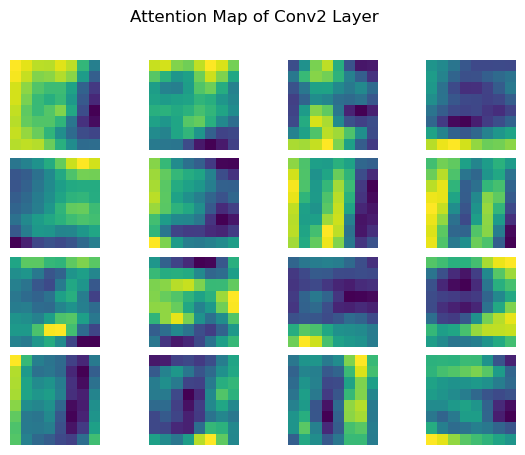

In [12]:
# Plot the attension map.

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

round_num = 4
cid = 2
aggregate = True

clients = fl_exp.get_clients(round_num=round_num)
model = Net().to(DEVICE)
model.load_state_dict(clients[cid])

# Hook to capture the feature maps
activations = []

def hook_fn(module, input, output):
    activations.append(output)

# Register hooks to the convolutional layers
model.conv2.register_forward_hook(hook_fn)
# model.conv2.register_forward_hook(hook_fn)
_, _, test_loader_1 = fl_exp.client_loaders[cid]

loss, accuracy = test(model, test_loader_1, "cuda")

if(aggregate):
    activation_single = activations[0].mean(dim=0)
else:
    activation = activations[0].squeeze(0)  # Remove batch dimension
    activation_single = activation[0]  # Shape: [num_channels, height, width]

# Number of filters (channels) in the layer
num_filters = activation_single.shape[0]

# Plot the activation maps
fig, axs = plt.subplots(4, 4, figsize=(7, 5))
fig.suptitle("Attention Map of Conv2 Layer")
for i in range(num_filters):
    axs[i//4, i%4].imshow(activation_single[i].detach().cpu().numpy(), cmap='viridis')
    axs[i//4, i%4].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('plots/attention_c2.pdf')
plt.show()


In [ ]:
# Better attension map using grad cam
# Reference: https://github.com/jacobgil/pytorch-grad-cam

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

round_num = 4
cid = 2
aggregate = True

clients = fl_exp.get_clients(round_num=round_num)
model = Net().to(DEVICE)
model.load_state_dict(clients[cid])

_, _, test_loader_1 = fl_exp.client_loaders[cid]

# Get a batch of test data
data_iter = iter(test_loader_1)
images, labels = data_iter.next()
input_tensor = images.to(DEVICE)

# Define the target layers for GradCAM
target_layers = [model.conv2]

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(label.item()) for label in labels]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
    # In this example grayscale_cam has the same number of images as the input batch:
    for i in range(len(grayscale_cam)):
        grayscale_cam_single = grayscale_cam[i, :]
        rgb_img = input_tensor[i].permute(1, 2, 0).cpu().numpy()
        visualization = show_cam_on_image(rgb_img, grayscale_cam_single, use_rgb=True)
        
        # Plot the activation maps
        plt.imshow(visualization)
        plt.axis('off')
        plt.title(f"Attention Map of Conv2 Layer for Image {i}")
        plt.savefig(f'plots/attention_grad_image_{i}.pdf')
        plt.show()

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'